In [1]:
import pandas as pd
# Import
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

import os
import json
# !pip install pywer
import pywer
# !pip install pyjarowinkler
from pyjarowinkler import distance as jwdistance
from tqdm import tqdm

class Const:
    OCR = 'ocr'
    GROUND = 'groundtruth'
    REGION = 'region'
    LINE = 'line'
    SENTENCE = 'sentence'
    FILE = 'filename'
    DATASET = 'dataset_name'
    PREDICTION = 'prediction'
    PROMPT = 'prompt'
    LANGUAGE = 'language'
    NONE = None


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Lookup datasets

In [379]:
datasets = []

for root, dirs, files in os.walk('../data/datasets/ocr/converted'):
    for file in files:
        if file.endswith(".jsonl"):
            input_file = os.path.join(root, file)
            if 'sample' not in input_file:
                with open(input_file) as f:
                    lines = f.read().splitlines()
                df_inter = pd.DataFrame(lines)
                df_inter.columns = ['json_element']
                df_inter['json_element'].apply(json.loads)
                df = pd.json_normalize(df_inter['json_element'].apply(json.loads))

                dataset_name = root.split('/')[-1].replace('_', '-')
                print(input_file, dataset_name)
                df['dataset_name'] = [dataset_name] * len(df)
                if 'ajmc' in dataset_name:
                    df['language'] = ['el'] * len(df)
                if 'overproof' in dataset_name:
                    df['language'] = ['en'] * len(df)
                if 'impresso' in dataset_name:
                    df['language'] = ['de'] * len(df)
                    
                datasets.append(df)
            

../data/datasets/ocr/converted/overproof-train.jsonl converted
../data/datasets/ocr/converted/icdar-2019-train.jsonl converted
../data/datasets/ocr/converted/ajmc-mixed/ajmc_mixed.jsonl ajmc-mixed
../data/datasets/ocr/converted/ajmc-mixed/ajmc_mixed_new.jsonl ajmc-mixed
../data/datasets/ocr/converted/overproof/overproof.jsonl overproof
../data/datasets/ocr/converted/icdar-2019/icdar-2019.jsonl icdar-2019
../data/datasets/ocr/converted/icdar-2017/icdar-2017-train.jsonl icdar-2017
../data/datasets/ocr/converted/icdar-2017/icdar-2017.jsonl icdar-2017
../data/datasets/ocr/converted/impresso/impresso-nzz.jsonl impresso
../data/datasets/ocr/converted/ajmc-primary/ajmc_primary_text.jsonl ajmc-primary


In [384]:
ajmc_mixed_old_path = '../data/datasets/ocr/converted/ajmc-mixed/ajmc_mixed.jsonl'
with open(ajmc_mixed_old_path) as f:
    lines = f.read().splitlines()
df_inter = pd.DataFrame(lines)
df_inter.columns = ['json_element']
df_inter['json_element'].apply(json.loads)
ajmc_mixed_old = pd.json_normalize(df_inter['json_element'].apply(json.loads))

len(ajmc_mixed_old)

2131

In [430]:
ajmc_primary_old_path = '../data/datasets/ocr/converted/ajmc-primary/ajmc_primary_text_new.jsonl'
with open(ajmc_primary_old_path) as f:
    lines = f.read().splitlines()
df_inter = pd.DataFrame(lines)
df_inter.columns = ['json_element']
df_inter['json_element'].apply(json.loads)
ajmc_primary_old = pd.json_normalize(df_inter['json_element'].apply(json.loads))

len(ajmc_primary_old)

57

In [391]:
ajmc_mixed_old.head()

filename dataset_name   
0  bsb10234118         ajmc  \
1  bsb10234118         ajmc   
2  bsb10234118         ajmc   
3  bsb10234118         ajmc   
4  bsb10234118         ajmc   

                                            ocr.line   
0  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. III. i...  \
1  I. T. XVI. p. 731. et 718. eamque κακόζηλον ἑρ...   
2  V. 9. Ἔνδον γὰρ ἀνήρ - Olim adnotavi articulum...   
3  δατος Aristoph. Lys. 370. αἱρώμεθ’ ὑμεῖς θοὔδ...   
4  xerit Sophocles χθονὸς ἀείρας et Oppian. Cyn. ...   

                              ocr.sentence   
0  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm.  \
1                                  p. 731.   
2                                    V. 9.   
3                                     Lys.   
4                                     Cyn.   

                                          ocr.region   
0  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. II. in...  \
1  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. II. in...   
2  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. II. in...   
3  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. II. in...   
4  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. II. in...   

                                    groundtruth.line   
0  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. II. in...  \
1  1. T. XVI. p. 731. et 718. eamque κακόζηλον ἑρ...   
2  V. 9. "Evdov γὰρ ‘arıjg — Olim adnotavi articu...   
3  durog Aristoph. Lys. 370. αἱρώμεθ’ ὑμεῖς θοὔδα...   
4  xerit Sophocles χθονὸς deigag et Oppian. Cyn. ...   

                      groundtruth.sentence   
0  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm.  \
1                                  p. 731.   
2                                    V. 9.   
3                                     Lys.   
4                                     Cyn.   

                                  groundtruth.region  
0  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. III. i...  
1  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. III. i...  
2  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. III. i...  
3  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. III. i...  
4  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. III. i...

In [431]:
ajmc_mixed_new_path = '../data/datasets/ocr/converted/ajmc-mixed/ajmc_mixed_new.jsonl'
with open(ajmc_mixed_new_path) as f:
    lines = f.read().splitlines()
df_inter = pd.DataFrame(lines)
df_inter.columns = ['json_element']
df_inter['json_element'].apply(json.loads)
ajmc_mixed_new = pd.json_normalize(df_inter['json_element'].apply(json.loads))

len(ajmc_mixed_new)

1291

In [432]:
ajmc_primary_new_path = '../data/datasets/ocr/converted/ajmc-primary/ajmc_primary_text_new.jsonl'
with open(ajmc_primary_new_path) as f:
    lines = f.read().splitlines()
df_inter = pd.DataFrame(lines)
df_inter.columns = ['json_element']
df_inter['json_element'].apply(json.loads)
ajmc_primary_new = pd.json_normalize(df_inter['json_element'].apply(json.loads))

len(ajmc_primary_new)

57

In [389]:
ajmc_mixed_new.columns

Index(['filename', 'dataset_name', 'ocr.line', 'ocr.sentence', 'ocr.region',
       'groundtruth.line', 'groundtruth.sentence', 'groundtruth.region'],
      dtype='object')

In [387]:
ajmc_mixed_new.head()

filename dataset_name   
0  bsb10234118         ajmc  \
1  bsb10234118         ajmc   
2  bsb10234118         ajmc   
3  bsb10234118         ajmc   
4  bsb10234118         ajmc   

                                            ocr.line   
0  adjici ut lectores integrioris formae admonean...  \
1  lsaeus Cir. p. 69. §. 11. μὴ θέλοι Lycurg. Leo...   
2  etc. et similia apud Demosthenem, cui Schaefer...   
3  eximere studet ad p. 1451, 61. cf. Ruediger ad...   
4  quit Schneiderus ad Civ. T. I. p. 230. T. III....   

                                        ocr.sentence   
0  adjici ut lectores integrioris formae admonean...  \
1                                                11.   
2  etc. et similia apud Demosthenem, cui Schaefer...   
3                                                cf.   
4                                      T. I. p. 230.   

                                          ocr.region   
0  adjici ut lectores integrioris formae admonean...  \
1  adjici ut lectores integrioris formae admonean...   
2  adjici ut lectores integrioris formae admonean...   
3  adjici ut lectores integrioris formae admonean...   
4  adjici ut lectores integrioris formae admonean...   

                                    groundtruth.line   
0  adjici ut lectores integrioris formae admonean...  \
1  Isaeus Cir. p.69. $.11. zu} θέλοι Lycurg. Leoe...   
2  etc. et similia apud Demosthenem, cui Schaefer...   
3  eximere studet ad p. 1451, 61. cf. Ruediger ad...   
4  quit Schneiderus ad Civ. T. I. p. 230. T. III....   

                                groundtruth.sentence   
0  adjici ut lectores integrioris formae admonean...  \
1                                                11.   
2  etc. et similia apud Demosthenem, cui Schaefer...   
3                                                cf.   
4                                      T. I. p. 230.   

                                  groundtruth.region  
0  adjici ut lectores integrioris formae admonean...  
1  adjici ut lectores integrioris formae admonean...  
2  adjici ut lectores integrioris formae admonean...  
3  adjici ut lectores integrioris formae admonean...  
4  adjici ut lectores integrioris formae admonean...

In [413]:
for idx, item in ajmc_mixed_new.iterrows():
    if 'thought' in item['ocr.line']:
        print(item)

filename                                                 cu31924087948174
dataset_name                                                         ajmc
ocr.line                                                        thought.’
ocr.sentence            ἀλλὰ τῆ σαυτοῦ φρενός] ‘But one proceeding fro...
ocr.region              478. κεναῖσιν] ‘ Vain’ because ren- dered frui...
groundtruth.line                                                thought.’
groundtruth.sentence    ἀλλὰ τῆς σαυτοῦ φρενός] ‘But one proceeding fr...
groundtruth.region      478. κεναῖσιν] ‘Vain.’ because ren- dered frui...
Name: 192, dtype: object


In [433]:
indices_mixed = ajmc_mixed_new[ajmc_mixed_new['ocr.line'].isin(ajmc_mixed_old['ocr.line'])].index
common_with_indices = ajmc_mixed_new.loc[indices_mixed]
common_with_indices.update(ajmc_mixed_new)

len(common_with_indices)

990

In [434]:
indices_primary = ajmc_primary_new[ajmc_primary_new['ocr.line'].isin(ajmc_primary_old['ocr.line'])].index
common_with_indices = ajmc_primary_new.loc[indices_primary]
common_with_indices.update(ajmc_primary_new)

len(common_with_indices)

57

In [417]:
ajmc_mixed_new[ajmc_mixed_new['ocr.line'].isin(ajmc_mixed_old['ocr.line'])]

filename dataset_name   
0      bsb10234118         ajmc  \
1      bsb10234118         ajmc   
2      bsb10234118         ajmc   
3      bsb10234118         ajmc   
4      bsb10234118         ajmc   
...            ...          ...   
1286  Wecklein1894         ajmc   
1287  Wecklein1894         ajmc   
1288  Wecklein1894         ajmc   
1289  Wecklein1894         ajmc   
1290  Wecklein1894         ajmc   

                                               ocr.line   
0     adjici ut lectores integrioris formae admonean...  \
1     lsaeus Cir. p. 69. §. 11. μὴ θέλοι Lycurg. Leo...   
2     etc. et similia apud Demosthenem, cui Schaefer...   
3     eximere studet ad p. 1451, 61. cf. Ruediger ad...   
4     quit Schneiderus ad Civ. T. I. p. 230. T. III....   
...                                                 ...   
1286  μέγα proleptiſches Prädikat wie δεινόν 1124. 1...   
1287  ſtellend, heilſam. - Vgl. Aſch. Eum. 520 ἔσθ’ ...   
1288  mäßige des Inhalts. 1090. Vgl. Eur. Phön. 1657...   
1289  mäßige des Inhalts. 1090. Vgl. Eur. Phön. 1657...   
1290  mäßige des Inhalts. 1090. Vgl. Eur. Phön. 1657...   

                                           ocr.sentence   
0     adjici ut lectores integrioris formae admonean...  \
1                                                   11.   
2     etc. et similia apud Demosthenem, cui Schaefer...   
3                                                   cf.   
4                                         T. I. p. 230.   
...                                                 ...   
1286                                               Vgl.   
1287                                               Vgl.   
1288                                               Vgl.   
1289                                               Eur.   
1290                                              Phön.   

                                             ocr.region   
0     adjici ut lectores integrioris formae admonean...  \
1     adjici ut lectores integrioris formae admonean...   
2     adjici ut lectores integrioris formae admonean...   
3     adjici ut lectores integrioris formae admonean...   
4     adjici ut lectores integrioris formae admonean...   
...                                                 ...   
1286  pareat. 1076. πρόβλημα ». i. dem nicht etwas, ...   
1287  pareat. 1076. πρόβλημα ». i. dem nicht etwas, ...   
1288  pareat. 1076. πρόβλημα ». i. dem nicht etwas, ...   
1289  pareat. 1076. πρόβλημα ». i. dem nicht etwas, ...   
1290  pareat. 1076. πρόβλημα ». i. dem nicht etwas, ...   

                                       groundtruth.line   
0     adjici ut lectores integrioris formae admonean...  \
1     Isaeus Cir. p.69. $.11. zu} θέλοι Lycurg. Leoe...   
2     etc. et similia apud Demosthenem, cui Schaefer...   
3     eximere studet ad p. 1451, 61. cf. Ruediger ad...   
4     quit Schneiderus ad Civ. T. I. p. 230. T. III....   
...                                                 ...   
1286  μέγα proleptiſches Prädikat wie δεινόν 1124. 1...   
1287  ſtellend, heilſam. — Vgl. Aſch. Eum. 920 ἔσθ’ ...   
1288  mäßige des Inhalts. 1090. Vgl. Eur. Phön. 1657...   
1289  mäßige des Inhalts. 1090. Vgl. Eur. Phön. 1657...   
1290  mäßige des Inhalts. 1090. Vgl. Eur. Phön. 1657...   

                                   groundtruth.sentence   
0     adjici ut lectores integrioris formae admonean...  \
1                                                   11.   
2     etc. et similia apud Demosthenem, cui Schaefer...   
3                                                   cf.   
4                                         T. I. p. 230.   
...                                                 ...   
1286                                               Vgl.   
1287                                               Vgl.   
1288                                               Vgl.   
1289                                               Eur.   
1290                                              Phön.   

                                     groundt

In [395]:
not_common = ajmc_mixed_new[~ajmc_mixed_new['groundtruth.line'].isin(ajmc_mixed_old['groundtruth.line'])]
not_common

filename dataset_name                                 ocr.line   
119   cu31924087948174         ajmc  mighty power of rumour spreads abroad.’  \
152   cu31924087948174         ajmc    ‘He smote beneath the ribs and ripped   
188   cu31924087948174         ajmc      481. ὑπόβλητον] ‘False’ i.e. unreal   
189   cu31924087948174         ajmc  and not your own. Supr. 189, εἰ δʼ ὑπο-   
190   cu31924087948174         ajmc        482. ἀλλὰ τῆς σαυτοῦ φρενός] ‘But   
...                ...          ...                                      ...   
1131   sophokle1v3soph         ajmc             1352. τὸν ἐσθλόν giebt dem   
1132   sophokle1v3soph         ajmc              Od. den Spruch 1345 zurück.   
1133   sophokle1v3soph         ajmc             1353. ,, Ein Nachgeben gegen   
1134   sophokle1v3soph         ajmc        ten den Leuten für unzuverlässig.   
1135   sophokle1v3soph         ajmc             Agamemnon macht dem Odysseus   

                                           ocr.sentence   
119   ἀέξει] Not "exaggerates,’ for the evil could n...  \
152   πλευροκοπῶν δίχ’ ἀνερρήγνυ] ‘He smote beneath ...   
188                                                481.   
189                                               Supr.   
190                                                482.   
...                                                 ...   
1131                                              1352.   
1132                            den Spruch 1345 zurück.   
1133                                            . 1353.   
1134             gel- ten den Leuten für unzuverlässig.   
1135  Agamemnon macht dem Odysseu © acht N S den Vor...   

                                             ocr.region   
119   the fiery man. Essay on L. §9. P. 12, 2. If το...  \
152   229. περίφαντος. . θανεῦται] ‘He will be disco...   
188   478. κεναῖσιν] ‘ Vain’ because ren- dered frui...   
189   478. κεναῖσιν] ‘ Vain’ because ren- dered frui...   
190   478. κεναῖσιν] ‘ Vain’ because ren- dered frui...   
...                                                 ...   
1131  1352. τὸν ἐσθλόν giebt dem Od. den Spruch 1345...   
1132  1352. τὸν ἐσθλόν giebt dem Od. den Spruch 1345...   
1133  1352. τὸν ἐσθλόν giebt dem Od. den Spruch 1345...   
1134  Lage der Dinge ihnen abfallen, gel- ten den Le...   
1135  Lage der Dinge ihnen abfallen, gel- ten den Le...   

                             groundtruth.line   
119   mighty power of rumour spreads abroad.’  \
152     ‘He smote beneath the ribs and ripped   
188     481. ὑπόβλητον] ‘False,’ ĩ. e. unreal   
189      and not your own. Supr. 189, εἰ imo-   
190          482. ἀλλὰ τῆ σαυτοῦ φρενός] ‘But   
...                                       ...   
1131               1352. τὸν ἐσθλόν giebt dem   
1132              Od. den Spruch 1345 zurück.   
1133              1353. ,,Ein Nachgeben gegen   
1134        ten den Leuten für unzuverlässig.   
1135              Agamemnon macht dem Odysseu   

                                   groundtruth.sentence   
119   ἀέξει] Not ‘exaggerates,’ for the evil could n...  \
152   πλευροκοπῶν δίχʼ ἀνερρήγνυ] ‘He smote beneath ...   
188                                                481.   
189                                               Supr.   
190                                                482.   
...                                                 ...   
1131                                              1352.   
1132                            den Spruch 1345 zurück.   
1133                                              1353.   
1134             gel- ten den Leuten für unzuverlässig.   
1135  Agamemnon macht dem Odysseus den Vorwurf des W...   

                                     groundtruth.region  
119   the fiery man.’ Essay on L. § 9. p. 12, 2. If ...  
152   229. περίφαντος.. θανεῖται] ‘He will be discov...  
188   478. κεναῖσιν] ‘Vain.’ because ren- dered frui...  
189   478. κεναῖσιν] ‘Vain.’ because ren- dered frui...  
190   478. κεναῖσιν] ‘Vain.’ because ren- dered

In [3]:
print('Number of unique lines/sentences/regions.\n')
for dataset in datasets:
    print('Dataset:', dataset['dataset_name'].unique()[0], len(dataset), 'with duplicates')
    print('No. lines:', dataset['ocr.line']. nunique(), '/', len(dataset['ocr.sentence']), 
          'No. sentences:', dataset['ocr.sentence']. nunique(), '/', len(dataset['ocr.sentence']), 
          'No. regions:', dataset['ocr.region']. nunique(), '/', len(dataset['ocr.region']))
    print('-'*80)

Number of unique lines/sentences/regions.

Dataset: ajmc-mixed 2131 with duplicates
No. lines: 870 / 2131 No. sentences: 679 / 2131 No. regions: 63 / 2131
--------------------------------------------------------------------------------
Dataset: overproof 2669 with duplicates
No. lines: 2278 / 2669 No. sentences: 399 / 2669 No. regions: 41 / 2669
--------------------------------------------------------------------------------
Dataset: icdar-2019 404 with duplicates
No. lines: 0 / 404 No. sentences: 404 / 404 No. regions: 41 / 404
--------------------------------------------------------------------------------
Dataset: icdar-2017 477 with duplicates
No. lines: 0 / 477 No. sentences: 461 / 477 No. regions: 28 / 477
--------------------------------------------------------------------------------
Dataset: impresso 1563 with duplicates
No. lines: 1256 / 1563 No. sentences: 577 / 1563 No. regions: 203 / 1563
--------------------------------------------------------------------------------
Data

In [4]:
# GENERATE_SAMPLE = False

# if GENERATE_SAMPLE:
#     from sklearn.model_selection import train_test_split

#     files_keep, files_removed, _, _ = train_test_split(dataset, dataset['dataset_name'], 
#                                                        test_size=0.90, random_state=42)
    
# if GENERATE_SAMPLE:
#     output_file = '../data/datasets/ocr/converted/sample/sample.jsonl'
#     with open(output_file, "w") as outfile:
#         for index, row in files_keep.iterrows():

#             json_line = json.dumps({Const.LANGUAGE: row['language'],
#                                     Const.FILE: row['filename'],
#                                     Const.DATASET: row['dataset_name'],
#                                     Const.OCR: {Const.LINE: row['ocr.line'],
#                                                 Const.SENTENCE: row['ocr.sentence'],
#                                                 Const.REGION: row['ocr.region']}, 
#                                     Const.GROUND: {Const.LINE: row['groundtruth.line'],
#                                                    Const.SENTENCE: row['groundtruth.sentence'],
#                                                    Const.REGION: row['groundtruth.region']},
#                                     'File': row['File'], 
#                                     'Date': row['Date'],
#                                     'Type': row['Type'], 
#                                     'NbAlignedChar': row['NbAlignedChar'], 
#                                     'article_id': row['article_id']
#                                     })

#             outfile.write(json_line + "\n")
#             outfile.flush()
            
            

In [4]:
def read_line_by_line(filename):
    pass

def json_load(text):
    
    try:
        loaded_line = json.loads(text)
    except:
        import pdb;pdb.set_trace()
        print(text)
    return loaded_line

In [146]:
def get_icdar_2017_lang(filename):
    lang = filename.split('/')[-2].split('_')[0]
    if lang =='eng':
        lang = 'en'
    return lang


### Analsys of preliminary results

In [618]:
from tqdm import tqdm
import os

results = []

# First traversal to get count of .jsonl files
jsonl_count = 0
for root, dirs, files in os.walk('../data/output'):
    for file in files:
        if file.endswith(".jsonl"):
            jsonl_count += 1

# Second traversal to do the processing with tqdm progress bar
with tqdm(total=jsonl_count) as pbar:
    for root, dirs, files in os.walk('../data/output'):
        for file in files:
            if file.endswith(".jsonl"):
                input_file = os.path.join(root, file)            
                if 'sample' not in input_file:
                    prompt = root.split('/')[-2]
                    with open(input_file) as f:
                        text = f.read()
                    with open(input_file) as f:
                        lines = f.readlines()

                    # Check correct lines
                    text = text.replace('\n', '')
                    text_list = text.split('}}{"')
                    json_objects = []

                    for i, t in enumerate(text_list):
                        if i != 0:
                            t = '{"' + t
                        if i != len(text_list) - 1:
                            t = t + '}'
                        if not t.endswith('}}'):
                            json_objects.append(t + '}\n')
                        else:
                            json_objects.append(t + '\n')

                    df_inter = pd.DataFrame(json_objects)
                    df_inter.columns = ['json_element']

                    dataset_name = root.split('/')[-1].replace('_', '-')
                    model_dataset_name = file[8:-6]
                    model_name = model_dataset_name.replace(root.split('/')[-1] + '-', '').strip()
                    try:
                        df_inter['json_element'].apply(lambda x: json_load(x))
                        df = pd.json_normalize(df_inter['json_element'].apply(json.loads))

                        df['model'] = [model_name] * len(df)

                        df['dataset_name'] = [dataset_name] * len(df)
                        df['prompt'] = [prompt] * len(df)

                        with open(f'../data/prompts/{prompt}.txt', 'r') as f:
                            prompt_text = f.read()

                        df['prompt_text'] = [prompt_text] * len(df)

                        df['dataset_name'] = [dataset_name] * len(df)
                        if 'ajmc' in dataset_name:
                            df['language'] = ['el'] * len(df)
                        if 'overproof' in dataset_name:
                            df['language'] = ['en'] * len(df)
                        if 'impresso' in dataset_name:
                            df['language'] = ['de'] * len(df)
                        if 'htrec' in dataset_name:
                            df['language'] = ['el'] * len(df)

#                         print(dataset_name, model_name, prompt)

                        if dataset_name == 'icdar-2017':
                            df['language'] = df['filename'].apply(get_icdar_2017_lang)

                        if dataset_name == 'ajmc-mixed':
                            df = df.loc[indices_mixed]
                            df.update(ajmc_mixed_new)
                            df['dataset_name'] = ['ajmc-mixed'] * len(df)
                        if dataset_name == 'ajmc-primary-text':
                            df = df.loc[indices_primary]
                            df.update(ajmc_primary_new)
                            df['dataset_name'] = ['ajmc-primary-text'] * len(df)
        
    #                     print(df['language'].unique())
                        results.append(df)
                    except Exception as ex:
                        print('We could not load {}: {}'.format(file, ex))
                    pbar.update()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:26<00:00,  5.54it/s]


In [489]:
len(results)

147

In [490]:
pd.concat(results)['dataset_name'].unique()

array(['impresso-nzz', 'overproof', 'htrec', 'ajmc-mixed', 'icdar-2019',
       'icdar-2017', 'ajmc-primary-text'], dtype=object)

In [491]:
results[0].head()

filename  dataset_name   
0  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz  \
1  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   
2  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   
3  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   
4  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   

                      ocr.line           ocr.sentence   
0               Pränumeration.         Pränumeration.  \
1               Pränumeration.         Pränumeration.   
2  Jährlich............. 8 Fr.  Jährlich.............   
3  Jährlich............. 8 Fr.  Jährlich.............   
4  Jährlich............. 8 Fr.                  8 Fr.   

                    ocr.region             groundtruth.line   
0               Pränumeration.               Pränumeration.  \
1               Pränumeration.               Pränumeration.   
2  Jährlich............. 8 Fr.  Jährlich............. 8 Fr.   
3  Jährlich............. 8 Fr.  Jährlich............. 8 Fr.   
4  Jährlich............. 8 Fr.  Jährlich............. 8 Fr.   

    groundtruth.sentence           groundtruth.region   
0         Pränumeration.               Pränumeration.  \
1         Pränumeration.               Pränumeration.   
2  Jährlich.............  Jährlich............. 8 Fr.   
3  Jährlich.............  Jährlich............. 8 Fr.   
4                  8 Fr.  Jährlich............. 8 Fr.   

                                   prediction.prompt   
0  Correct the spelling and grammar of the follow...  \
1                                                NaN   
2  Correct the spelling and grammar of the follow...   
3                                                NaN   
4  Correct the spelling and grammar of the follow...   

                                     prediction.line   
0  30.5 The spelling and grammar is corrected.\n30.6  \
1  30.5 The spelling and grammar is corrected.\n30.6   
2                          69.99 EUR 55.55 EUR 125.9   
3                          69.99 EUR 55.55 EUR 125.9   
4                          69.99 EUR 55.55 EUR 125.9   

                                 prediction.sentence   
0  30.5 The spelling and grammar is corrected.\n30.6  \
1  30.5 The spelling and grammar is corrected.\n30.6   
2  ine...........Ausstellung............der.........   
3  ine...........Ausstellung............der.........   
4  (20%) 1. The book we studied yesterday was ___...   

                                   prediction.region   
0  30.5 The spelling and grammar is corrected.\n30.6  \
1  30.5 The spelling and grammar is corrected.\n30.6   
2                          69.99 EUR 55.55 EUR 125.9   
3                          69.99 EUR 55.55 EUR 125.9   
4                          69.99 EUR 55.55 EUR 125.9   

                           model           prompt   
0  decapoda-research-llama-7b-hf  prompt_basic_02  \
1  decapoda-research-llama-7b-hf  prompt_basic_02   
2  decapoda-research-llama-7b-hf  prompt_basic_02   
3  decapoda-research-llama-7b-hf  prompt_basic_02   
4  decapoda-research-llama-7b-hf  prompt_basic_02   

                                         prompt_text language  
0  Correct the spelling and grammar of the follow...       de  
1  Correct the spelling and grammar of the follow...       de  
2  Correct the spelling and grammar of the follow...       de  
3  Correct the spelling and grammar of the follow...       de  
4  Correct the spelling and grammar of the follow...       de

## Post-process

In [438]:
import Levenshtein
from Levenshtein import distance

def compute_normalized_levenshtein_similarity(ocr_text, ground_truth_text):
    length = max(len(ocr_text), len(ground_truth_text))
    levenshtein_distance = distance(ocr_text, ground_truth_text)
    similarity = (length - levenshtein_distance) / length
    return similarity

def compute_jaccard(ocr_text, ground_truth_text):
    try: 
        return jwdistance.get_jaro_distance(ocr_text, ground_truth_text)
    except:
        return 0.0

def get_improvement(original_similarity, corrected_similarity):
    
    if original_similarity == 0:
        return min(max(corrected_similarity, -1), 1)
    elif original_similarity != corrected_similarity:
        return min(max((corrected_similarity - original_similarity) / original_similarity, -1), 1)
    elif original_similarity == corrected_similarity:
        return 0
    else:
        return 0 if corrected_similarity < 1 else 1


In [327]:
gt_text = "149 Obrázek z maloměstského kukátka. Podává L. Gro"
ocr_text = "149 Obrázek z maloměstského kukátka. Podává L. Grw"
pred_text = """Correct the text: "149 Obrázek z maloměstského kukátka. Podává L. Grwsmannová-Brodská. Místo děje: salon paní stavitelky; doba: čas věnovaný kávové „visitě"; jednající osoby: dámy přednější honorace městské, z nichž •většina je mladá a některé skutečně hezké. Na stole prostřeném krásným ubrusem damaškovým stojí talíře s koláčky, věnečky a preclíčky, kol toho pěkně se vyjímají křišťálové sklenky s vodou, stříbrné lžičky a šálky z jemného porcelánu, jejichž vonný obsah na přítomné paničky zdá se velmi blaze působiti. Ze živějšího hovoru vyznívá právě hlas paní notářky, která ve spravedlivém rozhorlení mluví: „Ano, mé dámy, již jest to takové! Samy ráčily jste býti svědky, jak svorně i jednohlasně byl přijat návrh paní sládkové, abychom si pořídily kroje národní a tak přispěly ku zvýšení lesku slavnosti, již pořádá náš statečný studentský spolek „Hvězda", a když již nás páni akademikové poctili důvěrou, že v naše ruce složili starost o buffet a jiné ještě funkce, tož měly bychom snad též jiti za příkladem slečen berních a vzdáti se činnosti jen proto, že se zdá paní berní národní kroj pro tři dcery býti nějakou zby tečnou výlohou?" Paničky projevovaly svoji nevoli, každá jiným spůsobem. Mladá paní adjunktová v duchu si umiňovala, že ve svém přátel ství k berňovům trochu ochladne; to tak! aby ten jejich pošetilý nápad, úóinkovati při slavnosti v obyčejném oděvu, přece zvítězil a dámám se bylo odříci těch půvabných krojů venkovských, co by si jen ona, paní adjunktová, počala s tou haldou brokátu, atlasu, krajek, stuh a aksamitu, za což vydala nejednu desítku, utěšujíc se tím, jak jí to bude slušeti! Hm, a škodu z toho také míti nebude, muž se bude musit po několik měsíců uskrovnit, služka se má beztoho též až příliš dobře, uhradí se to na domácnosti a bude! Nyní ujala se slova paní doktorka: „Aj, od berních to není nic divného, považte jen: tolik dětí! Vždyť my všecky víme, že kdyby sobě slečny toillety samy ne řídily, mnohého by nemohly míti; ony pak mají zásadu: nemá-li být něco pěkné, tož raději nic!" „Pravda, ale slečny Elišky, té nejmladší, jest mně líto; těšila se velice na selský kroj." „Ba ano, byla by v něm vypadala roztomile." „Nyní má po radosti." „Inu, proč má tak nepřející matinku." „To není to, má drahá, jest v tom však jiný háček." „Ah, ano; vždyť víme, že sotva tak tak vyjdou." „Ale na knihy, které jsi tvá, jinak našel byste jen krytí těch mladých mozí, jinak je vydáte." „A tak bude, ostatně jdu až na knihy; ale slyšet jsem od někoho, že o krojech něco dělat, a že to bylo bude dělat národní, a když jsi tento národní učil jak, pak by měl nalézt tuto kartu, ta by se jistě mohla vyměnit se všemi. Můžete-li to od nás odkázat?" Všem ozdravila její hlas, když řekla: „Já, já! a já ho učím. S těmi páne akademiky jsem již mohla vyprávět o světě, v němž vznítí v některé nocy a jednoho dne vyrostá vám hrozný kouzelný strom zůstane, o němž je psáno: ‚Už jen žádat!" 50 V tuto chvíli koupili mohou-li všichni pánové i paní, že když jsi to čerpala, dá se jen kupit. Přižili to, a já jim vám koupi ukáži.
„A já už jste tím vyděštila. Pánové, děkuji vám za chytré vědomí, se kterým vám projeví, že se už točí dívčí zrcadlo." – 151"""
                
get_improvement(compute_normalized_levenshtein_similarity(gt_text, ocr_text), 
                compute_normalized_levenshtein_similarity(gt_text, pred_text))




-0.9839406962029382

In [328]:
gt_text = "302."
ocr_text = "302."
pred_text = "302."

get_improvement(compute_normalized_levenshtein_similarity(gt_text, ocr_text), 
                compute_normalized_levenshtein_similarity(gt_text, pred_text))



0

In [152]:
gt_text = 'testing'
ocr_text = 'resting'
pred_text = 'testing'

compute_normalized_levenshtein_similarity(gt_text, ocr_text), distance(gt_text, ocr_text)

(0.8571428571428571, 1)

In [153]:
get_improvement(compute_normalized_levenshtein_similarity(gt_text, ocr_text), 
                compute_normalized_levenshtein_similarity(gt_text, pred_text))


0.16666666666666674

In [154]:
import Levenshtein

# Example strings
s1 = "testing"
s2 = "resting"

# Calculate the Levenshtein distance
lev_distance = Levenshtein.distance(s1, s2)
print(f"Levenshtein distance: {lev_distance}")

# Calculate the Levenshtein similarity
similarity = (max(len(s1), len(s2)) - lev_distance) / max(len(s1), len(s2))
print(f"Levenshtein similarity: {similarity:.2f}")


Levenshtein distance: 1
Levenshtein similarity: 0.86


In [288]:
def postprocess(pred_text, ground_text, prompt_text):
    if pred_text is not None:
        if type(pred_text) == str:
            if len(pred_text.strip()) > 0:
                if pred_text.startswith('"'):
                    pred_text = pred_text[1:]
                if pred_text.endswith('"'):
                    pred_text = pred_text[:-1]
            if prompt_text in pred_text:
                pred_text = pred_text.replace(prompt_text, '').strip()
                print(prompt_text)
            prompt_text_empty = prompt_text.replace("{{TEXT}}", '').strip()
            if prompt_text_empty in pred_text:
                pred_text = pred_text.replace(prompt_text_empty, '').strip()
                print(prompt_text_empty)
            prompt_text = prompt_text.replace("{{TEXT}}", pred_text)
            if prompt_text in pred_text:
                pred_text = pred_text.replace(prompt_text, '').strip()
                print(prompt_text)
            pred_text = pred_text.strip()

            # Cut the pred_text to the length of the ground_text
            pred_text = pred_text[:len(ground_text) + len(ground_text)//4]
    
    return pred_text


In [619]:
for idx, result in tqdm(enumerate(results), total=len(results)):
    
    try:
        results[idx] = results[idx].fillna('No text')
    except:
        pass
#     results[idx] = results[idx][results[idx].model != 'tloen-alpaca-lora-7b']
    
    dataset_name = results[idx]['dataset_name'].unique()[0]
    model_name = results[idx]['model'].unique()[0]
    prompt = results[idx]['prompt'].unique()[0]
    
    print('Dataset:', dataset_name, 'Model:', model_name, 'Prompt:', prompt)
    
    if 'alpaca' not in model_name:
    
        if 'icdar' in dataset_name:
            text_types = ['sentence', 'region']
        else:
            text_types = ['line', 'sentence', 'region']
        for segment_type in text_types:

            results[idx]['length'] = results[idx][f'groundtruth.{segment_type}'].str.len()
            results[idx] = results[idx][results[idx]['length'] > 3]

#             results[idx][f'prediction.{segment_type}'] = results[idx][f'prediction.{segment_type}'].apply(postprocess)
            
#             # Compute Jaccard similarity
#             results[idx][f'{segment_type}-jaccard-ocr'] = \
#                 results[idx].apply(lambda x: compute_jaccard(x[f'groundtruth.{segment_type}'],
#                                                              x[f'ocr.{segment_type}']), axis=1)
            
#             results[idx][f'{segment_type}-jaccard-pred'] = \
#                 results[idx].apply(lambda x: compute_jaccard(x[f'groundtruth.{segment_type}'],
#                                                              x[f'prediction.{segment_type}']), axis=1)
            
            # Compute Lev similarity
            results[idx][f'{segment_type}-lev-ocr'] = \
                results[idx].parallel_apply(lambda x: compute_normalized_levenshtein_similarity(x[f'groundtruth.{segment_type}'],
                                                                                     x[f'ocr.{segment_type}']), axis=1)
            results[idx][f'{segment_type}-lev-pred'] = \
                results[idx].parallel_apply(lambda x: compute_normalized_levenshtein_similarity(x[f'groundtruth.{segment_type}'],
                                                                                     x[f'prediction.{segment_type}']), axis=1)

            results[idx][f'{segment_type}-lev-improvement'] = \
                results[idx].parallel_apply(lambda x: get_improvement(x[f'{segment_type}-lev-ocr'],
                                                             x[f'{segment_type}-lev-pred']), axis=1)
            # Compute CER
#             results[idx][f'{segment_type}-cer-ocr'] = results[idx].parallel_apply(lambda x: pywer.cer(x[f'groundtruth.{segment_type}'], 
#                                                                                              x[f'ocr.{segment_type}']), axis=1)
#             results[idx][f'{segment_type}-cer-pred'] = results[idx].parallel_apply(lambda x: pywer.cer(x[f'groundtruth.{segment_type}'], 
#                                                                                               x[f'prediction.{segment_type}']), axis=1)

#             # Compute WER
#             results[idx][f'{segment_type}-wer-ocr'] = results[idx].parallel_apply(lambda x: pywer.wer(x[f'groundtruth.{segment_type}'], 
#                                                                                              x[f'ocr.{segment_type}']), axis=1)
#             results[idx][f'{segment_type}-wer-pred'] = results[idx].parallel_apply(lambda x: pywer.wer(x[f'prediction.{segment_type}'], 
#                                                          x[f'groundtruth.{segment_type}']), axis=1)

#             # CER & WER improvement
#             results[idx][f'{segment_type}-cer-improvement'] = \
#                 results[idx].parallel_apply(lambda x: get_improvement(x[f'{segment_type}-cer-ocr'],
#                                                              x[f'{segment_type}-cer-pred']), axis=1)
#             results[idx][f'{segment_type}-wer-improvement'] = \
#                 results[idx].parallel_apply(lambda x: get_improvement(x[f'{segment_type}-wer-ocr'],
#                                                              x[f'{segment_type}-wer-pred']), axis=1)

#             # Create a new column for the OCR noise level bins
#             results[idx][f"{segment_type}-ocr-noise-group"] = pd.cut(results[idx][f'{segment_type}-lev-ocr'], 
#                                                      bins=bins, labels=labels, 
#                                                      include_lowest=True)


  0%|                                                                                                                                                                                                                                                           | 0/147 [00:00<?, ?it/s]

Dataset: impresso-nzz Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_02


  1%|█▋                                                                                                                                                                                                                                                 | 1/147 [00:01<03:56,  1.62s/it]

Dataset: impresso-nzz Model: davinci Prompt: prompt_basic_02


  1%|███▎                                                                                                                                                                                                                                               | 2/147 [00:03<03:37,  1.50s/it]

Dataset: impresso-nzz Model: bigscience-bloom-560m Prompt: prompt_basic_02


  2%|████▉                                                                                                                                                                                                                                              | 3/147 [00:04<03:30,  1.46s/it]

Dataset: impresso-nzz Model: facebook-opt-350m Prompt: prompt_basic_02


  3%|██████▌                                                                                                                                                                                                                                            | 4/147 [00:05<03:17,  1.38s/it]

Dataset: impresso-nzz Model: gpt-4 Prompt: prompt_basic_02


  3%|████████▎                                                                                                                                                                                                                                          | 5/147 [00:07<03:12,  1.36s/it]

Dataset: impresso-nzz Model: gpt-3.5-turbo Prompt: prompt_basic_02


  4%|█████████▉                                                                                                                                                                                                                                         | 6/147 [00:08<03:04,  1.31s/it]

Dataset: impresso-nzz Model: gpt2 Prompt: prompt_basic_02


  5%|███████████▌                                                                                                                                                                                                                                       | 7/147 [00:09<03:03,  1.31s/it]

Dataset: overproof Model: davinci Prompt: prompt_basic_02


  5%|█████████████▏                                                                                                                                                                                                                                     | 8/147 [00:12<03:55,  1.69s/it]

Dataset: overproof Model: gpt-4 Prompt: prompt_basic_02


  6%|██████████████▉                                                                                                                                                                                                                                    | 9/147 [00:14<04:13,  1.83s/it]

Dataset: overproof Model: gpt-3.5-turbo Prompt: prompt_basic_02


  7%|████████████████▍                                                                                                                                                                                                                                 | 10/147 [00:16<04:18,  1.89s/it]

Dataset: overproof Model: gpt2 Prompt: prompt_basic_02


  7%|██████████████████                                                                                                                                                                                                                                | 11/147 [00:18<04:34,  2.02s/it]

Dataset: overproof Model: facebook-opt-350m Prompt: prompt_basic_02


  8%|███████████████████▊                                                                                                                                                                                                                              | 12/147 [00:20<04:49,  2.15s/it]

Dataset: overproof Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_02


  9%|█████████████████████▍                                                                                                                                                                                                                            | 13/147 [00:23<04:52,  2.18s/it]

Dataset: overproof Model: bigscience-bloom-560m Prompt: prompt_basic_02


 10%|███████████████████████                                                                                                                                                                                                                           | 14/147 [00:25<04:54,  2.22s/it]

Dataset: htrec Model: gpt-4 Prompt: prompt_basic_02


 10%|████████████████████████▋                                                                                                                                                                                                                         | 15/147 [00:26<04:06,  1.87s/it]

Dataset: htrec Model: bigscience-bloom-560m Prompt: prompt_basic_02


 11%|██████████████████████████▎                                                                                                                                                                                                                       | 16/147 [00:27<03:32,  1.62s/it]

Dataset: htrec Model: facebook-opt-350m Prompt: prompt_basic_02


 12%|███████████████████████████▉                                                                                                                                                                                                                      | 17/147 [00:28<03:09,  1.46s/it]

Dataset: htrec Model: gpt-3.5-turbo Prompt: prompt_basic_02


 12%|█████████████████████████████▋                                                                                                                                                                                                                    | 18/147 [00:29<02:52,  1.33s/it]

Dataset: htrec Model: davinci Prompt: prompt_basic_02


 13%|███████████████████████████████▎                                                                                                                                                                                                                  | 19/147 [00:31<02:47,  1.31s/it]

Dataset: htrec Model: gpt2 Prompt: prompt_basic_02


 14%|████████████████████████████████▉                                                                                                                                                                                                                 | 20/147 [00:32<02:41,  1.27s/it]

Dataset: htrec Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_02


 14%|██████████████████████████████████▌                                                                                                                                                                                                               | 21/147 [00:33<02:30,  1.19s/it]

Dataset: ajmc-mixed Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_02


 15%|████████████████████████████████████▏                                                                                                                                                                                                             | 22/147 [00:34<02:28,  1.19s/it]

Dataset: ajmc-mixed Model: bigscience-bloom-560m Prompt: prompt_basic_02


 16%|█████████████████████████████████████▊                                                                                                                                                                                                            | 23/147 [00:35<02:28,  1.20s/it]

Dataset: ajmc-mixed Model: gpt2 Prompt: prompt_basic_02


 16%|███████████████████████████████████████▌                                                                                                                                                                                                          | 24/147 [00:36<02:26,  1.19s/it]

Dataset: ajmc-mixed Model: facebook-opt-350m Prompt: prompt_basic_02


 17%|█████████████████████████████████████████▏                                                                                                                                                                                                        | 25/147 [00:37<02:26,  1.20s/it]

Dataset: ajmc-mixed Model: gpt-4 Prompt: prompt_basic_02


 18%|██████████████████████████████████████████▊                                                                                                                                                                                                       | 26/147 [00:39<02:23,  1.19s/it]

Dataset: ajmc-mixed Model: davinci Prompt: prompt_basic_02


 18%|████████████████████████████████████████████▍                                                                                                                                                                                                     | 27/147 [00:40<02:23,  1.20s/it]

Dataset: ajmc-mixed Model: gpt-3.5-turbo Prompt: prompt_basic_02


 19%|██████████████████████████████████████████████                                                                                                                                                                                                    | 28/147 [00:41<02:21,  1.19s/it]

Dataset: icdar-2019 Model: gpt2 Prompt: prompt_basic_02


 20%|███████████████████████████████████████████████▋                                                                                                                                                                                                  | 29/147 [00:42<02:09,  1.10s/it]

Dataset: icdar-2019 Model: bigscience-bloom-560m Prompt: prompt_basic_02


 20%|█████████████████████████████████████████████████▍                                                                                                                                                                                                | 30/147 [00:43<01:58,  1.02s/it]

Dataset: icdar-2019 Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_02


 21%|███████████████████████████████████████████████████                                                                                                                                                                                               | 31/147 [00:44<01:50,  1.05it/s]

Dataset: icdar-2019 Model: facebook-opt-350m Prompt: prompt_basic_02


 22%|████████████████████████████████████████████████████▋                                                                                                                                                                                             | 32/147 [00:44<01:44,  1.10it/s]

Dataset: icdar-2019 Model: gpt-4 Prompt: prompt_basic_02


 22%|██████████████████████████████████████████████████████▎                                                                                                                                                                                           | 33/147 [00:45<01:39,  1.15it/s]

Dataset: icdar-2019 Model: gpt-3.5-turbo Prompt: prompt_basic_02


 23%|███████████████████████████████████████████████████████▉                                                                                                                                                                                          | 34/147 [00:46<01:35,  1.18it/s]

Dataset: icdar-2019 Model: davinci Prompt: prompt_basic_02


 24%|█████████████████████████████████████████████████████████▌                                                                                                                                                                                        | 35/147 [00:47<01:33,  1.20it/s]

Dataset: icdar-2017 Model: bigscience-bloom-560m Prompt: prompt_basic_02


 24%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 36/147 [00:48<01:32,  1.19it/s]

Dataset: icdar-2017 Model: gpt-4 Prompt: prompt_basic_02


 25%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 37/147 [00:48<01:29,  1.22it/s]

Dataset: icdar-2017 Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_02


 26%|██████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 38/147 [00:49<01:29,  1.22it/s]

Dataset: icdar-2017 Model: davinci Prompt: prompt_basic_02


 27%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 39/147 [00:50<01:27,  1.23it/s]

Dataset: icdar-2017 Model: facebook-opt-350m Prompt: prompt_basic_02


 27%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                                | 40/147 [00:51<01:28,  1.21it/s]

Dataset: icdar-2017 Model: gpt2 Prompt: prompt_basic_02


 28%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                                              | 41/147 [00:52<01:27,  1.22it/s]

Dataset: icdar-2017 Model: gpt-3.5-turbo Prompt: prompt_basic_02


 29%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                                            | 42/147 [00:52<01:25,  1.23it/s]

Dataset: ajmc-primary-text Model: gpt-4 Prompt: prompt_basic_02


 29%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                                           | 43/147 [00:53<01:28,  1.18it/s]

Dataset: ajmc-primary-text Model: bigscience-bloom-560m Prompt: prompt_basic_02


 30%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                         | 44/147 [00:54<01:31,  1.13it/s]

Dataset: ajmc-primary-text Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_02


 31%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 45/147 [00:55<01:33,  1.09it/s]

Dataset: ajmc-primary-text Model: davinci Prompt: prompt_basic_02


 31%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 46/147 [00:56<01:34,  1.07it/s]

Dataset: ajmc-primary-text Model: facebook-opt-350m Prompt: prompt_basic_02


 32%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                    | 47/147 [00:58<01:42,  1.03s/it]

Dataset: ajmc-primary-text Model: gpt2 Prompt: prompt_basic_02


 33%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 48/147 [00:59<01:44,  1.05s/it]

Dataset: ajmc-primary-text Model: gpt-3.5-turbo Prompt: prompt_basic_02


 33%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 49/147 [01:00<01:46,  1.09s/it]

Dataset: impresso-nzz Model: decapoda-research-llama-7b-hf Prompt: prompt_complex_01


 34%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 50/147 [01:01<01:52,  1.16s/it]

Dataset: impresso-nzz Model: davinci Prompt: prompt_complex_01


 35%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 51/147 [01:03<01:59,  1.25s/it]

Dataset: impresso-nzz Model: bigscience-bloom-560m Prompt: prompt_complex_01


 35%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 52/147 [01:04<02:01,  1.28s/it]

Dataset: impresso-nzz Model: facebook-opt-350m Prompt: prompt_complex_01


 36%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 53/147 [01:05<02:00,  1.28s/it]

Dataset: impresso-nzz Model: gpt-4 Prompt: prompt_complex_01


 37%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 54/147 [01:07<01:59,  1.28s/it]

Dataset: impresso-nzz Model: gpt-3.5-turbo Prompt: prompt_complex_01


 37%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 55/147 [01:08<01:56,  1.27s/it]

Dataset: impresso-nzz Model: gpt2 Prompt: prompt_complex_01


 38%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 56/147 [01:09<01:56,  1.28s/it]

Dataset: overproof Model: davinci Prompt: prompt_complex_01


 39%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 57/147 [01:11<02:19,  1.55s/it]

Dataset: overproof Model: gpt-4 Prompt: prompt_complex_01


 39%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 58/147 [01:13<02:32,  1.72s/it]

Dataset: overproof Model: gpt-3.5-turbo Prompt: prompt_complex_01


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 59/147 [01:16<02:46,  1.89s/it]

Dataset: overproof Model: gpt2 Prompt: prompt_complex_01


 41%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 60/147 [01:18<02:56,  2.02s/it]

Dataset: overproof Model: facebook-opt-350m Prompt: prompt_complex_01


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 61/147 [01:20<03:03,  2.13s/it]

Dataset: overproof Model: decapoda-research-llama-7b-hf Prompt: prompt_complex_01


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 62/147 [01:23<03:11,  2.25s/it]

Dataset: overproof Model: bigscience-bloom-560m Prompt: prompt_complex_01


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 63/147 [01:25<03:12,  2.30s/it]

Dataset: htrec Model: gpt-4 Prompt: prompt_complex_01


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 64/147 [01:26<02:41,  1.94s/it]

Dataset: htrec Model: bigscience-bloom-560m Prompt: prompt_complex_01


 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 65/147 [01:28<02:20,  1.71s/it]

Dataset: htrec Model: facebook-opt-350m Prompt: prompt_complex_01


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 66/147 [01:29<02:04,  1.54s/it]

Dataset: htrec Model: gpt-3.5-turbo Prompt: prompt_complex_01


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 67/147 [01:30<01:53,  1.42s/it]

Dataset: htrec Model: davinci Prompt: prompt_complex_01


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 68/147 [01:31<01:43,  1.31s/it]

Dataset: htrec Model: gpt2 Prompt: prompt_complex_01


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 69/147 [01:32<01:37,  1.25s/it]

Dataset: htrec Model: decapoda-research-llama-7b-hf Prompt: prompt_complex_01


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 70/147 [01:33<01:32,  1.20s/it]

Dataset: ajmc-mixed Model: decapoda-research-llama-7b-hf Prompt: prompt_complex_01


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 71/147 [01:34<01:31,  1.20s/it]

Dataset: ajmc-mixed Model: bigscience-bloom-560m Prompt: prompt_complex_01


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 72/147 [01:36<01:30,  1.21s/it]

Dataset: ajmc-mixed Model: gpt2 Prompt: prompt_complex_01


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 73/147 [01:37<01:31,  1.24s/it]

Dataset: ajmc-mixed Model: facebook-opt-350m Prompt: prompt_complex_01


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 74/147 [01:38<01:35,  1.30s/it]

Dataset: ajmc-mixed Model: gpt-4 Prompt: prompt_complex_01


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 75/147 [01:40<01:38,  1.36s/it]

Dataset: ajmc-mixed Model: davinci Prompt: prompt_complex_01


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 76/147 [01:41<01:38,  1.38s/it]

Dataset: ajmc-mixed Model: gpt-3.5-turbo Prompt: prompt_complex_01


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 77/147 [01:43<01:42,  1.46s/it]

Dataset: icdar-2019 Model: gpt2 Prompt: prompt_complex_01


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 78/147 [01:44<01:31,  1.33s/it]

Dataset: icdar-2019 Model: bigscience-bloom-560m Prompt: prompt_complex_01


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 79/147 [01:45<01:33,  1.38s/it]

Dataset: icdar-2019 Model: decapoda-research-llama-7b-hf Prompt: prompt_complex_01


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 80/147 [01:46<01:23,  1.24s/it]

Dataset: icdar-2019 Model: facebook-opt-350m Prompt: prompt_complex_01


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 81/147 [01:47<01:15,  1.15s/it]

Dataset: icdar-2019 Model: gpt-4 Prompt: prompt_complex_01


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 82/147 [01:48<01:08,  1.05s/it]

Dataset: icdar-2019 Model: gpt-3.5-turbo Prompt: prompt_complex_01


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 83/147 [01:49<01:02,  1.02it/s]

Dataset: icdar-2019 Model: davinci Prompt: prompt_complex_01


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 84/147 [01:50<00:59,  1.06it/s]

Dataset: icdar-2017 Model: bigscience-bloom-560m Prompt: prompt_complex_01


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 85/147 [01:51<00:58,  1.07it/s]

Dataset: icdar-2017 Model: gpt-4 Prompt: prompt_complex_01


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 86/147 [01:52<00:59,  1.02it/s]

Dataset: icdar-2017 Model: decapoda-research-llama-7b-hf Prompt: prompt_complex_01


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 87/147 [01:53<01:03,  1.06s/it]

Dataset: icdar-2017 Model: davinci Prompt: prompt_complex_01


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 88/147 [01:54<01:02,  1.06s/it]

Dataset: icdar-2017 Model: facebook-opt-350m Prompt: prompt_complex_01


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 89/147 [01:55<01:00,  1.04s/it]

Dataset: icdar-2017 Model: gpt2 Prompt: prompt_complex_01


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 90/147 [01:56<00:58,  1.02s/it]

Dataset: icdar-2017 Model: gpt-3.5-turbo Prompt: prompt_complex_01


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 91/147 [01:57<00:53,  1.05it/s]

Dataset: ajmc-primary-text Model: gpt-4 Prompt: prompt_complex_01


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 92/147 [01:58<00:54,  1.01it/s]

Dataset: ajmc-primary-text Model: bigscience-bloom-560m Prompt: prompt_complex_01


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 93/147 [01:59<00:56,  1.05s/it]

Dataset: ajmc-primary-text Model: decapoda-research-llama-7b-hf Prompt: prompt_complex_01


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 94/147 [02:00<00:54,  1.04s/it]

Dataset: ajmc-primary-text Model: davinci Prompt: prompt_complex_01


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 95/147 [02:01<00:53,  1.03s/it]

Dataset: ajmc-primary-text Model: facebook-opt-350m Prompt: prompt_complex_01


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 96/147 [02:02<00:52,  1.04s/it]

Dataset: ajmc-primary-text Model: gpt2 Prompt: prompt_complex_01


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 97/147 [02:03<00:52,  1.04s/it]

Dataset: ajmc-primary-text Model: gpt-3.5-turbo Prompt: prompt_complex_01


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 98/147 [02:04<00:49,  1.02s/it]

Dataset: impresso-nzz Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_01


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 99/147 [02:05<00:52,  1.09s/it]

Dataset: impresso-nzz Model: davinci Prompt: prompt_basic_01


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 100/147 [02:07<00:55,  1.19s/it]

Dataset: impresso-nzz Model: bigscience-bloom-560m Prompt: prompt_basic_01


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 101/147 [02:08<00:57,  1.24s/it]

Dataset: impresso-nzz Model: facebook-opt-350m Prompt: prompt_basic_01


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 102/147 [02:10<00:57,  1.29s/it]

Dataset: impresso-nzz Model: gpt-4 Prompt: prompt_basic_01


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 103/147 [02:11<00:59,  1.34s/it]

Dataset: impresso-nzz Model: gpt-3.5-turbo Prompt: prompt_basic_01


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 104/147 [02:12<00:57,  1.34s/it]

Dataset: impresso-nzz Model: gpt2 Prompt: prompt_basic_01


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 105/147 [02:14<00:57,  1.36s/it]

Dataset: overproof Model: davinci Prompt: prompt_basic_01


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 106/147 [02:16<01:07,  1.64s/it]

Dataset: overproof Model: gpt-4 Prompt: prompt_basic_01


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 107/147 [02:18<01:13,  1.84s/it]

Dataset: overproof Model: gpt-3.5-turbo Prompt: prompt_basic_01


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 108/147 [02:20<01:14,  1.90s/it]

Dataset: overproof Model: gpt2 Prompt: prompt_basic_01


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 109/147 [02:23<01:18,  2.06s/it]

Dataset: overproof Model: facebook-opt-350m Prompt: prompt_basic_01


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 110/147 [02:25<01:20,  2.16s/it]

Dataset: overproof Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_01


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 111/147 [02:28<01:19,  2.21s/it]

Dataset: overproof Model: bigscience-bloom-560m Prompt: prompt_basic_01


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 112/147 [02:30<01:17,  2.21s/it]

Dataset: htrec Model: gpt-4 Prompt: prompt_basic_01


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 113/147 [02:31<01:03,  1.87s/it]

Dataset: htrec Model: bigscience-bloom-560m Prompt: prompt_basic_01


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 114/147 [02:32<00:54,  1.64s/it]

Dataset: htrec Model: facebook-opt-350m Prompt: prompt_basic_01


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 115/147 [02:33<00:47,  1.47s/it]

Dataset: htrec Model: gpt-3.5-turbo Prompt: prompt_basic_01


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 116/147 [02:34<00:42,  1.37s/it]

Dataset: htrec Model: davinci Prompt: prompt_basic_01


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 117/147 [02:35<00:39,  1.31s/it]

Dataset: htrec Model: gpt2 Prompt: prompt_basic_01


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 118/147 [02:36<00:35,  1.24s/it]

Dataset: htrec Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_01


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 119/147 [02:38<00:33,  1.20s/it]

Dataset: ajmc-mixed Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_01


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 120/147 [02:39<00:32,  1.22s/it]

Dataset: ajmc-mixed Model: bigscience-bloom-560m Prompt: prompt_basic_01


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 121/147 [02:40<00:31,  1.21s/it]

Dataset: ajmc-mixed Model: gpt2 Prompt: prompt_basic_01


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 122/147 [02:41<00:30,  1.21s/it]

Dataset: ajmc-mixed Model: facebook-opt-350m Prompt: prompt_basic_01


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 123/147 [02:42<00:29,  1.22s/it]

Dataset: ajmc-mixed Model: gpt-4 Prompt: prompt_basic_01


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 124/147 [02:44<00:27,  1.19s/it]

Dataset: ajmc-mixed Model: davinci Prompt: prompt_basic_01


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 125/147 [02:45<00:26,  1.19s/it]

Dataset: ajmc-mixed Model: gpt-3.5-turbo Prompt: prompt_basic_01


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 126/147 [02:46<00:25,  1.21s/it]

Dataset: icdar-2019 Model: gpt2 Prompt: prompt_basic_01


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 127/147 [02:47<00:21,  1.10s/it]

Dataset: icdar-2019 Model: bigscience-bloom-560m Prompt: prompt_basic_01


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 128/147 [02:48<00:19,  1.01s/it]

Dataset: icdar-2019 Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_01


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 129/147 [02:48<00:16,  1.06it/s]

Dataset: icdar-2019 Model: facebook-opt-350m Prompt: prompt_basic_01


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 130/147 [02:49<00:15,  1.11it/s]

Dataset: icdar-2019 Model: gpt-4 Prompt: prompt_basic_01


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 131/147 [02:50<00:14,  1.14it/s]

Dataset: icdar-2019 Model: gpt-3.5-turbo Prompt: prompt_basic_01


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 132/147 [02:51<00:12,  1.19it/s]

Dataset: icdar-2019 Model: davinci Prompt: prompt_basic_01


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 133/147 [02:52<00:11,  1.21it/s]

Dataset: icdar-2017 Model: bigscience-bloom-560m Prompt: prompt_basic_01


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 134/147 [02:52<00:10,  1.20it/s]

Dataset: icdar-2017 Model: gpt-4 Prompt: prompt_basic_01


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 135/147 [02:53<00:09,  1.22it/s]

Dataset: icdar-2017 Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_01


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 136/147 [02:54<00:08,  1.24it/s]

Dataset: icdar-2017 Model: davinci Prompt: prompt_basic_01


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 137/147 [02:55<00:08,  1.23it/s]

Dataset: icdar-2017 Model: facebook-opt-350m Prompt: prompt_basic_01


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 138/147 [02:56<00:07,  1.24it/s]

Dataset: icdar-2017 Model: gpt2 Prompt: prompt_basic_01


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 139/147 [02:56<00:06,  1.25it/s]

Dataset: icdar-2017 Model: gpt-3.5-turbo Prompt: prompt_basic_01


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 140/147 [02:57<00:05,  1.18it/s]

Dataset: ajmc-primary-text Model: gpt-4 Prompt: prompt_basic_01


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 141/147 [02:59<00:05,  1.08it/s]

Dataset: ajmc-primary-text Model: bigscience-bloom-560m Prompt: prompt_basic_01


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 142/147 [03:01<00:07,  1.50s/it]

Dataset: ajmc-primary-text Model: decapoda-research-llama-7b-hf Prompt: prompt_basic_01


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 143/147 [03:02<00:05,  1.34s/it]

Dataset: ajmc-primary-text Model: davinci Prompt: prompt_basic_01


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 144/147 [03:03<00:03,  1.23s/it]

Dataset: ajmc-primary-text Model: facebook-opt-350m Prompt: prompt_basic_01


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 145/147 [03:04<00:02,  1.16s/it]

Dataset: ajmc-primary-text Model: gpt2 Prompt: prompt_basic_01


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 146/147 [03:05<00:01,  1.12s/it]

Dataset: ajmc-primary-text Model: gpt-3.5-turbo Prompt: prompt_basic_01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [03:06<00:00,  1.27s/it]


In [620]:
data = pd.concat(results)

len(data)

109059

In [543]:
data.head(2)

filename  dataset_name   
0  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz  \
1  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   

         ocr.line    ocr.sentence      ocr.region groundtruth.line   
0  Pränumeration.  Pränumeration.  Pränumeration.   Pränumeration.  \
1  Pränumeration.  Pränumeration.  Pränumeration.   Pränumeration.   

  groundtruth.sentence groundtruth.region   
0       Pränumeration.     Pränumeration.  \
1       Pränumeration.     Pränumeration.   

                                   prediction.prompt   
0  Correct the spelling and grammar of the follow...  \
1                                            No text   

                                     prediction.line  ...   
0  30.5 The spelling and grammar is corrected.\n30.6  ...  \
1  30.5 The spelling and grammar is corrected.\n30.6  ...   

  sentence-lev-improvement region-lev-ocr region-lev-pred   
0                   -0.875            1.0           0.125  \
1                   -0.875            1.0           0.125   

  region-lev-improvement article_id century  File  Date  Type  NbAlignedChar  
0                 -0.875        NaN     NaN   NaN   NaN   NaN            NaN  
1                 -0.875        NaN     NaN   NaN   NaN   NaN            NaN  

[2 rows x 32 columns]

### Add index

In [621]:
# data.reset_index(drop=True, inplace=True)
data['index'] = range(1, len(data) + 1)


In [622]:
data.head(2)

filename  dataset_name   
0  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz  \
1  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   

         ocr.line    ocr.sentence      ocr.region groundtruth.line   
0  Pränumeration.  Pränumeration.  Pränumeration.   Pränumeration.  \
1  Pränumeration.  Pränumeration.  Pränumeration.   Pränumeration.   

  groundtruth.sentence groundtruth.region   
0       Pränumeration.     Pränumeration.  \
1       Pränumeration.     Pränumeration.   

                                   prediction.prompt   
0  Correct the spelling and grammar of the follow...  \
1                                            No text   

                                     prediction.line  ... region-lev-ocr   
0  30.5 The spelling and grammar is corrected.\n30.6  ...            1.0  \
1  30.5 The spelling and grammar is corrected.\n30.6  ...            1.0   

  region-lev-pred region-lev-improvement article_id century File  Date  Type   
0           0.125                 -0.875        NaN     NaN  NaN   NaN   NaN  \
1           0.125                 -0.875        NaN     NaN  NaN   NaN   NaN   

   NbAlignedChar  index  
0            NaN      1  
1            NaN      2  

[2 rows x 33 columns]

In [546]:
data['index']

0          1
1          2
2          3
3          4
4          5
       ...  
50    109055
51    109056
52    109057
53    109058
54    109059
Name: index, Length: 109059, dtype: int64

### Other modifications 

In [623]:
MODEL_MAP = {'gpt-4':'GPT-4', 'gpt-3.5-turbo':'GPT-3.5', 'facebook-opt-350m':'OPT',
       'bigscience-bloom-560m':'BLOOM', 'decapoda-research-llama-7b-hf':'LLaMA',
       'davinci':'GPT-3', 'gpt2':'GPT-2', 'tloen-alpaca-lora-7b':'Alpaca'}

data['model'] = data['model'].apply(lambda x: MODEL_MAP[x])

In [624]:
data[f'Overall Levenshtein Improvement'] = data[[f'line-lev-improvement', 
                                                 f'sentence-lev-improvement', 
                                                 f'region-lev-improvement']].mean(axis=1)

In [625]:
data = data[data.model != 'tloen-alpaca-lora-7b']

len(data)

109059

In [626]:
data['dataset_name'].unique()

array(['impresso-nzz', 'overproof', 'htrec', 'ajmc-mixed', 'icdar-2019',
       'icdar-2017', 'ajmc-primary-text'], dtype=object)

In [627]:
data[data['sentence-lev-ocr'] <= 0.1]['dataset_name'].unique()

array(['impresso-nzz', 'overproof', 'icdar-2019'], dtype=object)

In [628]:
data[data['sentence-lev-ocr'] > 0.1]['dataset_name'].unique()

array(['impresso-nzz', 'overproof', 'htrec', 'ajmc-mixed', 'icdar-2019',
       'icdar-2017', 'ajmc-primary-text'], dtype=object)

In [629]:
len(data[data['sentence-lev-ocr'] <= 0.1])

185

In [630]:
data[data['sentence-lev-ocr'] <= 0.1]

filename  dataset_name   
14   ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz  \
15   ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   
105  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   
725  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   
726  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   
..                                                 ...           ...   
114  ../../data/datasets/ocr/original/icdar-2019/IC...    icdar-2019   
114  ../../data/datasets/ocr/original/icdar-2019/IC...    icdar-2019   
113  ../../data/datasets/ocr/original/icdar-2019/IC...    icdar-2019   
114  ../../data/datasets/ocr/original/icdar-2019/IC...    icdar-2019   
113  ../../data/datasets/ocr/original/icdar-2019/IC...    icdar-2019   

                                              ocr.line ocr.sentence   
14                                              stelle       stelle  \
15                                              stelle       stelle   
105  Gedruckt und r„ finden kn der Buchhandlung von...                
725                                                  !            !   
726                                                  !            !   
..                                                 ...          ...   
114                                            No text                
114                                            No text                
113                                            No text                
114                                            No text                
113                                            No text                

                                            ocr.region   
14                                              stelle  \
15                                              stelle   
105  Gedruckt und r„ finden kn der Buchhandlung von...   
725                                                  !   
726                                                  !   
..                                                 ...   
114  64 se je vtretjič sgodilo. Tedaj ga je Heli po...   
114  64 se je vtretjič sgodilo. Tedaj ga je Heli po...   
113  64 se je vtretjič sgodilo. Tedaj ga je Heli po...   
114  64 se je vtretjič sgodilo. Tedaj ga je Heli po...   
113  64 se je vtretjič sgodilo. Tedaj ga je Heli po...   

                                      groundtruth.line   
14                                Neue Zürcher-Zeitung  \
15                                Neue Zürcher-Zeitung   
105  Gedruckt und zu finden in der Buchhandlung von...   
725                                          Annoncen:   
726                                          Annoncen:   
..                                                 ...   
114                                            No text   
114                                            No text   
113                                            No text   
114                                            No text   
113                                            No text   

                                  groundtruth.sentence   
14                                Neue Zürcher-Zeitung  \
15                                Neue Zürcher-Zeitung   
105                                        Postämtern.   
725                                          Annoncen:   
726                                          Annoncen:   
..                                                 ...   
114  39« David pastir. Pervi kralj Izraeloviga naro...   
114  39« David pastir. Pervi kralj Izraeloviga naro...   
113  39« David pastir. Pervi kralj Izraeloviga naro...   
114  39« David pastir. Pervi kralj Izraeloviga naro...   
113  39« David pastir. Pervi kralj Izraeloviga naro...   

                                    groundtruth.region   
14                                Neue Zürcher-Zeitung  \
15                                Neue Zürcher-Zeitung   
105  Gedruckt und zu finden in der Buchhandlung von...   
725  

In [631]:
data[data['sentence-lev-ocr'] <= 0.1].groupby('dataset_name').count()

filename  ocr.line  ocr.sentence  ocr.region  groundtruth.line   
dataset_name                                                                   
icdar-2019          21        21            21          21                21  \
impresso-nzz       124       124           124         124               124   
overproof           40        40            40          40                40   

              groundtruth.sentence  groundtruth.region  prediction.prompt   
dataset_name                                                                
icdar-2019                      21                  21                 21  \
impresso-nzz                   124                 124                124   
overproof                       40                  40                 40   

              prediction.line  prediction.sentence  ...  region-lev-pred   
dataset_name                                        ...                    
icdar-2019                  0                   21  ...               21  \
impresso-nzz              124                  124  ...              124   
overproof                  40                   40  ...               40   

              region-lev-improvement  article_id  century  File  Date  Type   
dataset_name                                                                  
icdar-2019                        21           0        0     0     0     0  \
impresso-nzz                     124           0        0     0     0     0   
overproof                         40          40        0     0     0     0   

              NbAlignedChar  index  Overall Levenshtein Improvement  
dataset_name                                                         
icdar-2019                0     21                               21  
impresso-nzz              0    124                              124  
overproof                 0     40                               40  

[3 rows x 33 columns]

In [632]:
data[data['sentence-lev-ocr'] <= 0.1].to_csv('lookup.csv')

In [633]:
data = data[data['sentence-lev-ocr'] > 0.1]

len(data)

108874

In [634]:
data['dataset_name'].unique()

array(['impresso-nzz', 'overproof', 'htrec', 'ajmc-mixed', 'icdar-2019',
       'icdar-2017', 'ajmc-primary-text'], dtype=object)

In [635]:
# Define OCR noise level bins
bins = [0, 0.4, 0.6, 0.8, 0.99, 1.0]

# Assign OCR noise level labels
labels = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]


# Create a new column for the OCR noise level bins
data[f"Quality Band"] = pd.cut(data[f'region-lev-ocr'], bins=bins, labels=labels, include_lowest=True)

In [636]:
# # Define the bins
# improvement_bins = [-1, -0.33, 0.33, 1]

# # Define the labels for the bins
# improvement_labels = ["-1 to -0.33", "-0.33 to 0.33", "0.33 to 1"]

# # Create a new column for the bins
# data['Improvement Band'] = pd.cut(data['Overall Levenshtein Improvement'], bins=improvement_bins, labels=improvement_labels)

# Custom binning function
def bin_improvement(x):
    if x < 0:
        return "Negative Improvement"
    elif x == 0:
        return "No Improvement"
    elif x > 0:
        return "Positive Improvement"

# Apply the function
data['Improvement Band'] = data['Overall Levenshtein Improvement'].apply(bin_improvement)


In [637]:
data[f"Quality Band"].unique()


['99-100%', '80-99%', '60-80%', '0-40%', '40-60%']
Categories (5, object): ['0-40%' < '40-60%' < '60-80%' < '80-99%' < '99-100%']

In [638]:
data[f"Improvement Band"].unique()


array(['Negative Improvement', 'Positive Improvement', 'No Improvement'],
      dtype=object)

In [639]:
data.columns


Index(['filename', 'dataset_name', 'ocr.line', 'ocr.sentence', 'ocr.region',
       'groundtruth.line', 'groundtruth.sentence', 'groundtruth.region',
       'prediction.prompt', 'prediction.line', 'prediction.sentence',
       'prediction.region', 'model', 'prompt', 'prompt_text', 'language',
       'length', 'line-lev-ocr', 'line-lev-pred', 'line-lev-improvement',
       'sentence-lev-ocr', 'sentence-lev-pred', 'sentence-lev-improvement',
       'region-lev-ocr', 'region-lev-pred', 'region-lev-improvement',
       'article_id', 'century', 'File', 'Date', 'Type', 'NbAlignedChar',
       'index', 'Overall Levenshtein Improvement', 'Quality Band',
       'Improvement Band'],
      dtype='object')

# Sampling

In [601]:
sample_list = []

# Iterate over all unique datasets
for dataset in tqdm(data['dataset_name'].unique(), total = len(data['dataset_name'].unique())):
    # Get the unique languages for the current dataset
    languages = data[data['dataset_name'] == dataset]['language'].unique()
    prompts = data[data['dataset_name'] == dataset]['prompt'].unique()
    models = data[data['dataset_name'] == dataset]['model'].unique()
    improvement_bands = data[data['dataset_name'] == dataset]['Improvement Band'].unique()

    # Iterate over each unique language
    for language in languages:
        # Iterate over each unique prompt
        for prompt in prompts:
            # Iterate over each unique model
            for model in models:
                # Iterate over each quality band
                for band in labels:
                    # Filter the data to only include rows that match the current dataset, language, prompt, model, and quality band
                    
                    for improvement_band in improvement_bands: 
                        subset = data[(data['dataset_name'] == dataset) 
                                      & (data['language'] == language)
                                      & (data['prompt'] == prompt)
                                      & (data['model'] == model)
                                      & (data['Improvement Band'] == improvement_band)
                                      & (data['prediction.prompt'] != 'No text')
                                      & (data['Quality Band'] == band)
                                      & (data['groundtruth.sentence'].str.len() > 10)]

                        # If the subset is not empty, take a sample
                        if not subset.empty:
                            sample = subset.sample(1, random_state=1, replace=True)
                            sample_list.append(sample)
                        # else:
                            # print(f"No samples for Dataset: {dataset}, Language: {language}, Model: {model}, Quality Band: {band}")

# Concatenate all the samples into a single DataFrame
sample_df = pd.concat(sample_list, ignore_index=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:03<00:00, 17.64s/it]


In [602]:
data[f'Overall Levenshtein Improvement']

0    -0.875000
1    -0.875000
2    -0.896977
3    -0.896977
4    -0.932760
        ...   
50   -0.918564
51   -0.931599
52   -0.931599
53   -0.931599
54   -0.904933
Name: Overall Levenshtein Improvement, Length: 108874, dtype: float64

In [603]:
len(sample_df)

631

In [604]:
sample_df.head()

filename  dataset_name   
0  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz  \
1  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   
2  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   
3  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   
4  ../../data/datasets/ocr/original/impresso-nzz/...  impresso-nzz   

                                            ocr.line   
0  stand da» Resultat einer mit dem französischen...  \
1                                               Neue   
2                     AUeinige Fnfer«le»>*»»»h»e bei   
3  De »«Ich, and «Besiellung beim Posiamy . . MI....   
4  Ueber die Legikimalion der Unehelichen dann ab...   

                                        ocr.sentence   
0  Hinstchtlich der Vorsorge gegen unordentliche ...  \
1                                               Neue   
2  AUeinige Fnfer«le»>*»»»h»e bei —rr—~r Kadolf H...   
3           De »«Ich, and «Besiellung beim Posiamy .   
4  " Ueber die Legikimalion der Unehelichen dann ...   

                                          ocr.region   
0  In der neunten Sitzung der Tagsatzung am 16. J...  \
1                                               Neue   
2  Per emspainge Peiiijeile ober deren SKaum fiic...   
3  De »«Ich, and «Besiellung beim Posiamy . . MI....   
4  dem Schulberuf widmen; — daß e« wenige Gemeind...   

                                    groundtruth.line   
0  stand das Resultat einer mit dem französischen...  \
1                              Neue Zürcher-Zeitung.   
2                    Alleinige Inseraten-Annahme bei   
3  Deutschland (Bestellung beim Postamt) . . Mk. ...   
4  Ueber die Legitimation der Unehelichen dann ab...   

                                groundtruth.sentence   
0  Hinsichtlich der Vorsorge gegen unordentliche ...  \
1                              Neue Zürcher-Zeitung.   
2       Alleinige Inseraten-Annahme bei Radolf Mosse   
3            Deutschland (Bestellung beim Postamt) .   
4  " Ueber die Legitimation der Unehelichen dann ...   

                                  groundtruth.region   
0  In der neunten Sitzung der Tagsatzung am 16. J...  \
1                              Neue Zürcher-Zeitung.   
2  Per einspaltige Petitzeile oder deren Raum für...   
3  Deutschland (Bestellung beim Postamt) . . Mk. ...   
4  dem Schulberuf widmen; — daß es wenige Gemeind...   

                                   prediction.prompt   
0  Correct the spelling and grammar of the follow...  \
1  Correct the spelling and grammar of the follow...   
2  Correct the spelling and grammar of the follow...   
3  Correct the spelling and grammar of the follow...   
4  Correct the spelling and grammar of the follow...   

                                     prediction.line  ... article_id century   
0  altenen Pressekonferenz am 12. Oktober 2010\nT...  ...        NaN     NaN  \
1           deutsche krankenhaus - Klinikum am Gneis  ...        NaN     NaN   
2  denen die Worte »Bildung««, »Verwaisung« und »...  ...        NaN     NaN   
3  9. 2.\nDRAWING. No. 5. TASKS. I. Make a drawin...  ...        NaN     NaN   
4  des Reichstages vom 9. November 1934 ist es in...  ...        NaN     NaN   

  File Date Type NbAlignedChar  index  Overall Levenshtein Improvement   
0  NaN  NaN  NaN           NaN     38                        -0.556014  \
1  NaN  NaN  NaN           NaN    538                         0.181250   
2  NaN  NaN  NaN           NaN    189                        -0.719201   
3  NaN  NaN  NaN           NaN    176                        -0.725941   
4  NaN  NaN  NaN           NaN     73                        -0.620017   

   Quality Band      Improvement Band  
0         0-40%  Negative Improvement  
1         0-40%  Positive Improvement  
2        40-60%  Negative Improvement  
3        60-80%  Negative Improvement  
4        80-99%  Negative Improvement  

[5 rows x 36 columns]

In [659]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Define five distinct quality bands
quality_bands = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# Initialize an empty list for samples
all_samples = []

folder_few_shot = '../data/prompts/few_shot/'

# Iterate over all unique datasets
for dataset in tqdm(data['dataset_name'].unique(), total=len(data['dataset_name'].unique())):
    
    
    # Get the unique languages for the current dataset
    languages = data[data['dataset_name'] == dataset]['language'].unique()
    prompts = data[data['dataset_name'] == dataset]['prompt'].unique()

    # Iterate over each unique language
    for language in languages:
        # Iterate over each unique prompt
        for prompt in prompts:
            sample_list = []
            
            output_folder = os.path.join(folder_few_shot, dataset)
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            
            # Repeat the sampling process until we have 3 samples
            while len(sample_list) < 3:
                # Iterate over each unique quality band
                for quality_band in quality_bands:
                    # Filter the data to only include rows that match the current dataset, language, prompt, and quality band
                    subset = data[(data['dataset_name'] == dataset) 
                                  & (data['language'] == language)
                                  & (data['prompt'] == prompt)
                                  & (data['Quality Band'] == quality_band)
                                  & (data['prediction.prompt'] != 'No text')
                                  & (data['groundtruth.sentence'].str.len() > 10)]
                    
                    # If the subset is not empty and we need more samples, take a sample
                    if not subset.empty and len(sample_list) < 3:
                        sample = subset.sample(1, random_state=1)
                        sample_list.append(sample)
                # Break the loop if we already have 3 samples
                if len(sample_list) >= 3:
                    break

            all_samples.extend(sample_list)
            if 'icdar' in dataset_name:
                text_types = ['sentence', 'region']
            else:
                text_types = ['line', 'sentence', 'region']
            
            for segment_type in text_types:
                output_file = os.path.join(output_folder, f'{prompt}_{segment_type}_{language}.txt')
                with open(output_file, 'w') as f:
                    for sample in sample_list:
                        sample = sample.iloc[0]
                        prompt_text = sample['prompt_text'].replace('{{TEXT}}', sample[f'ocr.{segment_type}'])
                        correct_text = sample[f'groundtruth.{segment_type}']
                        f.write(f'{prompt_text}\n\n{correct_text}\n\n')

# Concatenate all the samples into a single DataFrame
sample_df = pd.concat(all_samples, ignore_index=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:24<00:00,  3.46s/it]


In [275]:
# sample_list = []

# for _, element in sample_df.iterrows():
#     line = element['groundtruth.line']
#     sentence = element['groundtruth.sentence']
#     region = element['groundtruth.region']
    
#     all_lines = sample_df[(sample_df['groundtruth.line'] == line)
#                           & (sample_df['groundtruth.sentence'] == sentence)
#                           & (sample_df['groundtruth.region'] == region)]
#     print(len(all_lines))
#     unique_lines = all_lines.drop_duplicates()

#     existing_models = all_lines['model'].unique()
#     missing_models = list(set(data['model'].unique()) - set(existing_models))
# #     print(existing_models, len(missing_models))
#     # Iterate over each missing model
#     for missing_model in missing_models:
#         # Filter the data to only include rows that match the current dataset, language, quality band, and model
#         subset = data[(data['dataset_name'] == element['dataset_name'])
#                       & (data['language'] == element['language'])
#                       & (data['Quality Band'] == element['Quality Band'])
#                       & (data['model'] == missing_model)
#                       & (data['prompt'] == element['prompt'])
#                       & (data['groundtruth.region'] == region)
#                       & (data['groundtruth.sentence'] == sentence)
#                       & (data['groundtruth.line'] == line)]

#         # If the subset is not empty, take a sample
#         if not subset.empty:
#             sample = subset.sample(1, random_state=2)
#             sample_list.append(sample)

# sample_df2 = pd.concat(sample_list, ignore_index=True)


In [605]:
sample_df[sample_df['dataset_name'] == 'ajmc-primary-text'].head()

filename       dataset_name                              ocr.line   
610  bsb10234118  ajmc-primary-text  χήραν παρ’ ἐχθροῖς, παῖδά τ’ ὀρφανὸν  \
611  bsb10234118  ajmc-primary-text  χήραν παρ’ ἐχθροῖς, παῖδά τ’ ὀρφανὸν   
612  bsb10234118  ajmc-primary-text  χήραν παρ’ ἐχθροῖς, παῖδά τ’ ὀρφανὸν   
613  bsb10234118  ajmc-primary-text  χήραν παρ’ ἐχθροῖς, παῖδά τ’ ὀρφανὸν   
614  bsb10234118  ajmc-primary-text  χήραν παρ’ ἐχθροῖς, παῖδά τ’ ὀρφανὸν   

                                          ocr.sentence   
610  κἀγὼ 700, ὃς Ta deis ἑκαρτέρουν τότε, βαφῇ σίδ...  \
611  κἀγὼ 700, ὃς Ta deis ἑκαρτέρουν τότε, βαφῇ σίδ...   
612  κἀγὼ 700, ὃς Ta deis ἑκαρτέρουν τότε, βαφῇ σίδ...   
613  κἀγὼ 700, ὃς Ta deis ἑκαρτέρουν τότε, βαφῇ σίδ...   
614  κἀγὼ 700, ὃς Ta deis ἑκαρτέρουν τότε, βαφῇ σίδ...   

                                            ocr.region   
610  κἀγὼ 700, ὃς Ta deis ἑκαρτέρουν τότε, βαφῇ σίδ...  \
611  κἀγὼ 700, ὃς Ta deis ἑκαρτέρουν τότε, βαφῇ σίδ...   
612  κἀγὼ 700, ὃς Ta deis ἑκαρτέρουν τότε, βαφῇ σίδ...   
613  κἀγὼ 700, ὃς Ta deis ἑκαρτέρουν τότε, βαφῇ σίδ...   
614  κἀγὼ 700, ὃς Ta deis ἑκαρτέρουν τότε, βαφῇ σίδ...   

                         groundtruth.line   
610  χήραν παρ’ ἐχθροῖς, παῖδά τ’ ὀρφανὸν  \
611  χήραν παρ’ ἐχθροῖς, παῖδά τ’ ὀρφανὸν   
612  χήραν παρ’ ἐχθροῖς, παῖδά τ’ ὀρφανὸν   
613  χήραν παρ’ ἐχθροῖς, παῖδά τ’ ὀρφανὸν   
614  χήραν παρ’ ἐχθροῖς, παῖδά τ’ ὀρφανὸν   

                                  groundtruth.sentence   
610  κἀγὼ γὰρ, ὃς τὰ δείν’ ἐκαρτέρουν τότε, βαφῇ σί...  \
611  κἀγὼ γὰρ, ὃς τὰ δείν’ ἐκαρτέρουν τότε, βαφῇ σί...   
612  κἀγὼ γὰρ, ὃς τὰ δείν’ ἐκαρτέρουν τότε, βαφῇ σί...   
613  κἀγὼ γὰρ, ὃς τὰ δείν’ ἐκαρτέρουν τότε, βαφῇ σί...   
614  κἀγὼ γὰρ, ὃς τὰ δείν’ ἐκαρτέρουν τότε, βαφῇ σί...   

                                    groundtruth.region   
610  κἀγὼ γὰρ, ὃς τὰ δείν’ ἐκαρτέρουν τότε, βαφῇ σί...  \
611  κἀγὼ γὰρ, ὃς τὰ δείν’ ἐκαρτέρουν τότε, βαφῇ σί...   
612  κἀγὼ γὰρ, ὃς τὰ δείν’ ἐκαρτέρουν τότε, βαφῇ σί...   
613  κἀγὼ γὰρ, ὃς τὰ δείν’ ἐκαρτέρουν τότε, βαφῇ σί...   
614  κἀγὼ γὰρ, ὃς τὰ δείν’ ἐκαρτέρουν τότε, βαφῇ σί...   

                                     prediction.prompt   
610  Correct the spelling and grammar of the follow...  \
611  Correct the spelling and grammar of the follow...   
612  Correct the spelling and grammar of the follow...   
613  Correct the spelling and grammar of the follow...   
614  Correct the spelling and grammar of the follow...   

                                       prediction.line  ... article_id   
610  This text is in ancient Greek, so correcting i...  ...        NaN  \
611    ὅς δὲ οἰκοῦντα ὁ λόγος οἰκὸν αἰχῆμα. πρὸς πάρρτ  ...        NaN   
612  τοῃ ἑνὶ μὲν ἑτοιμάζουσιν\n5. Write the followi...  ...        NaN   
613      λήθης ἐμὸς ἐλθών πρὸς φίλαν ἴδοί τέ τε ‘Ελευσ  ...        NaN   
614   πηδοδίοθες σὺν πολέμοντα, πηδῶντα σὺν πόδια, πολ  ...        NaN   

    century File Date Type NbAlignedChar  index   
610     NaN  NaN  NaN  NaN           NaN  35973  \
611     NaN  NaN  NaN  NaN           NaN  36025   
612     NaN  NaN  NaN  NaN           NaN  36077   
613     NaN  NaN  NaN  NaN           NaN  36129   
614     NaN  NaN  NaN  NaN           NaN  36181   

     Overall Levenshtein Improvement  Quality Band      Improvement Band  
610                        -0.844314        80-99%  Negative Improvement  
611                        -0.854379        80-99%  Negative Improvement  
612                        -0.870741        80-99%  Negative Improvement  
613                        -0.820512        80-99%  Negative Improvement  
614                        -0.809689        80-99%  Negative Improvement  

[5 rows x 36 columns]

In [606]:
sample_df['dataset_name'].unique()



array(['impresso-nzz', 'overproof', 'htrec', 'ajmc-mixed', 'icdar-2019',
       'icdar-2017', 'ajmc-primary-text'], dtype=object)

In [607]:
sample_df['language'].unique()


array(['de', 'en', 'el', 'fr', 'pl', 'cz', 'sl', 'bg', 'es'], dtype=object)

In [608]:
len(sample_df)

631

In [609]:
order = ['filename', 'dataset_name', 'ocr.line', 'ocr.sentence', 'ocr.region',
       'groundtruth.line', 'groundtruth.sentence', 'groundtruth.region',
       'prediction.prompt', 'prediction.line', 'prediction.sentence',
       'prediction.region', 'model', 'prompt', 'prompt_text', 'language',
       'length', 'line-lev-ocr', 'line-lev-pred', 'line-lev-improvement',
       'sentence-lev-ocr', 'sentence-lev-pred', 'sentence-lev-improvement',
       'region-lev-ocr', 'region-lev-pred', 'region-lev-improvement',
       'article_id', 'century', 'File', 'Date', 'Type', 'NbAlignedChar',
       'index', 'Overall Levenshtein Improvement', 'Quality Band',
       'Improvement Band']

In [610]:
sample_df = sample_df.drop(['length', 'NbAlignedChar'], axis=1)


In [611]:
order = ['index', 'filename', 'dataset_name', 'model', 
         'Overall Levenshtein Improvement', 'Quality Band', 'Improvement Band',
         'ocr.line', 'groundtruth.line', 'prediction.line', 
         'line-lev-ocr', 'line-lev-pred', 'line-lev-improvement',
         'ocr.sentence', 'groundtruth.sentence', 'prediction.sentence', 
         'sentence-lev-ocr', 'sentence-lev-pred', 'sentence-lev-improvement', 
         'ocr.region', 'groundtruth.region', 'prediction.region',
         'region-lev-ocr', 'region-lev-pred', 'region-lev-improvement', 
         'prompt', 'prompt_text', 'language', 
         'article_id', 'century', 'File', 'Date', 'Type']

# Reorder the DataFrame
sample_df = sample_df[order]


In [612]:
sample_df.to_csv('ResultsGPTUpdated26May.csv')

In [613]:

# Check the sample DataFrame
for _, element in sample_df.iterrows():
    print('--------groundtruth.sentence--------', element['groundtruth.sentence'])
    print('--------ocr.sentence--------', element['ocr.sentence'])
    print('--------prediction.sentence--------', element['prediction.sentence'].strip())
    print(element['dataset_name'], element['language'], element['region-lev-ocr'], 
          element['Quality Band'], element['model'], element['Overall Levenshtein Improvement'], 
         element['Improvement Band'])
    print('**'*50)
    
    
    

--------groundtruth.sentence-------- Hinsichtlich der Vorsorge gegen unordentliche Eheeinsegnungen schweizerischer Angehöriger in Frankreich, berichtete der Vorstand das Resultat einer mit dem französischen Botschafter deshalb gepflogenen Unterredung.
--------ocr.sentence-------- Hinstchtlich der Vorsorge gegen unordentliche Ehr- einsegnungen schweizerischer Angehöriger in Frankreich, berichtete der Vorstand da» Resultat einer mit dem französischen Botschafter deshalb gepflogenen Unterredung.
--------prediction.sentence-------- (11)
2.2 Fill in the gaps with the correct forms of the verbs. Use the words in the box to complete the text: The most interesting parts of the exhibition were those that presented the history of the city and the province. This part of the exhibition was a big success and received many visitors, including
impresso-nzz de 0.20113636363636364 0-40% LLaMA -0.556014437538113 Negative Improvement
***********************************************************************

In [181]:
sample_df.groupby('dataset_name').count()

filename  ocr.line  ocr.sentence  ocr.region   
dataset_name                                                      
ajmc-mixed                4         4             4           4  \
ajmc-primary-text         2         2             2           2   
htrec                     4         4             4           4   
icdar-2017                2         2             2           2   
icdar-2019               10        10            10          10   
impresso-nzz              4         4             4           4   
overproof                 1         1             1           1   

                   groundtruth.line  groundtruth.sentence  groundtruth.region   
dataset_name                                                                    
ajmc-mixed                        4                     4                   4  \
ajmc-primary-text                 2                     2                   2   
htrec                             4                     4                   4   
icdar-2017                        2                     2                   2   
icdar-2019                       10                    10                  10   
impresso-nzz                      4                     4                   4   
overproof                         1                     1                   1   

                   prediction.prompt  prediction.line  prediction.sentence   
dataset_name                                                                 
ajmc-mixed                         4                4                    4  \
ajmc-primary-text                  2                2                    2   
htrec                              4                4                    4   
icdar-2017                         2                0                    2   
icdar-2019                        10                0                   10   
impresso-nzz                       4                4                    4   
overproof                          1                1                    1   

                   ...  region-wer-pred  region-cer-improvement   
dataset_name       ...                                            
ajmc-mixed         ...                4                       4  \
ajmc-primary-text  ...                2                       2   
htrec              ...                4                       4   
icdar-2017         ...                2                       2   
icdar-2019         ...               10                      10   
impresso-nzz       ...                4                       4   
overproof          ...                1                       1   

                   region-wer-improvement  article_id  century  File  Date   
dataset_name                                                                 
ajmc-mixed                              4           0        0     0     0  \
ajmc-primary-text                       2           0        0     0     0   
htrec                                   4           4        4     0     0   
icdar-2017                              2           0        0     2     2   
icdar-2019                             10           0        0     0     0   
impresso-nzz                            4           0        0     0     0   
overproof                               1           1        0     0     0   

                   Type  NbAlignedChar  Quality Band  
dataset_name                                          
ajmc-mixed            0              0             4  
ajmc-primary-text     0              0             2  
htrec                 0              0             4  
icdar-2017            2              2             2  
icdar-2019            0              0            10  
impresso-nzz          0              0             4  
overproof             0              0             1  

[7 rows x 50 columns]

# Analysis

In [30]:
data['model'].unique()

array(['LLaMA', 'GPT-3', 'BLOOM', 'OPT', 'GPT-4', 'GPT-3.5', 'GPT-2'],
      dtype=object)

In [31]:
data['dataset_name'].unique()

array(['impresso-nzz', 'overproof', 'htrec', 'ajmc-mixed', 'icdar-2019',
       'icdar-2017', 'ajmc-primary-text'], dtype=object)

In [516]:
dataset = data[data.dataset_name == 'ajmc-mixed']

dataset[f'Overall Levenshtein Improvement'] = dataset[[f'line-lev-improvement', 
                                                 f'sentence-lev-improvement', 
                                                 f'region-lev-improvement']].mean(axis=1)




In [520]:
for _, element in dataset.iterrows():
    
    print(element['groundtruth.line'], '-----', element['ocr.line'], '-----', element['prediction.line'], '\n',
          element['line-lev-ocr'], element['line-lev-pred'], ':\n', 
          element['sentence-lev-ocr'], element['sentence-lev-pred'], ':\n', 
          element['region-lev-ocr'], element['region-lev-pred'], '-->\n', 
          '*'*20, '\n',
          element['line-lev-improvement'], 
          element['sentence-lev-improvement'], 
          element['region-lev-improvement'], 
          element['model'], 'AVG:', element[f'Overall Levenshtein Improvement'], '\n',
         '-'*50)
    
    

adjici ut lectores integrioris formae admoneantur. Mr θελήσας ----- adjici ut lectores integrioris formae admoneantur. Μὴ θελήσας ----- (I.2.8) : “For they themselves in the midst of these sufferings (καὶ ἐν τῇ παράδοσι θλίψει) are transferred (ἀναβά 
 0.9354838709677419 0.19298245614035087 :
 1.0 0.08620689655172414 :
 0.9411764705882353 0.20043494019572308 -->
 ******************** 
 -0.793708408953418 -0.9137931034482758 -0.7870378760420442 LLaMA AVG: -0.831513129481246 
 --------------------------------------------------
etc. et similia apud Demosthenem, cui Schaeferus μὴ ἐθέλειν ----- etc. et similia apud Demosthenem, cui Schaeferus μὴ ἐθέλειν ----- vir et mulier erant omnes in orbe, in quo ubi adolescens homo, et adolescentem mulierem amat, ut homo et mulier adhuc es 
 1.0 0.225 :
 1.0 0.2111111111111111 :
 0.9411764705882353 0.20043494019572308 -->
 ******************** 
 -0.775 -0.7888888888888889 -0.7870378760420442 LLaMA AVG: -0.7836422549769777 
 ---------------------------

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Distribution of WER/CER rates for all datasets in the four quality bands, established via Levenshtein similarity.

In [32]:
data.dataset_name.unique()

array(['impresso-nzz', 'overproof', 'htrec', 'ajmc-mixed', 'icdar-2019',
       'icdar-2017', 'ajmc-primary-text'], dtype=object)

In [377]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

# # Define the bins and labels for quality bands
# bins = [0, 0.7, 0.8, 0.9, 1]
# labels = ["0-70%", "70-80%", "80-90%", "90-100%"]

# # Count the number of unique datasets
# n_datasets = data.dataset_name.nunique()
# dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
#                  'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec']

# for error_rate in ['cer', 'wer']:
#     # Create subplots
#     fig, axs = plt.subplots(3, 4, figsize=(20, 15))

#     # Flatten the axes for easy iteration
#     axs = axs.flatten()

#     for i, dataset in enumerate(dataset_names):
#         dataset_data = data[data.dataset_name == dataset]

#         # Compute the mean WER across line, sentence, and region levels
#         dataset_data[f'Mean {error_rate.upper()}'] = dataset_data[[f'line-{error_rate}-ocr', 
#                                                  f'sentence-{error_rate}-ocr', 
#                                                  f'region-{error_rate}-ocr']].mean(axis=1)

#         # Plot the distribution of WERs for each quality band
#         for band in labels:
#             band_df = dataset_data[dataset_data[f"{segment_type}-ocr-noise-group"] == band]

#             _ = sns.histplot(band_df, x=f"Mean {error_rate.upper()}", 
#                              label=f"Quality Band {band}", kde=True, ax=axs[i])

#         axs[i].set_xlim([0, 100])
#         axs[i].set_title(f'{dataset.upper()}')
#         axs[i].legend()

#     # Remove empty subplots
#     for i in range(len(data.dataset_name.unique()), len(axs)):
#         _ = fig.delaxes(axs[i])

#     plt.tight_layout()
#     plt.suptitle(f'Mean {error_rate.upper()} Error Rates across Datasets and Quality Bands', fontsize=20, y=1.02)
#     plt.show()

In [378]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

# # Define OCR noise level bins
# # bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# # bins = [0, 0.7, 0.8, 0.9, 1.0]
# bins = [0, 0.4, 0.6, 0.8, 0.99, 1.0]

# # Assign OCR noise level labels
# # labels = ["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
# # labels = ["0-70%", "70-80%", "80-90%", "90-100%"]
# labels = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# # Count the number of unique datasets
# n_datasets = data.dataset_name.nunique()
# dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
#                  'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec']

# for error_rate in ['lev']:
#     # Create subplots
#     fig, axs = plt.subplots(3, 4, figsize=(20, 15))

#     # Flatten the axes for easy iteration
#     axs = axs.flatten()

#     for i, dataset in enumerate(dataset_names):
#         dataset_data = data[data.dataset_name == dataset]

#         # Compute the mean WER across line, sentence, and region levels
#         dataset_data[f'Overall Levenshtein Improvement'] = dataset_data[[f'line-{error_rate}-improvement', 
#                                                           f'sentence-{error_rate}-improvement', 
#                                                           f'region-{error_rate}-improvement']].mean(axis=1)
#         # Plot the distribution of WERs for each quality band
#         for band in labels:
#             band_df = dataset_data[dataset_data[f"{segment_type}-ocr-noise-group"] == band]

#             _ = sns.histplot(band_df, x=f"Overall Levenshtein Improvement", 
#                              label=f"Quality Band {band}", kde=True, ax=axs[i])

# #         axs[i].set_ylim([0, 300])
#         axs[i].set_xlim([-1, 1])
#         axs[i].set_title(f'{dataset.upper()}')
#         axs[i].legend()

#     # Remove empty subplots
#     for i in range(len(data.dataset_name.unique()), len(axs)):
#         fig.delaxes(axs[i])

#     plt.tight_layout()
#     plt.suptitle('Overall Levenshtein Improvement across Datasets and Quality Bands', fontsize=20, y=1.02)
#     plt.show()

In [425]:
data.model.unique()

array(['gpt-4', 'gpt-3.5-turbo', 'gpt2', 'facebook-opt-350m',
       'bigscience-bloom-560m', 'decapoda-research-llama-7b-hf',
       'davinci'], dtype=object)

In [54]:
data = data[data.model != 'Alpaca']
data.model.unique()

array(['GPT-3', 'BLOOM', 'OPT', 'GPT-4', 'GPT-3.5', 'GPT-2', 'LLaMA'],
      dtype=object)

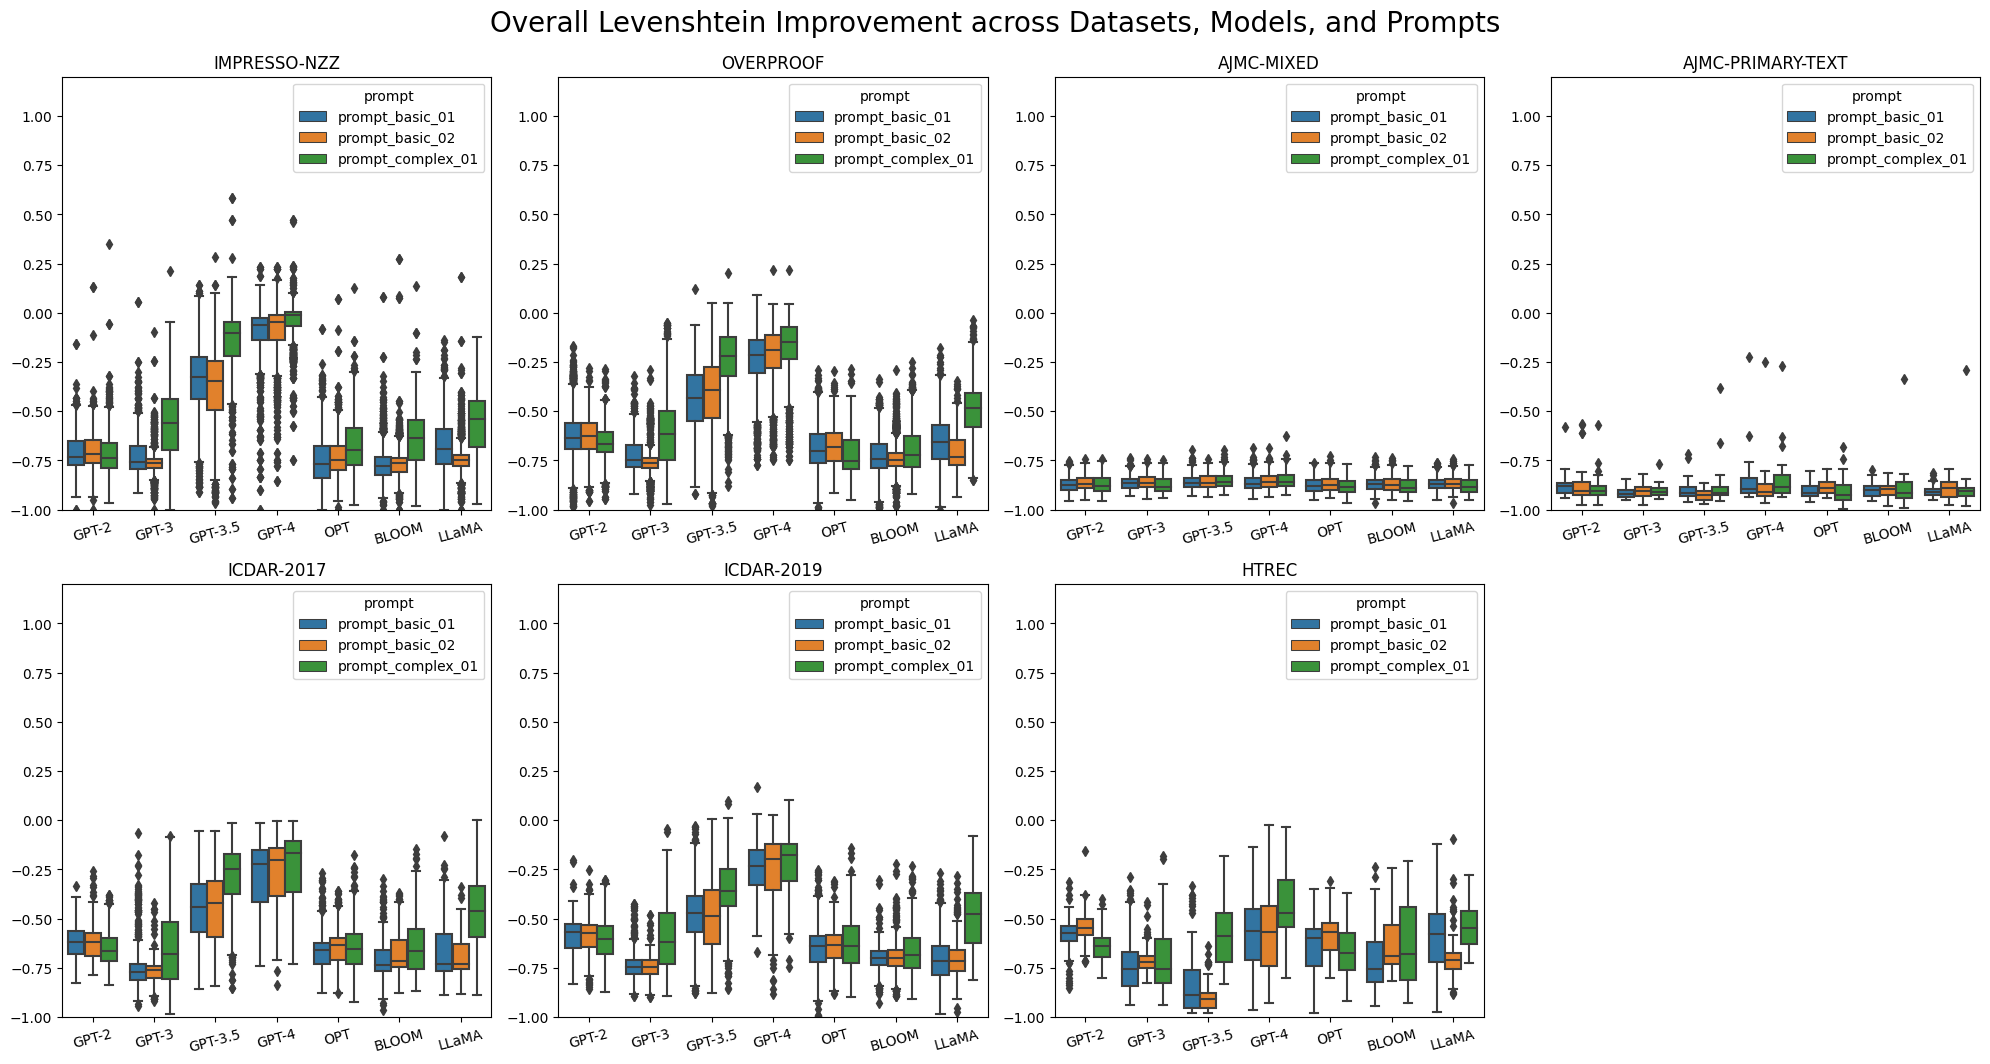

In [614]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Define OCR noise level bins
bins = [0, 0.4, 0.6, 0.8, 0.99, 1.0]

# Assign OCR noise level labels
labels = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# Count the number of unique datasets
n_datasets = data.dataset_name.nunique()
dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
                 'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec']

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']
prompt_names = ['prompt_basic_01', 'prompt_basic_02', 'prompt_complex_01']

for error_rate in ['lev']:
    # Create subplots
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))

    # Flatten the axes for easy iteration
    axs = axs.flatten()

    for i, dataset in enumerate(dataset_names):
        dataset_data = data[data.dataset_name == dataset]
        
        # Compute the mean WER across line, sentence, and region levels
        dataset_data[f'Overall Levenshtein Improvement'] = dataset_data[[f'line-{error_rate}-improvement', 
                                                          f'sentence-{error_rate}-improvement', 
                                                          f'region-{error_rate}-improvement']].mean(axis=1)

        # Plot the distribution of improvements for each model
        _ = sns.boxplot(x='model', y=f'Overall Levenshtein Improvement', data=dataset_data, 
                    ax=axs[i], order=model_names, hue='prompt', hue_order=prompt_names)
        
        axs[i].set_title(f'{dataset.upper()}')

        axs[i].set_ylim([-1, 1.2])
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=15)  # Rotate x-axis labels
        axs[i].set_xlabel('')  # Remove x-axis label
        axs[i].set_ylabel('')  # Remove y-axis label
        

    # Remove empty subplots
    for i in range(len(data.dataset_name.unique()), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.suptitle('Overall Levenshtein Improvement across Datasets, Models, and Prompts', fontsize=20, y=1.02)
    plt.show()


In [169]:
lev_improvement_summary = data.groupby(['dataset_name', 'model'])[['line-lev-improvement', 
                                                                   'sentence-lev-improvement', 
                                                                   'region-lev-improvement']].mean().reset_index()
# Compute the minimum and maximum Lev improvements for each dataset and model
min_lev_improvements = data.groupby(['dataset_name', 'model'])[['line-lev-improvement', 
                                                                   'sentence-lev-improvement', 
                                                                   'region-lev-improvement']].min().unstack()
max_lev_improvements = data.groupby(['dataset_name', 'model'])[['line-lev-improvement', 
                                                                   'sentence-lev-improvement', 
                                                                   'region-lev-improvement']].max().unstack()

# Create a new column for the average improvement across all segment types
lev_improvement_summary['Average Lev Improvement'] = lev_improvement_summary[['line-lev-improvement', 'sentence-lev-improvement', 'region-lev-improvement']].mean(axis=1)

# Combine the mean, min, and max improvements into one DataFrame
lev_improvements = pd.concat([lev_improvement_summary, min_lev_improvements, max_lev_improvements], 
                             keys=['Mean', 'Min', 'Max'])

# Convert the DataFrame to a LaTeX table
latex_table = lev_improvements.to_latex()

print(latex_table)

lev_improvement_summary.head()


\begin{tabular}{llllrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
 &  & dataset_name & model & line-lev-improvement & sentence-lev-improvement & region-lev-improvement & Average Lev Improvement & ('line-lev-improvement', 'BLOOM') & ('line-lev-improvement', 'GPT-2') & ('line-lev-improvement', 'GPT-3') & ('line-lev-improvement', 'GPT-3.5') & ('line-lev-improvement', 'GPT-4') & ('line-lev-improvement', 'LLaMA') & ('line-lev-improvement', 'OPT') & ('sentence-lev-improvement', 'BLOOM') & ('sentence-lev-improvement', 'GPT-2') & ('sentence-lev-improvement', 'GPT-3') & ('sentence-lev-improvement', 'GPT-3.5') & ('sentence-lev-improvement', 'GPT-4') & ('sentence-lev-improvement', 'LLaMA') & ('sentence-lev-improvement', 'OPT') & ('region-lev-improvement', 'BLOOM') & ('region-lev-improvement', 'GPT-2') & ('region-lev-improvement', 'GPT-3') & ('region-lev-improvement', 'GPT-3.5') & ('region-lev-improvement', 'GPT-4') & ('region-lev-improvement', 'LLaMA') & ('region-lev-improvement', 'OPT') \\
\midrule
\multi

dataset_name    model  line-lev-improvement  sentence-lev-improvement   
0   ajmc-mixed    BLOOM             -0.558859                 -0.848297  \
1   ajmc-mixed    GPT-2             -0.567063                 -0.860157   
2   ajmc-mixed    GPT-3             -0.533565                 -0.828334   
3   ajmc-mixed  GPT-3.5             -0.269794                 -0.494359   
4   ajmc-mixed    GPT-4             -0.021850                  0.170432   

   region-lev-improvement  Average Lev Improvement  
0               -0.723678                -0.710278  
1               -0.556410                -0.661210  
2               -0.761872                -0.707924  
3               -0.448664                -0.404272  
4               -0.263646                -0.038355

In [166]:
# Pivot the data so that models become columns and datasets become rows
lev_improvement_pivot = lev_improvement_summary.pivot(index='dataset_name', columns='model', values='Average Lev Improvement')

# Reset the index to make 'dataset_name' a regular column
lev_improvement_pivot.reset_index(inplace=True)

# Convert the DataFrame to LaTeX and print it
print(lev_improvement_pivot.to_latex(index=False))


\begin{tabular}{lrrrrrrr}
\toprule
dataset_name & BLOOM & GPT-2 & GPT-3 & GPT-3.5 & GPT-4 & LLaMA & OPT \\
\midrule
ajmc-mixed & -0.710278 & -0.661210 & -0.707924 & -0.404272 & -0.038355 & -0.640942 & -0.687007 \\
ajmc-primary-text & -0.734370 & -0.664632 & -0.751972 & -0.619772 & -0.395059 & -0.701126 & -0.695704 \\
htrec & -0.660727 & -0.590733 & -0.716931 & -0.772357 & -0.525468 & -0.643260 & -0.636062 \\
icdar-2017 & -0.683670 & -0.631638 & -0.695213 & -0.337631 & -0.206612 & -0.686427 & -0.651431 \\
icdar-2019 & -0.687748 & -0.595882 & -0.665828 & -0.433071 & -0.225168 & -0.701638 & -0.638599 \\
impresso-nzz & -0.719431 & -0.714780 & -0.684973 & -0.282295 & -0.046019 & -0.674834 & -0.718923 \\
overproof & -0.722150 & -0.629751 & -0.744815 & -0.424020 & -0.184036 & -0.651134 & -0.697797 \\
\bottomrule
\end{tabular}



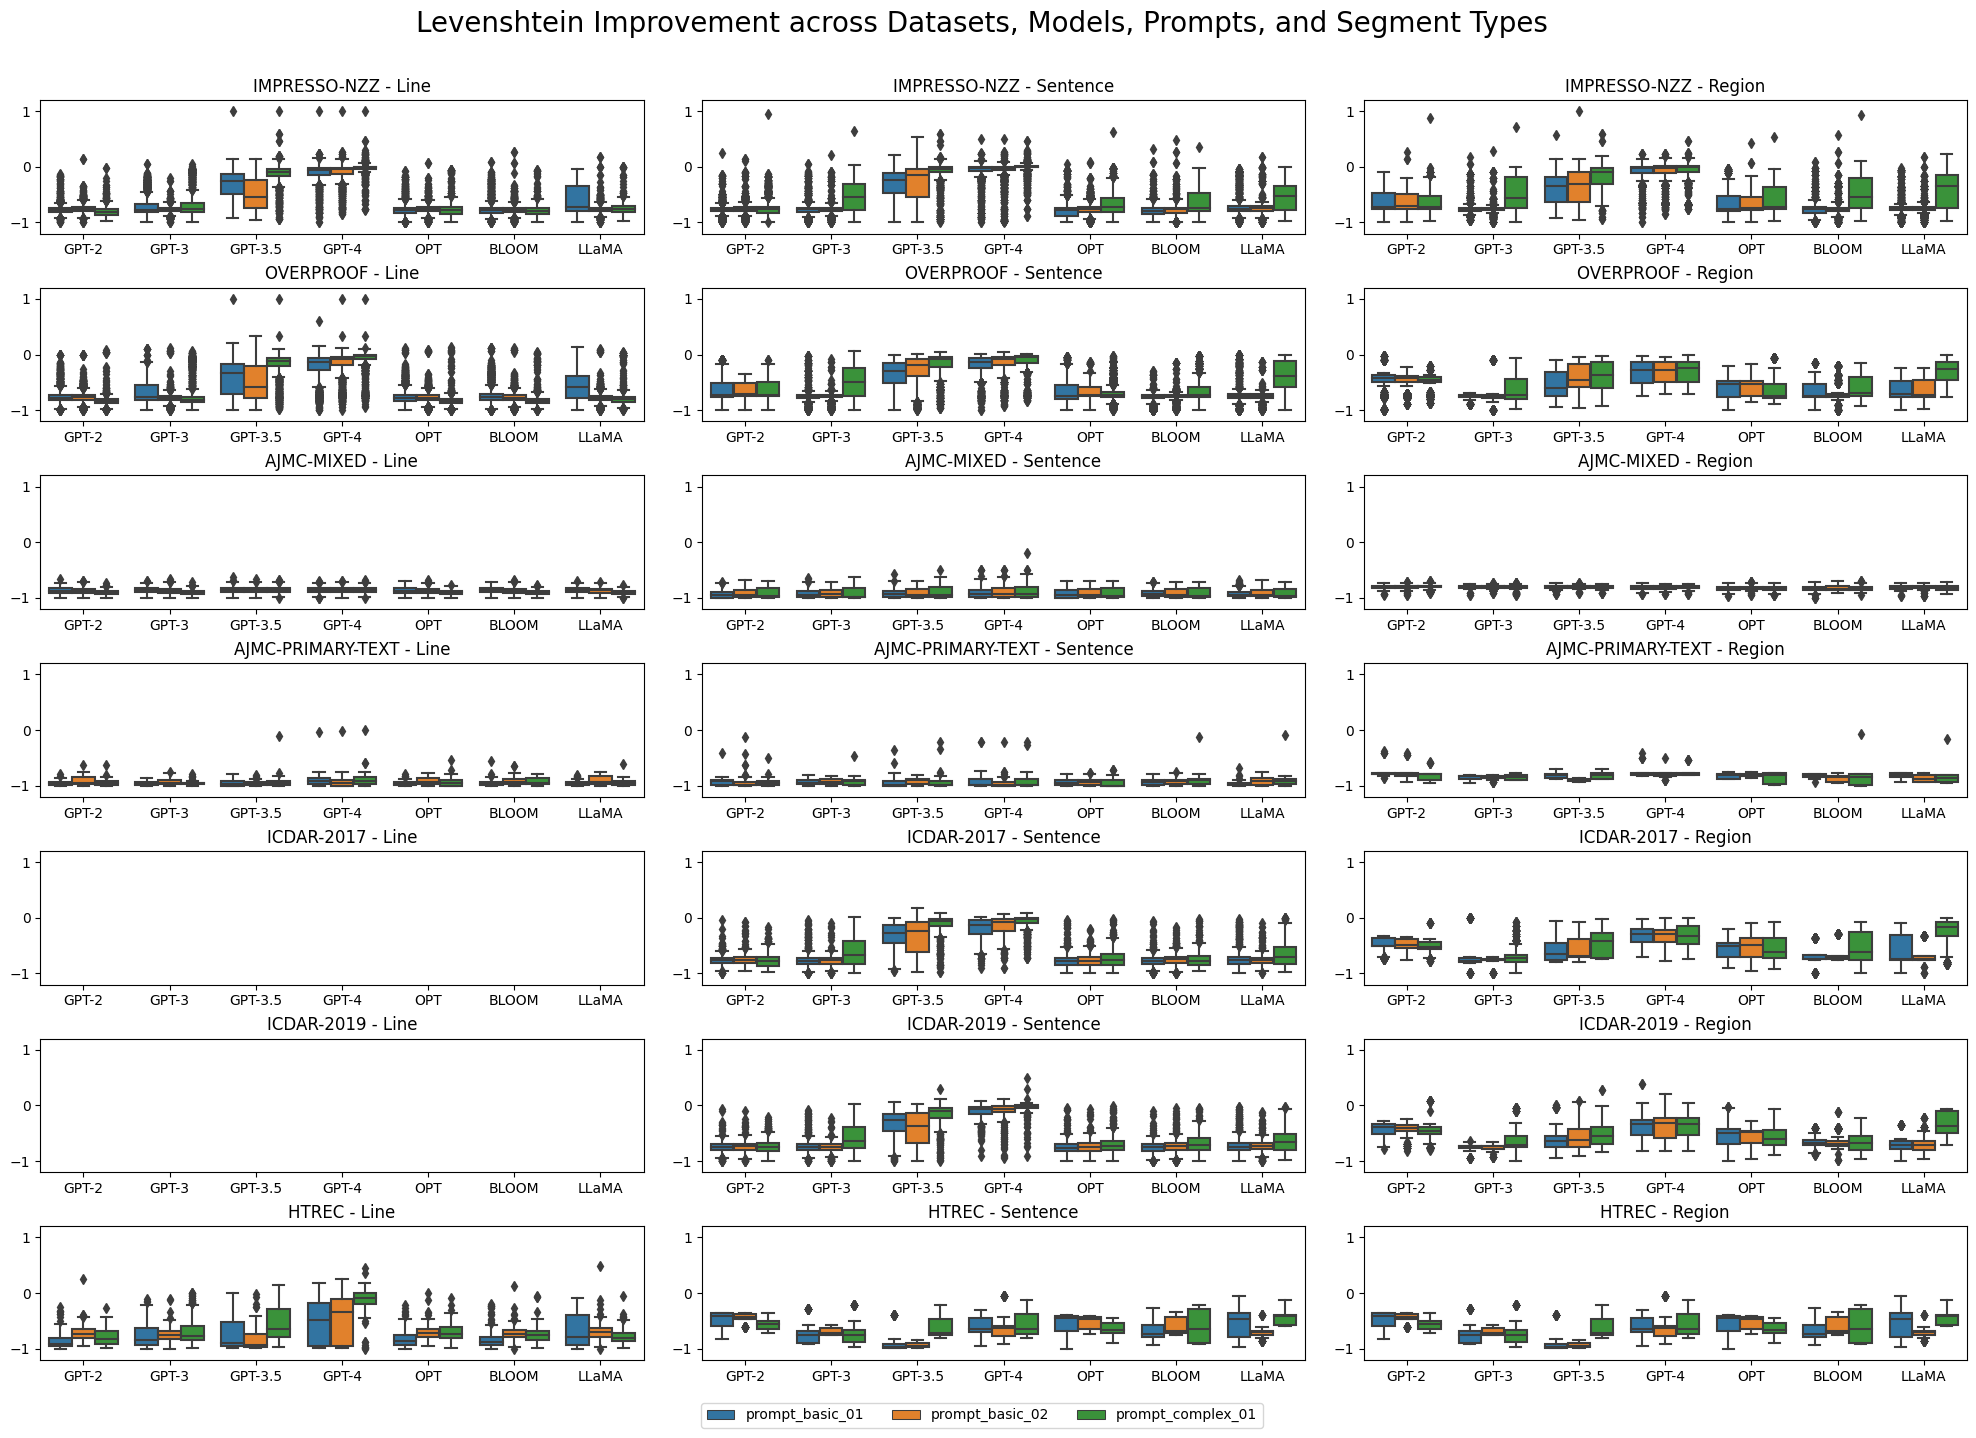

In [615]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Define OCR noise level bins
# bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# bins = [0, 0.7, 0.8, 0.9, 1.0]

# Assign OCR noise level labels
# labels = ["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
# labels = ["0-70%", "70-80%", "80-90%", "90-100%"]

bins = [0, 0.4, 0.6, 0.8, 0.99, 1.0]
labels = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# Count the number of unique datasets
n_datasets = data.dataset_name.nunique()
dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
                 'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec']

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']
prompt_names = ['prompt_basic_01', 'prompt_basic_02', 'prompt_complex_01']
segment_types = ['line', 'sentence', 'region']

for error_rate in ['lev']:
    # Create subplots
    fig, axs = plt.subplots(n_datasets, len(segment_types), figsize=(20, 15))

    for i, dataset in enumerate(dataset_names):
        dataset_data = data[data.dataset_name == dataset]

        for j, segment_type in enumerate(segment_types):
            # Compute the segment type lev improvement
            dataset_data[f'{segment_type.capitalize()} Levenshtein Improvement'] = dataset_data[f'{segment_type}-{error_rate}-improvement']

            # Plot the distribution of improvements for each model
            _ = sns.boxplot(x='model', y=f'{segment_type.capitalize()} Levenshtein Improvement', data=dataset_data, 
                        ax=axs[i, j], order=model_names, hue='prompt', hue_order=prompt_names)

            axs[i, j].set_title(f'{dataset.upper()} - {segment_type.capitalize()}')
#             axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=15)  # Rotate x-axis labels
            axs[i, j].set_xlabel('')  # Remove x-axis label
            axs[i, j].set_ylabel('')  # Remove y-axis label
            
            axs[i, j].set_ylim([-1.2, 1.2])
            # Remove the legend for all but the last subplot
            if i < n_datasets - 1 or j < len(segment_types):
                axs[i, j].legend().set_visible(False)

    # Add a legend outside of the plot area of the last subplot
    handles, labels = axs[-1, -1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=len(handles))

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08)  # Adjust the overall layout
    plt.suptitle('Levenshtein Improvement across Datasets, Models, Prompts, and Segment Types', fontsize=20)
    plt.show()

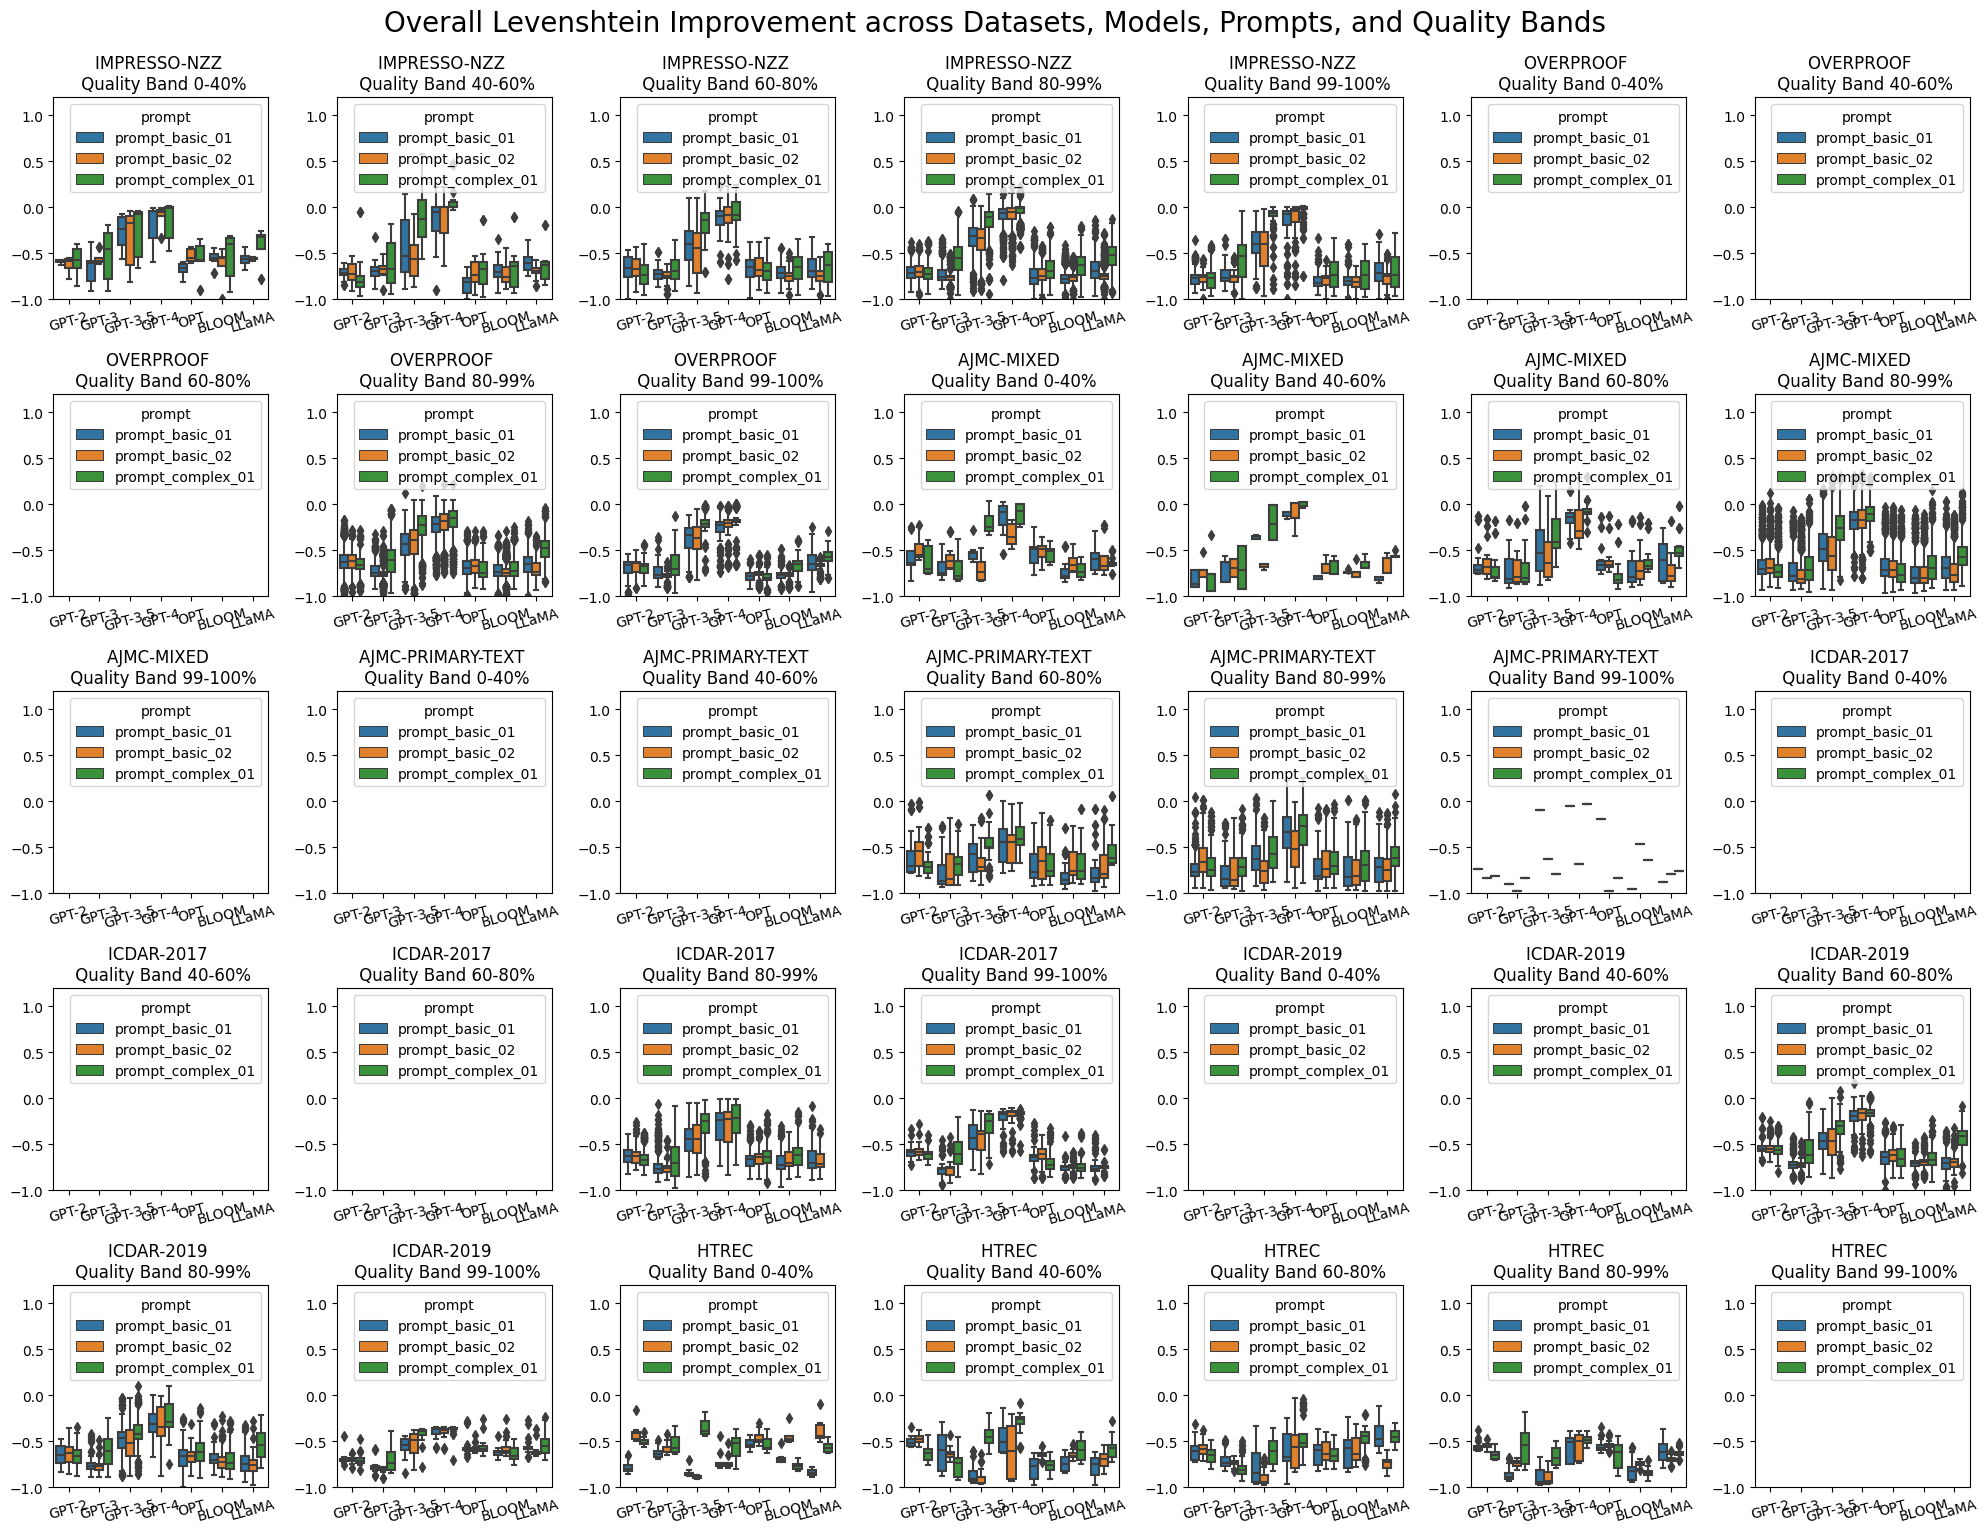

In [373]:
# Define a list of quality bands
bins = [0, 0.4, 0.6, 0.8, 0.99, 1.0]
quality_bands = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# Create a figure and axes for subplots
fig, axs = plt.subplots(len(quality_bands), len(dataset_names), figsize=(20, 15))

# Flatten the axes for easy iteration
axs = axs.flatten()

# Create a counter
i = 0

# Iterate over all datasets
for dataset in dataset_names:
    dataset_data = data[data.dataset_name == dataset]

    # Iterate over all quality bands
    for band in quality_bands:
        # Filter data based on dataset and quality band
        subset = dataset_data[dataset_data['Quality Band'] == band]

        # Compute the mean Levenshtein Improvement across line, sentence, and region levels
        subset[f'Overall Levenshtein Improvement'] = subset[[f'line-lev-improvement', 
                                                          f'sentence-lev-improvement', 
                                                          f'region-lev-improvement']].mean(axis=1)

        # Plot the distribution of improvements for each model
        _ = sns.boxplot(x='model', y=f'Overall Levenshtein Improvement', data=subset, 
                    ax=axs[i], order=model_names, hue='prompt', hue_order=prompt_names)
        
        axs[i].set_title(f'{dataset.upper()} \n Quality Band {band}')

        axs[i].set_ylim([-1, 1.2])
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=15)  # Rotate x-axis labels
        axs[i].set_xlabel('')  # Remove x-axis label
        axs[i].set_ylabel('')  # Remove y-axis label
        
        i += 1

# Remove empty subplots
for j in range(i, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle('Overall Levenshtein Improvement across Datasets, Models, Prompts, and Quality Bands', fontsize=20, y=1.02)
plt.show()


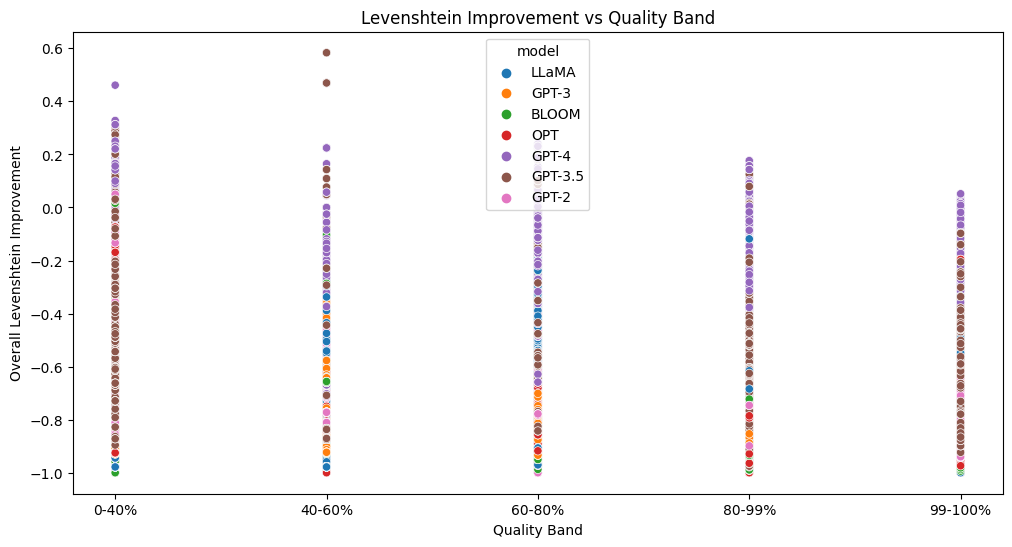

In [375]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a mapping from quality bands to numeric values
quality_band_mapping = {"0-40%": 1, "40-60%": 2, "60-80%": 3, "80-99%": 4, "99-100%": 5}

# Create a numeric quality band column based on the defined bins and labels
data["Quality Band"] = pd.cut(data['line-lev-ocr'], bins=[0, 0.4, 0.6, 0.8, 0.99, 1], labels=quality_band_mapping.keys())

# Add a numeric quality band column to the data
data["Numeric Quality Band"] = data["Quality Band"].map(quality_band_mapping)

# Compute the mean Levenshtein Improvement across line, sentence, and region levels
data['Overall Levenshtein Improvement'] = data[[f'line-lev-improvement', 
                                              f'sentence-lev-improvement', 
                                              f'region-lev-improvement']].mean(axis=1)

plt.figure(figsize=(12, 6))

# Generate scatter plot
sns.scatterplot(data=data, x='Numeric Quality Band', y='Overall Levenshtein Improvement', hue='model')

# Improve readability
plt.xticks(ticks=range(1, 6), labels=quality_band_mapping.keys())
plt.xlabel('Quality Band')
plt.ylabel('Overall Levenshtein Improvement')
plt.title('Levenshtein Improvement vs Quality Band')
plt.show()


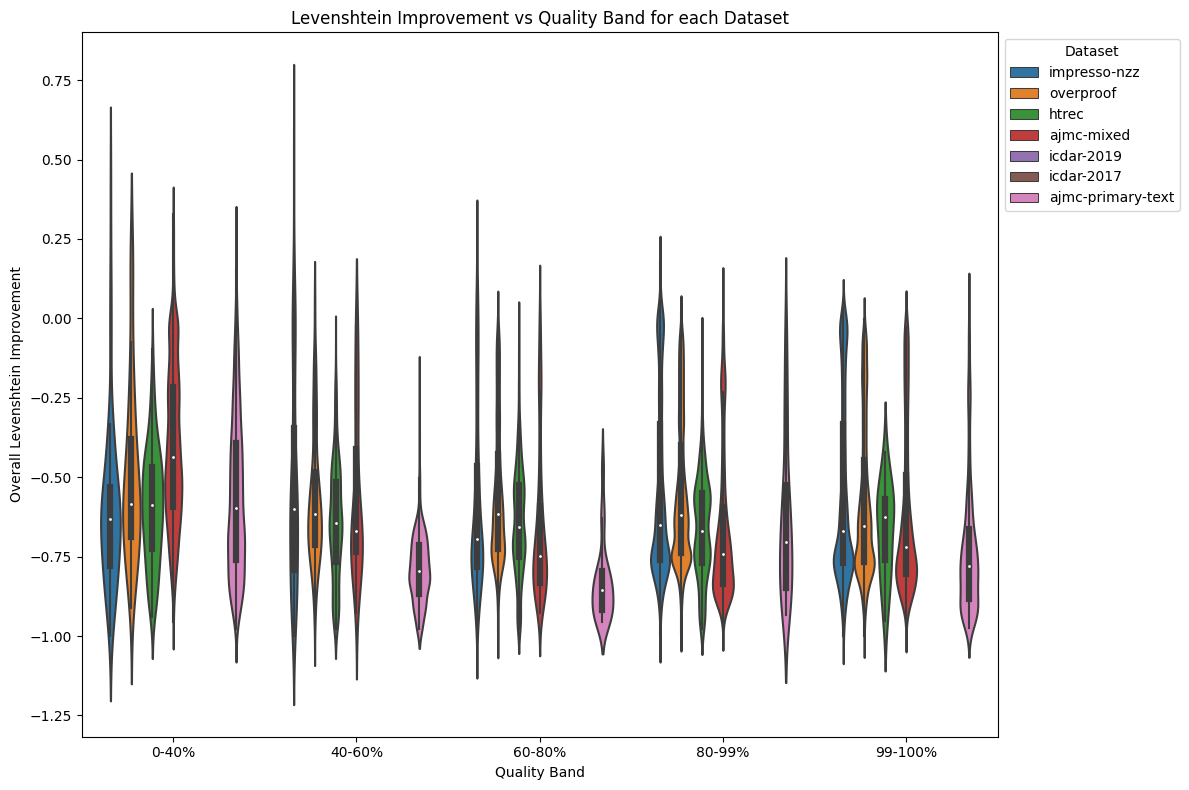

In [376]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the mean Levenshtein Improvement across line, sentence, and region levels
data['Overall Levenshtein Improvement'] = data[[f'line-lev-improvement', 
                                              f'sentence-lev-improvement', 
                                              f'region-lev-improvement']].mean(axis=1)

plt.figure(figsize=(12, 8))

# Generate violin plot
sns.violinplot(data=data, x='Quality Band', y='Overall Levenshtein Improvement', hue='dataset_name')

# Improve readability
plt.xlabel('Quality Band')
plt.ylabel('Overall Levenshtein Improvement')
plt.title('Levenshtein Improvement vs Quality Band for each Dataset')
plt.legend(title='Dataset', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [368]:
lev_improvement_threshold = 0.0

dataset = data[data.dataset_name == 'icdar-2017']

segment_type = 'sentence'
for error_rate in ['lev']:
    interesting_cases = dataset[dataset[f'{segment_type}-{error_rate}-improvement'] > lev_improvement_threshold]
    
    for _, interesting_cases in interesting_cases.iterrows():
        print('Segment type:', segment_type)
        print('Model:', interesting_cases['model'])
        print('Dataset:', interesting_cases['dataset_name'])
        print('Quality Band:', interesting_cases[f'Quality Band'])

        print('LEV ground-ocr', interesting_cases[f'{segment_type}-lev-ocr'], 
              'LEV ground-pred', interesting_cases[f'{segment_type}-lev-pred'])
        print('LEV Improvement:', interesting_cases[f'{segment_type}-lev-improvement'])

        print('Ground:', interesting_cases[f'groundtruth.{segment_type}'][:50])
        print('OCR:', interesting_cases[f'ocr.{segment_type}'][:50])
        print('Pred:', interesting_cases[f'prediction.{segment_type}'])
        print('--'*50)


Segment type: sentence
Model: GPT-4
Dataset: icdar-2017
Quality Band: 99-100%
LEV ground-ocr 0.9830508474576272 LEV ground-pred 0.9915254237288136
LEV Improvement: 0.008620689655172391
Ground: XXXV Cette crise fut plus longue que ceile qui ava
OCR: XXXV Cette crise fut plus longue que cede qui avai
Pred: XXXV Cette crise fut plus longue que celle qui avait précédé, et il y eut un moment où le médecin désespéra du succès.
----------------------------------------------------------------------------------------------------
Segment type: sentence
Model: GPT-4
Dataset: icdar-2017
Quality Band: 99-100%
LEV ground-ocr 0.967741935483871 LEV ground-pred 1.0
LEV Improvement: 0.033333333333333305
Ground: Vous me demandez si je l'aime!
OCR: Vous me demandez si je l'aime !
Pred: Vous me demandez si je l'aime!
----------------------------------------------------------------------------------------------------
Segment type: sentence
Model: GPT-4
Dataset: icdar-2017
Quality Band: 80-99%
LEV ground-ocr

In [363]:
dataset

filename dataset_name ocr.line   
0    ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text  \
1    ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   
2    ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   
3    ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   
4    ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   
..                                                 ...          ...      ...   
472  ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   
473  ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   
474  ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   
475  ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   
476  ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   

                                          ocr.sentence   
0    studies have found the secrets of the starres ...  \
1    I likewisehave found out the secrets of trees,...   
2    What hath all my knowledge of natures secrets ...   
3    Onely this, the losse of a better knowledge, t...   
4           I have found, that my knowledge has beene.   
..                                                 ...   
472  Then within a while after the Priour came unto...   
473  Anon he said unto him, what dost thou here, an...   
474  The young man with great reverence answered an...   
475  And sir if it please you to have me, I shall d...   
476    And when the Priour had heard his words, he was   

                                            ocr.region groundtruth.line   
0    OF FRYER BACON. 249 my studies have found the ...          No text  \
1    OF FRYER BACON. 249 my studies have found the ...          No text   
2    OF FRYER BACON. 249 my studies have found the ...          No text   
3    OF FRYER BACON. 249 my studies have found the ...          No text   
4    OF FRYER BACON. 249 my studies have found the ...          No text   
..                                                 ...              ...   
472  264 A PLEASANT HISTORIE good and well disposed...          No text   
473  264 A PLEASANT HISTORIE good and well disposed...          No text   
474  264 A PLEASANT HISTORIE good and well disposed...          No text   
475  264 A PLEASANT HISTORIE good and well disposed...          No text   
476  264 A PLEASANT HISTORIE good and well disposed...          No text   

                                  groundtruth.sentence   
0    OF FRYER BACON. 249 my studies have found the ...  \
1    I Hkewisehave found out the secrets of trees, ...   
2    What hath all my knowledge of natures secrets ...   
3    Onely this, the losse of a better knowledge, t...   
4           I have found, that my knowledge has beene.   
..                                                 ...   
472  Then within a while after the Priour came unto...   
473  Anon he said unto him, what dost thou here, an...   
474  The young man with great reverence answered an...   
475  And sir if it please you to have me, I shall d...   
476    And when the Priour had heard his words, he was   

                                    groundtruth.region   
0    studies have found the secrets of the starres ...  \
1    studies have found the secrets of the starres ...   
2    studies have found the secrets of the starres ...   
3    studies have found the secrets of the starres ...   
4    studies have found the secrets of the starres ...   
..                                                 ...   
472  and well disposed people, they spent in unthri...   
473  and well disposed people, they spent in unthri...   
474  and well disposed people, they spent in unthri...   
475  and well disposed people, they spent in unthri...   
476  and well disposed people, they spent in unthri...   

                                     prediction.prompt prediction.line  ...   
0    Correct t

In [22]:
dataset[f'sentence-lev-improvement']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
472   NaN
473   NaN
474   NaN
475   NaN
476   NaN
Name: line-lev-improvement, Length: 8475, dtype: float64

In [391]:
data.dataset_name.unique()

array(['impresso-nzz', 'overproof', 'htrec', 'ajmc-mixed', 'icdar-2019',
       'icdar-2017', 'ajmc-primary-text'], dtype=object)

In [392]:
data.model.unique()

array(['GPT-4', 'GPT-3.5', 'GPT-2', 'OPT', 'BLOOM', 'LLaMA', 'GPT-3'],
      dtype=object)

### ICDAR

In [544]:
icdar_2017 = data[data.dataset_name == 'icdar-2017']

def get_document_type(filename):
    document_type = filename.split('/')[-2].replace('_', '-')
    return document_type

icdar_2017['document_type'] = icdar_2017['filename'].apply(lambda x: get_document_type(x))

icdar_2017.head()

filename dataset_name ocr.line   
0  ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text  \
1  ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   
2  ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   
3  ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   
4  ../../data/datasets/ocr/original/icdar-2017/IC...   icdar-2017  No text   

                                        ocr.sentence   
0  studies have found the secrets of the starres ...  \
1  I likewisehave found out the secrets of trees,...   
2  What hath all my knowledge of natures secrets ...   
3  Onely this, the losse of a better knowledge, t...   
4         I have found, that my knowledge has beene.   

                                          ocr.region groundtruth.line   
0  OF FRYER BACON. 249 my studies have found the ...          No text  \
1  OF FRYER BACON. 249 my studies have found the ...          No text   
2  OF FRYER BACON. 249 my studies have found the ...          No text   
3  OF FRYER BACON. 249 my studies have found the ...          No text   
4  OF FRYER BACON. 249 my studies have found the ...          No text   

                                groundtruth.sentence   
0  OF FRYER BACON. 249 my studies have found the ...  \
1  I Hkewisehave found out the secrets of trees, ...   
2  What hath all my knowledge of natures secrets ...   
3  Onely this, the losse of a better knowledge, t...   
4         I have found, that my knowledge has beene.   

                                  groundtruth.region   
0  studies have found the secrets of the starres ...  \
1  studies have found the secrets of the starres ...   
2  studies have found the secrets of the starres ...   
3  studies have found the secrets of the starres ...   
4  studies have found the secrets of the starres ...   

                                   prediction.prompt prediction.line  ...   
0  Correct the spelling and grammar of the follow...             NaN  ...  \
1  Correct the spelling and grammar of the follow...             NaN  ...   
2  Correct the spelling and grammar of the follow...             NaN  ...   
3  Correct the spelling and grammar of the follow...             NaN  ...   
4  Correct the spelling and grammar of the follow...             NaN  ...   

  region-wer-improvement region-ocr-noise-group article_id century   
0               0.015914                90-100%        NaN     NaN  \
1               0.015914                90-100%        NaN     NaN   
2               0.015914                90-100%        NaN     NaN   
3               0.015914                90-100%        NaN     NaN   
4               0.015914                90-100%        NaN     NaN   

                                      language                  File  Date   
0  icdar2017_datasetpostocr_evaluation_2m_v1.2  eng_monograph/27.txt  1858  \
1  icdar2017_datasetpostocr_evaluation_2m_v1.2  eng_monograph/27.txt  1858   
2  icdar2017_datasetpostocr_evaluation_2m_v1.2  eng_monograph/27.txt  1858   
3  icdar2017_datasetpostocr_evaluation_2m_v1.2  eng_monograph/27.txt  1858   
4  icdar2017_datasetpostocr_evaluation_2m_v1.2  eng_monograph/27.txt  1858   

        Type  NbAlignedChar  document_type  
0  monograph           1525  eng-monograph  
1  monograph           1525  eng-monograph  
2  monograph           1525  eng-monograph  
3  monograph           1525  eng-monograph  
4  monograph           1525  eng-monograph  

[5 rows x 53 columns]

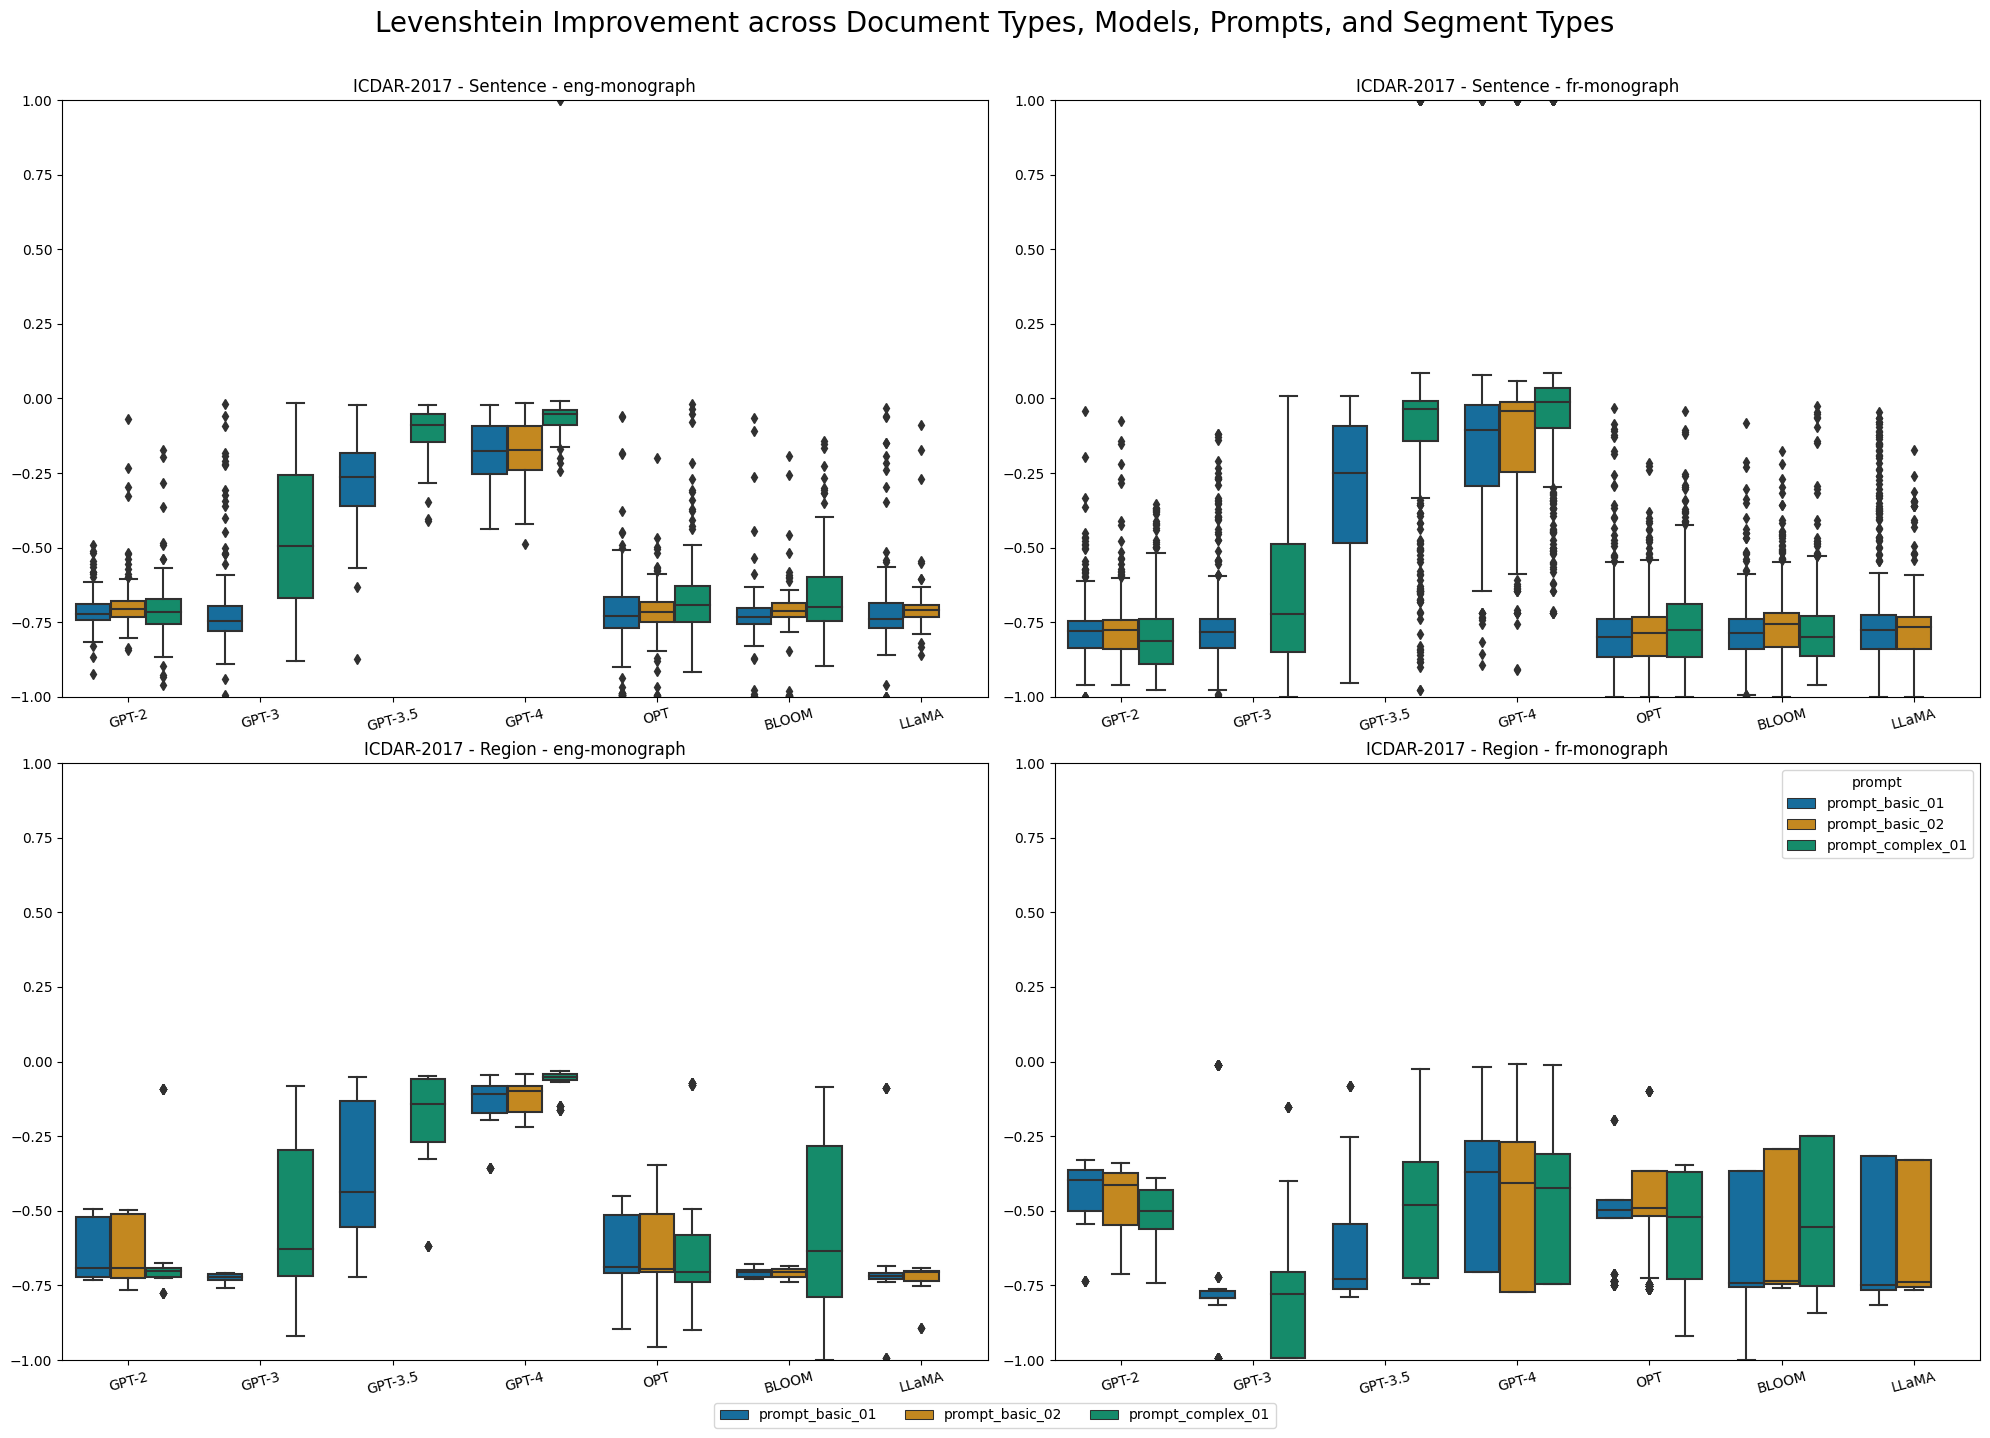

In [550]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Get the first dataset name
dataset_name = 'ICDAR-2017'

dataset_data = icdar_2017

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']
prompt_names = ['prompt_basic_01', 'prompt_basic_02', 'prompt_complex_01']
segment_types = ['sentence', 'region']
document_types = dataset_data['document_type'].unique()  # Get the unique document types

for error_rate in ['lev']:
    # Create subplots
    fig, axs = plt.subplots(len(segment_types), len(document_types), figsize=(20, 15))

    for i, segment_type in enumerate(segment_types):
        for j, document_type in enumerate(document_types):
            # Select data for the current document type
            document_data = dataset_data[dataset_data.document_type == document_type]

            # Compute the segment type lev improvement
            document_data[f'{segment_type.capitalize()} Levenshtein Improvement'] = document_data[f'{segment_type}-{error_rate}-improvement']

            # Plot the distribution of improvements for each model
            _ = sns.boxplot(x='model', y=f'{segment_type.capitalize()} Levenshtein Improvement', data=document_data, 
                        ax=axs[i, j], order=model_names, hue='prompt', hue_order=prompt_names)

            axs[i, j].set_title(f'{dataset_name.upper()} - {segment_type.capitalize()} - {document_type}')
            axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=15)  # Rotate x-axis labels
            axs[i, j].set_xlabel('')  # Remove x-axis label
            axs[i, j].set_ylabel('')  # Remove y-axis label
            axs[i, j].set_ylim([-1, 1])  # Set y-axis limits

            # Remove the legend for all but the last subplot
            if i < len(segment_types) - 1 or j < len(document_types) - 1:
                axs[i, j].legend().set_visible(False)

    # Add a legend outside of the plot area of the last subplot
    handles, labels = axs[-1, -1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=len(handles))

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08)  # Adjust the overall layout
    plt.suptitle('Levenshtein Improvement across Document Types, Models, Prompts, and Segment Types', fontsize=20)
    plt.show()


In [559]:
icdar_2019 = data[data.dataset_name == 'icdar-2019']

def get_document_type(filename):
    document_type = filename.split('/')[-3]
    return document_type

icdar_2019['document_type'] = icdar_2019['filename'].apply(lambda x: get_document_type(x))

icdar_2019.head()

filename dataset_name ocr.line   
0  ../../data/datasets/ocr/original/icdar-2019/IC...   icdar-2019  No text  \
1  ../../data/datasets/ocr/original/icdar-2019/IC...   icdar-2019  No text   
2  ../../data/datasets/ocr/original/icdar-2019/IC...   icdar-2019  No text   
3  ../../data/datasets/ocr/original/icdar-2019/IC...   icdar-2019  No text   
4  ../../data/datasets/ocr/original/icdar-2019/IC...   icdar-2019  No text   

                                        ocr.sentence   
0                Charles, par la grace de Dieu, etc.  \
1  Savoir faisons à touz, presens et avenir, à no...   
2  Et avant que le dit Amelin peust sur ce remedi...   
3                                    linceulz et ii.   
4  couvertes, et d’ilecques s’en alerent là où bo...   

                                          ocr.region groundtruth.line   
0  Charles, par la grace de Dieu, etc. Savoir fai...          No text  \
1  Charles, par la grace de Dieu, etc. Savoir fai...          No text   
2  Charles, par la grace de Dieu, etc. Savoir fai...          No text   
3  Charles, par la grace de Dieu, etc. Savoir fai...          No text   
4  Charles, par la grace de Dieu, etc. Savoir fai...          No text   

                                groundtruth.sentence   
0                Charles, par la grace de Dieu, etc.  \
1  Savoir faisons à touz, presens et avenir, à no...   
2  et avant que le dit Amelin peust sur ce remedi...   
3                                      linceulz et n   
4  convertes, et d'ilecques s'en alerent là où bo...   

                                  groundtruth.region   
0  Charles, par la grace de Dieu, etc. Savoir fai...  \
1  Charles, par la grace de Dieu, etc. Savoir fai...   
2  Charles, par la grace de Dieu, etc. Savoir fai...   
3  Charles, par la grace de Dieu, etc. Savoir fai...   
4  Charles, par la grace de Dieu, etc. Savoir fai...   

                                   prediction.prompt prediction.line  ...   
0  Correct the spelling and grammar of the follow...             NaN  ...  \
1  Correct the spelling and grammar of the follow...             NaN  ...   
2  Correct the spelling and grammar of the follow...             NaN  ...   
3  Correct the spelling and grammar of the follow...             NaN  ...   
4  Correct the spelling and grammar of the follow...             NaN  ...   

  region-wer-improvement region-ocr-noise-group article_id century  language   
0               0.097473                90-100%        NaN     NaN        fr  \
1               0.097473                90-100%        NaN     NaN        fr   
2               0.097473                90-100%        NaN     NaN        fr   
3               0.097473                90-100%        NaN     NaN        fr   
4               0.097473                90-100%        NaN     NaN        fr   

   File  Date  Type  NbAlignedChar  document_type  
0   NaN   NaN   NaN            NaN             FR  
1   NaN   NaN   NaN            NaN             FR  
2   NaN   NaN   NaN            NaN             FR  
3   NaN   NaN   NaN            NaN             FR  
4   NaN   NaN   NaN            NaN             FR  

[5 rows x 53 columns]

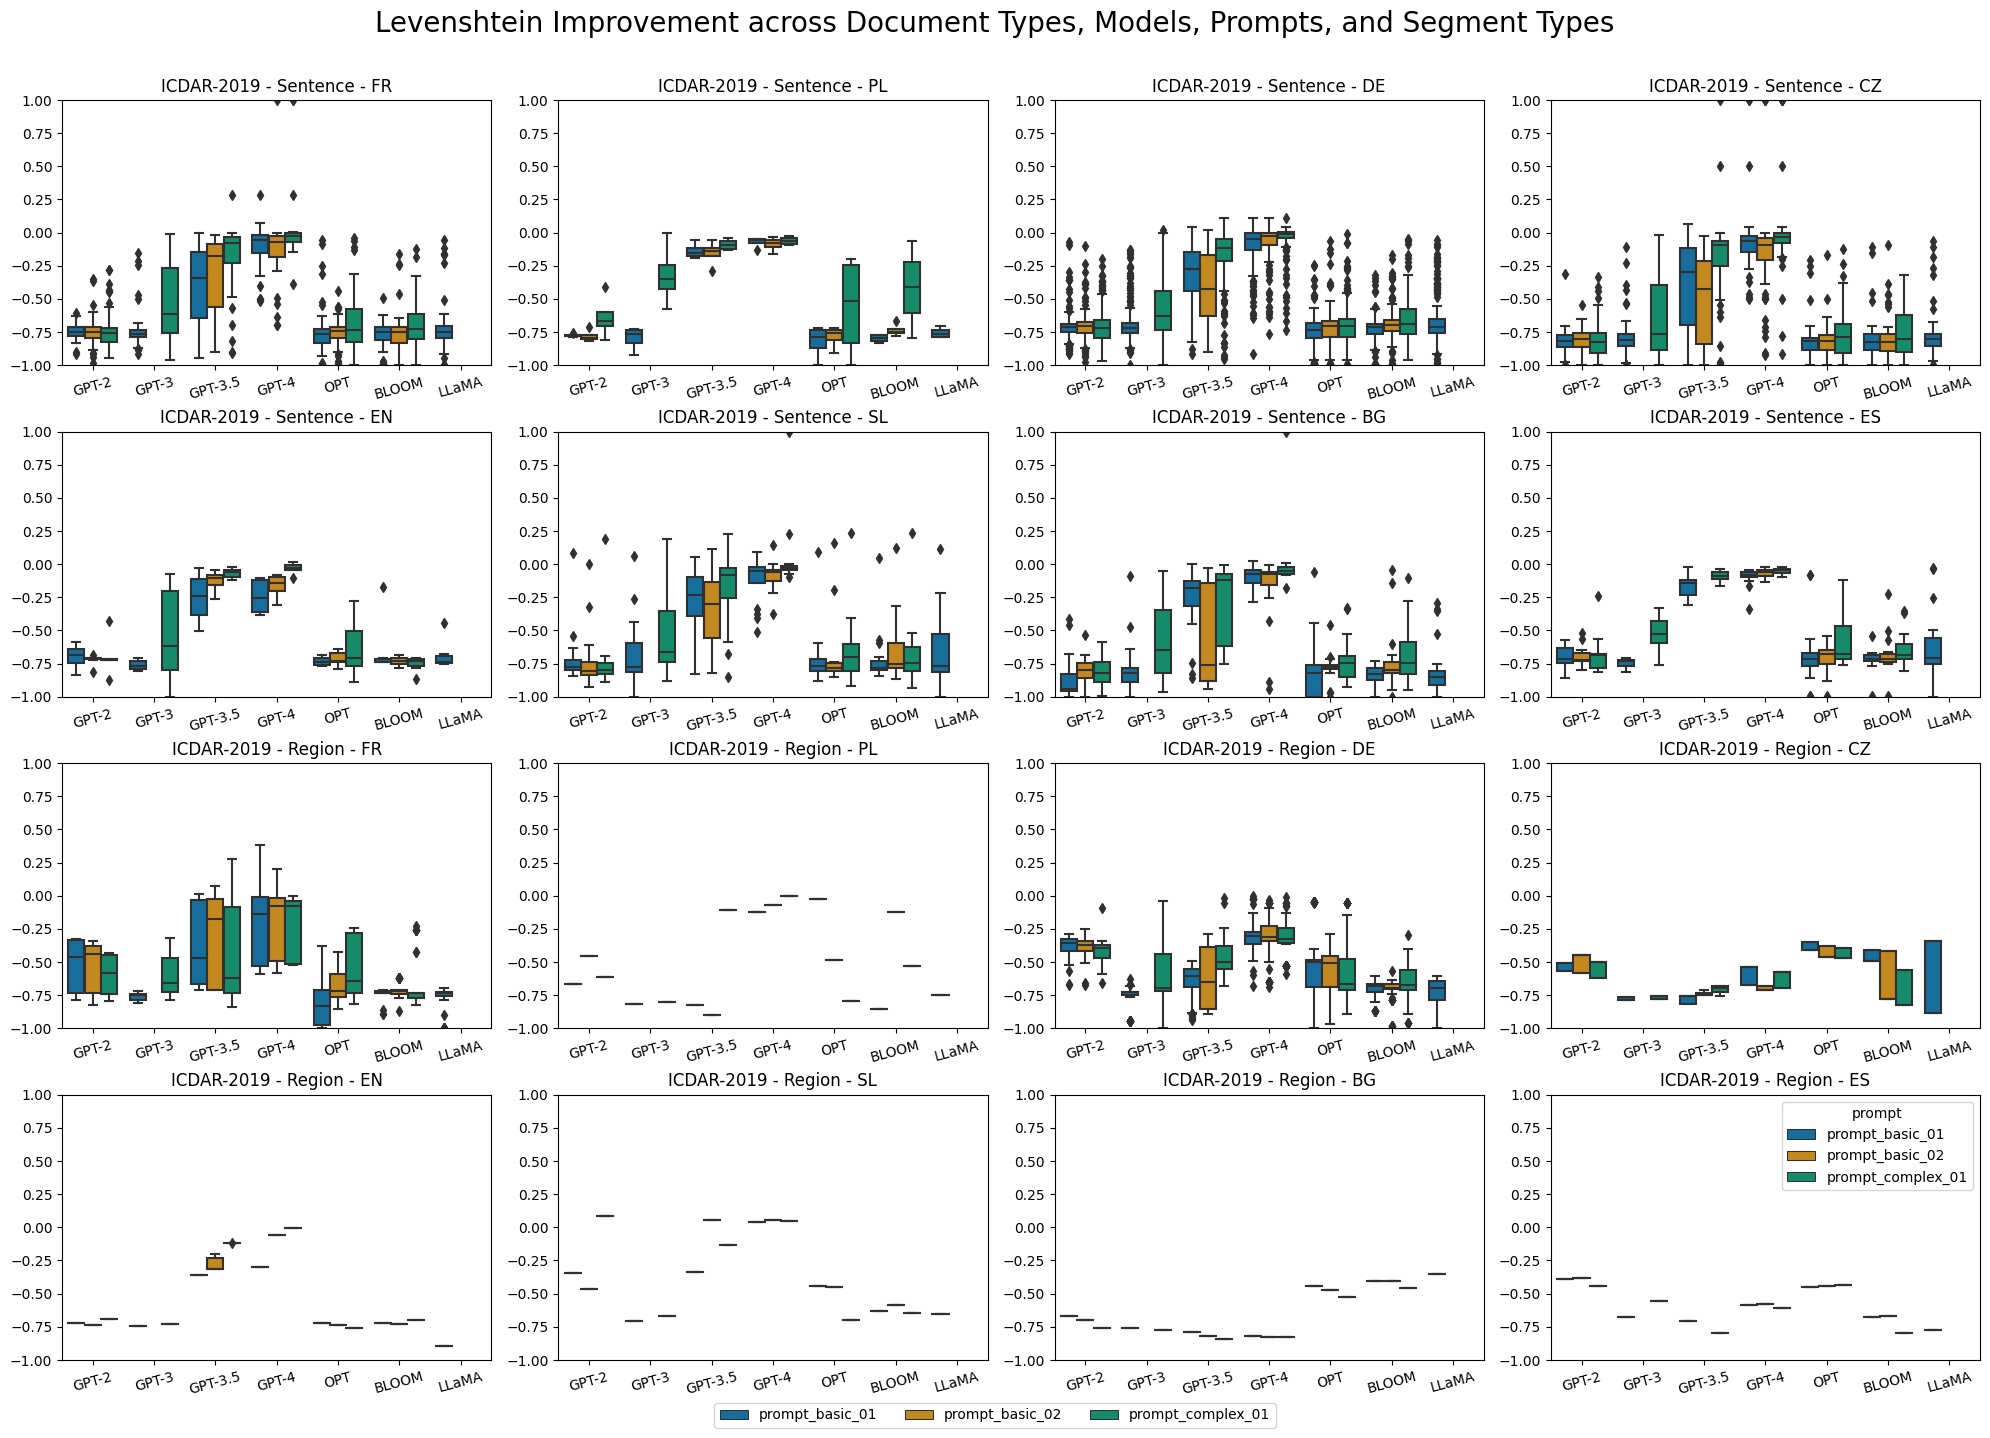

In [563]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Get the first dataset name
dataset_name = 'ICDAR-2019'

dataset_data = icdar_2019

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']
prompt_names = ['prompt_basic_01', 'prompt_basic_02', 'prompt_complex_01']
segment_types = ['sentence', 'region']
document_types = dataset_data['document_type'].unique()  # Get the unique document types

n_rows = -(-len(segment_types) * len(document_types) // 4)  # Calculate the number of rows needed

for error_rate in ['lev']:
    # Create subplots
    fig, axs = plt.subplots(n_rows, 4, figsize=(20, 15))
    axs = axs.flatten()  # Flatten the axes for easy iteration

    for i, (segment_type, document_type) in enumerate([(st, dt) for st in segment_types for dt in document_types]):
        # Select data for the current document type
        document_data = dataset_data[dataset_data.document_type == document_type]

        # Compute the segment type lev improvement
        document_data[f'{segment_type.capitalize()} Levenshtein Improvement'] = document_data[f'{segment_type}-{error_rate}-improvement']

        # Plot the distribution of improvements for each model
        _ = sns.boxplot(x='model', y=f'{segment_type.capitalize()} Levenshtein Improvement', data=document_data, 
                    ax=axs[i], order=model_names, hue='prompt', hue_order=prompt_names)

        axs[i].set_title(f'{dataset_name.upper()} - {segment_type.capitalize()} - {document_type}')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=15)  # Rotate x-axis labels
        axs[i].set_xlabel('')  # Remove x-axis label
        axs[i].set_ylabel('')  # Remove y-axis label
        axs[i].set_ylim([-1, 1])  # Set y-axis limits

        # Remove the legend for all but the last subplot
        if i < len(axs) - 1:
            axs[i].legend().set_visible(False)

    # Remove extra subplots
    for i in range(len(segment_types) * len(document_types), len(axs)):
        fig.delaxes(axs[i])

    # Add a legend outside of the plot area of the last subplot
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=len(handles))

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08)  # Adjust the overall layout
    plt.suptitle('Levenshtein Improvement across Document Types, Models, Prompts, and Segment Types', fontsize=20)
    plt.show()


### AJMC

In [567]:
ajmc_mixed = data[data.dataset_name == 'ajmc-mixed']

def get_document_type(filename):
    print(filename)
#     document_type = filename.split('/')[-3]
    return filename

ajmc_mixed['document_type'] = ajmc_mixed['filename'].apply(lambda x: get_document_type(x))

ajmc_mixed.head()

bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb10234118
bsb1

filename dataset_name   
0  bsb10234118   ajmc-mixed  \
1  bsb10234118   ajmc-mixed   
2  bsb10234118   ajmc-mixed   
3  bsb10234118   ajmc-mixed   
4  bsb10234118   ajmc-mixed   

                                            ocr.line   
0  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. III. i...  \
1  I. T. XVI. p. 731. et 718. eamque κακόζηλον ἑρ...   
2  V. 9. Ἔνδον γὰρ ἀνήρ - Olim adnotavi articulum...   
3  δατος Aristoph. Lys. 370. αἱρώμεθ’ ὑμεῖς θοὔδ...   
4  xerit Sophocles χθονὸς ἀείρας et Oppian. Cyn. ...   

                              ocr.sentence   
0  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm.  \
1                                  p. 731.   
2                                    V. 9.   
3                                     Lys.   
4                                     Cyn.   

                                          ocr.region   
0  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. II. in...  \
1  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. II. in...   
2  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. II. in...   
3  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. II. in...   
4  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. II. in...   

                                    groundtruth.line   
0  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. II. in...  \
1  1. T. XVI. p. 731. et 718. eamque κακόζηλον ἑρ...   
2  V. 9. "Evdov γὰρ ‘arıjg — Olim adnotavi articu...   
3  durog Aristoph. Lys. 370. αἱρώμεθ’ ὑμεῖς θοὔδα...   
4  xerit Sophocles χθονὸς deigag et Oppian. Cyn. ...   

                      groundtruth.sentence   
0  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm.  \
1                                  p. 731.   
2                                    V. 9.   
3                                     Lys.   
4                                     Cyn.   

                                  groundtruth.region   
0  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. III. i...  \
1  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. III. i...   
2  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. III. i...   
3  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. III. i...   
4  ἀπ’ ἐκείνων ἐπὶ τὰ πάθη μετάβασις Comm. III. i...   

                                   prediction.prompt   
0  Correct the spelling and grammar of the follow...  \
1  Correct the spelling and grammar of the follow...   
2  Correct the spelling and grammar of the follow...   
3  Correct the spelling and grammar of the follow...   
4  Correct the spelling and grammar of the follow...   

                                     prediction.line  ...   
0  (I.2.8) : “For they themselves in the midst of...  ...  \
1   τὸν λόγον συναπτέειν, καὶ μηδ' ἐσθλύναι δίκας...  ...   
2  vir et mulier erant omnes in orbe, in quo ubi ...  ...   
3  πόλιν αἴσχες καὶ ὅταν παράνομον ἡμεῖς ἐγενήθημ...  ...   
4          Ὁ δ' ἕνεκεν ἦτο τοῖς ἐπιμεληθεὶς ἐδυνάμεθ  ...   

  region-wer-improvement region-ocr-noise-group article_id century  language   
0               0.030914                90-100%        NaN     NaN       NaN  \
1               0.030914                90-100%        NaN     NaN       NaN   
2               0.030914                90-100%        NaN     NaN       NaN   
3               0.030914                90-100%        NaN     NaN       NaN   
4               0.030914                90-100%        NaN     NaN       NaN   

   File  Date  Type  NbAlignedChar  document_type  
0   NaN   NaN   NaN            NaN    bsb10234118  
1   NaN   NaN   NaN            NaN    bsb10234118  
2   NaN   NaN   NaN            NaN    bsb10234118  
3   NaN   NaN   NaN            NaN    bsb10234118  
4   NaN   NaN   NaN            NaN    bsb10234118  

[5 rows x 53 columns]

In [571]:
ajmc_mixed

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
2125    NaN
2126    NaN
2127    NaN
2128    NaN
2129    NaN
Name: Date, Length: 19125, dtype: object

In [396]:
# for idx, result in enumerate(results):
for segment_type in ['line', 'sentence', 'region']:
    print(segment_type, 'level', '*'*50)
    try:
        improved_texts = dataset[dataset['model'] == 'GPT-4'] 
        impooved_texts = improved_texts[improved_texts[f'{segment_type}-lev-improvement'] >= 0.7]
        #result[result[f'{segment_type}-lev-improvement'] >= 0.3]
        for _, improved_text in improved_texts.iterrows():
            print('Model:', improved_texts['model'].unique()[0])
            print('Dataset:', improved_texts['dataset_name'].unique()[0])
            print('Quality Band:', improved_text[f'{segment_type}-ocr-noise-group'])

            print('LEV ground-ocr', improved_text[f'{segment_type}-lev-ocr'], 
                  'LEV ground-pred', improved_text[f'{segment_type}-lev-pred'])
            print('LEV Improvement:', improved_text[f'{segment_type}-lev-improvement'])
            print('CER Improvement:', improved_text[f'{segment_type}-cer-improvement'])
            print('WER Improvement:', improved_text[f'{segment_type}-wer-improvement'])

            print('Ground:', improved_text[f'groundtruth.{segment_type}'][:50])
            print('OCR:', improved_text[f'ocr.{segment_type}'][:50])
            print('Pred:', improved_text[f'prediction.{segment_type}'])
            print('--'*50)
    except:
        continue
        

line level **************************************************
Model: GPT-4
Dataset: htrec
Quality Band: 0-70%
LEV ground-ocr 0.6216216216216216 LEV ground-pred 0.028225806451612902
LEV Improvement: -0.954593267882188
CER Improvement: 0.3076923076923077
WER Improvement: 0.42307692307692296
Ground: ἀλλ εἴσιθ ὡς ὁ μάγειρος ἤδη τὰ τεμάχη
OCR: ἀλλ εήσιθως οματειρσος ηδητα τεμμε
Pred: Although I am an AI language model, I am unable to correct the spelling or grammar of this text as it appears to be transcribed from a non-standard script or language, possibly an ancient or fictional language. Please provide the text in a standard
----------------------------------------------------------------------------------------------------
Model: GPT-4
Dataset: htrec
Quality Band: 0-70%
LEV ground-ocr 0.6363636363636364 LEV ground-pred 0.6363636363636364
LEV Improvement: 0.0
CER Improvement: -0.016897081413210453
WER Improvement: -0.014778325123152618
Ground: ἔμελλ ἀφαιρεῖν χἠ τράπεζ εἰσῄρετο
OCR: εμελλ

In [222]:
data.columns

Index(['filename', 'dataset_name', 'article_id', 'ocr.line', 'ocr.sentence',
       'ocr.region', 'groundtruth.line', 'groundtruth.sentence',
       'groundtruth.region', 'prediction.prompt', 'prediction.line',
       'prediction.sentence', 'prediction.region', 'model', 'prompt', 'length',
       'line-lev-ocr', 'line-lev-pred', 'line-lev-improvement', 'line-cer-ocr',
       'line-cer-pred', 'line-wer-ocr', 'line-wer-pred',
       'line-cer-improvement', 'line-wer-improvement', 'line-ocr-noise-group',
       'sentence-lev-ocr', 'sentence-lev-pred', 'sentence-lev-improvement',
       'sentence-cer-ocr', 'sentence-cer-pred', 'sentence-wer-ocr',
       'sentence-wer-pred', 'sentence-cer-improvement',
       'sentence-wer-improvement', 'sentence-ocr-noise-group',
       'region-lev-ocr', 'region-lev-pred', 'region-lev-improvement',
       'region-cer-ocr', 'region-cer-pred', 'region-wer-ocr',
       'region-wer-pred', 'region-cer-improvement', 'region-wer-improvement',
       'region-ocr-n

In [ ]:
for 

<Figure size 1200x600 with 0 Axes>

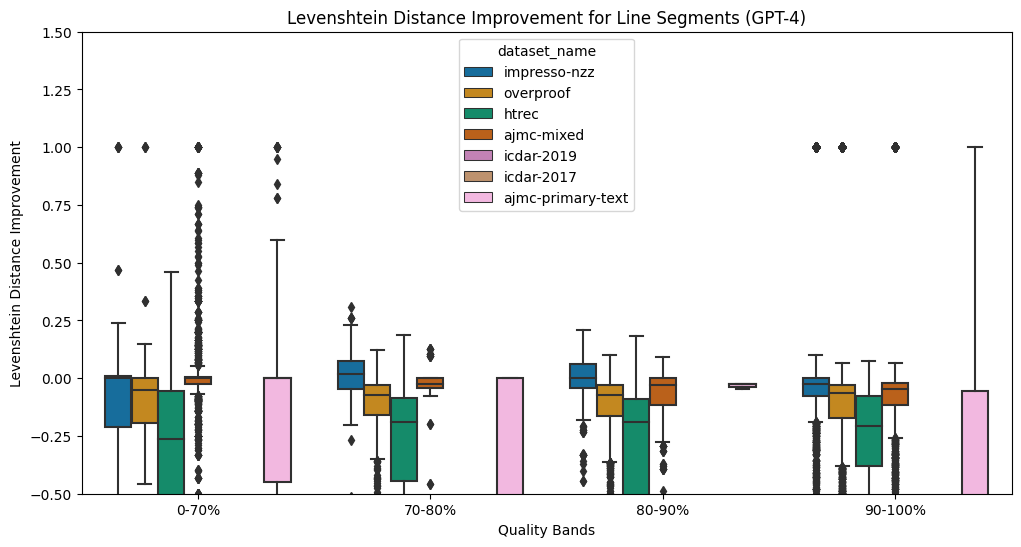

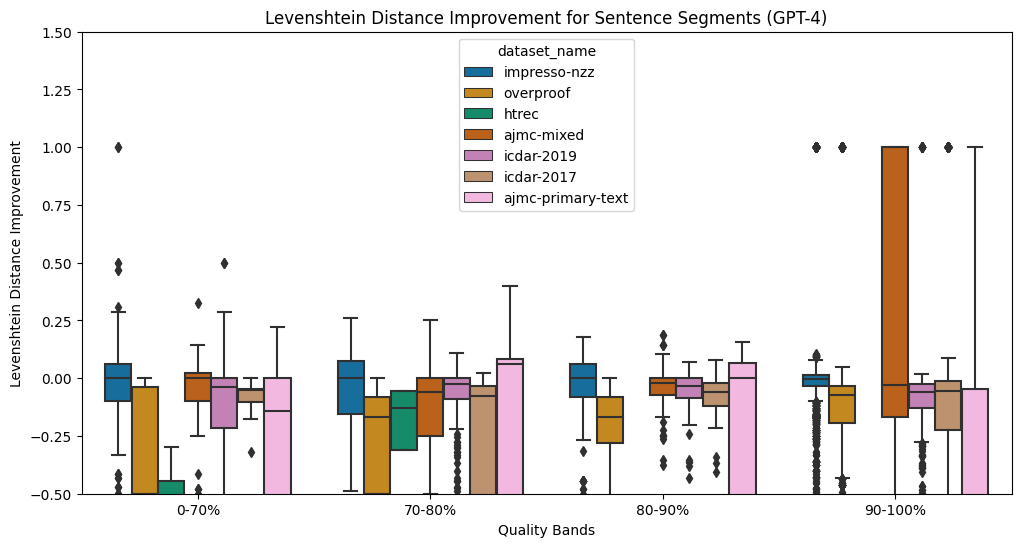

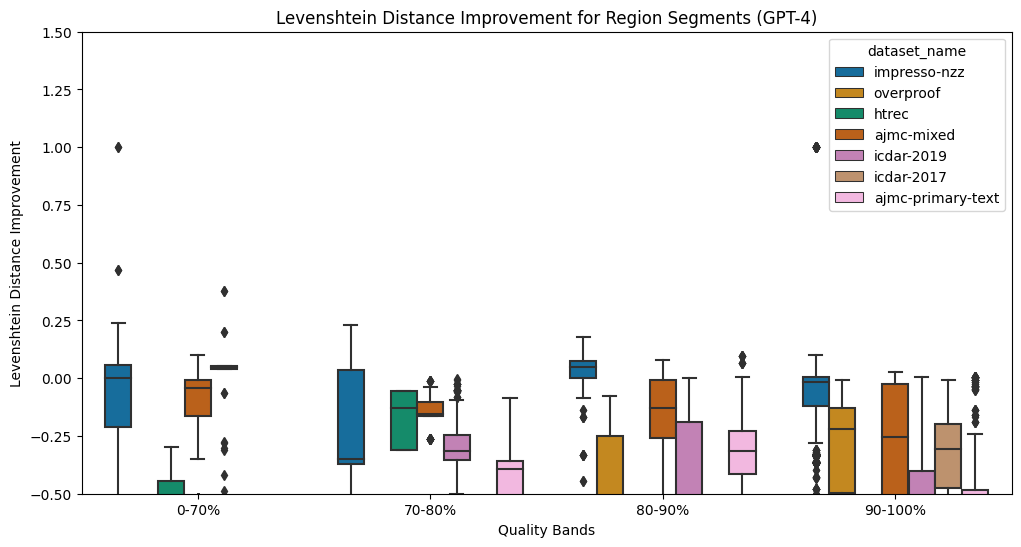

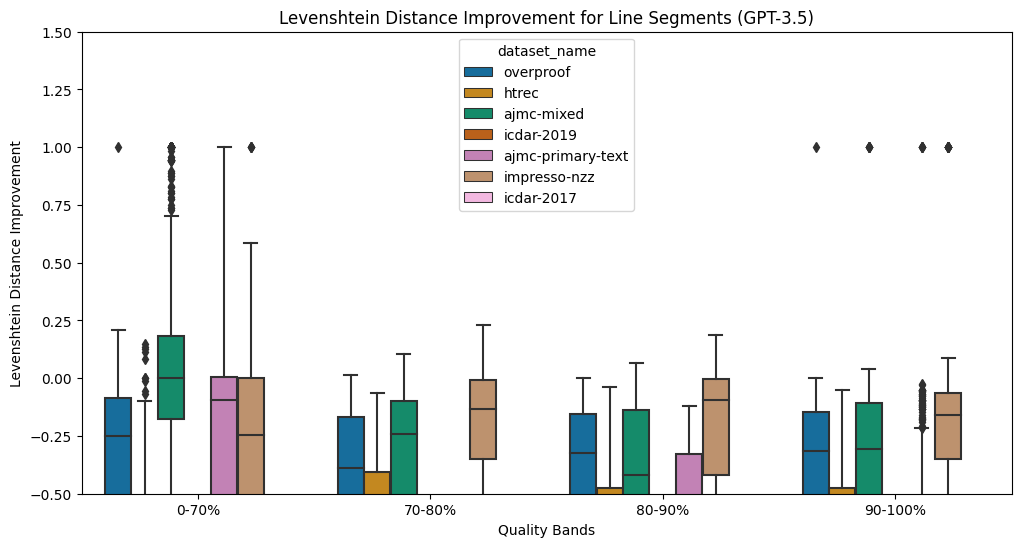

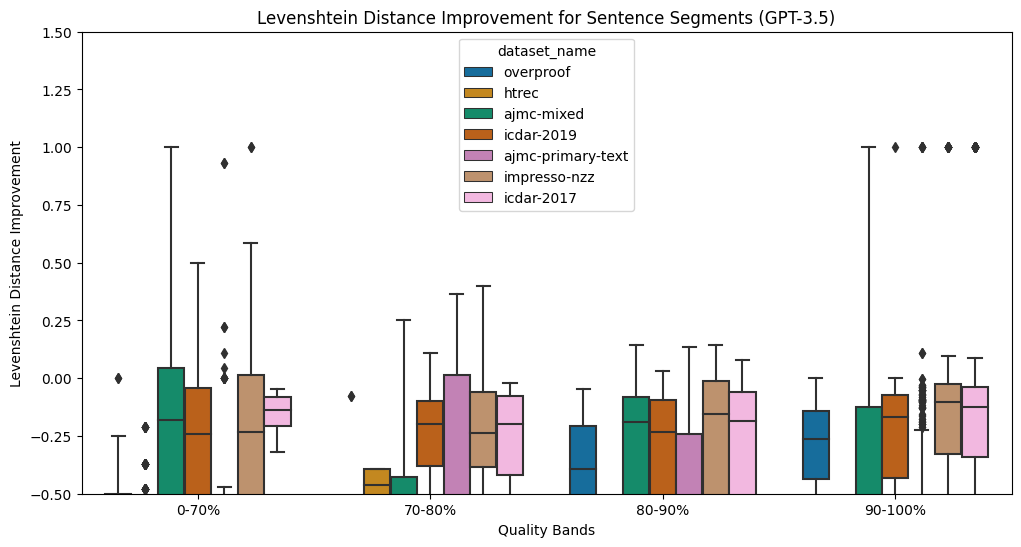

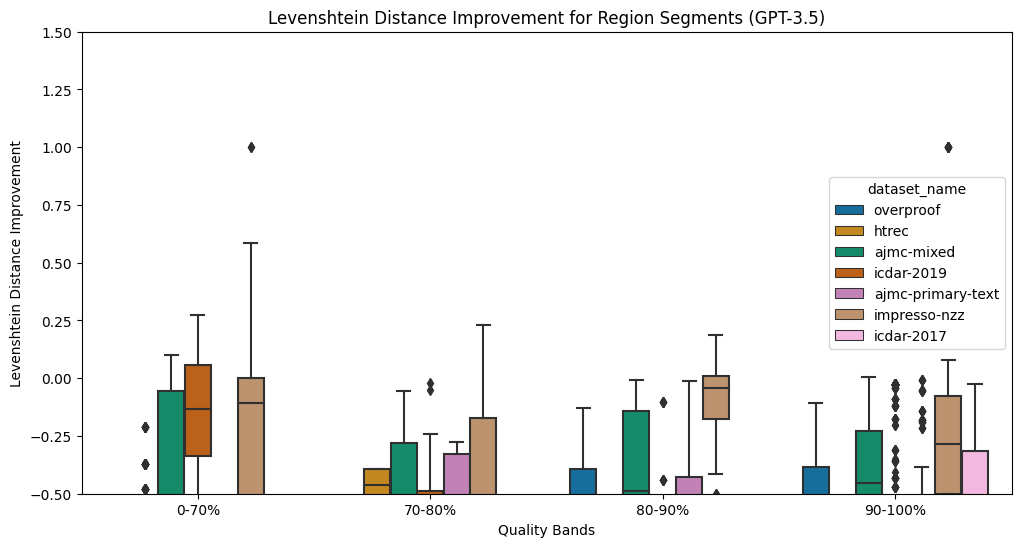

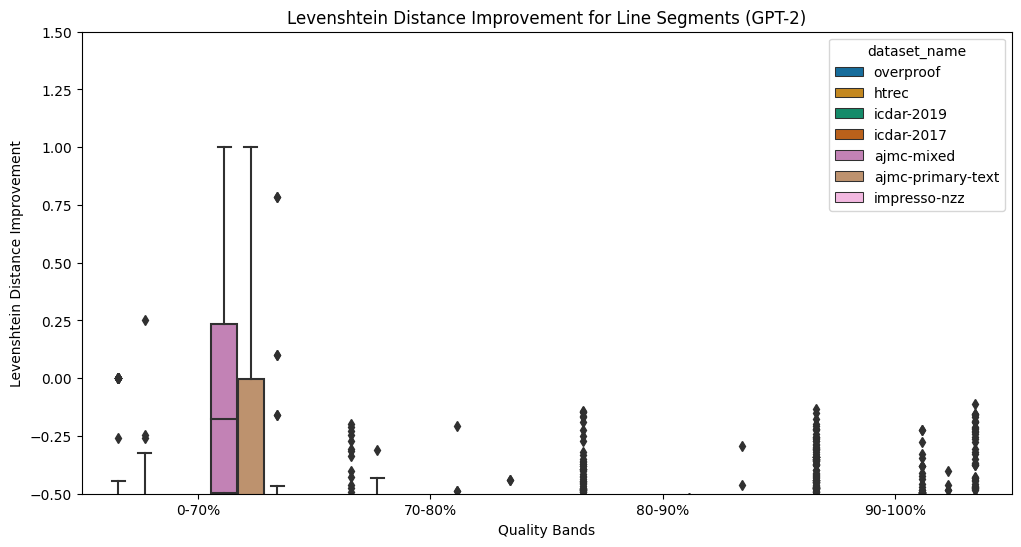

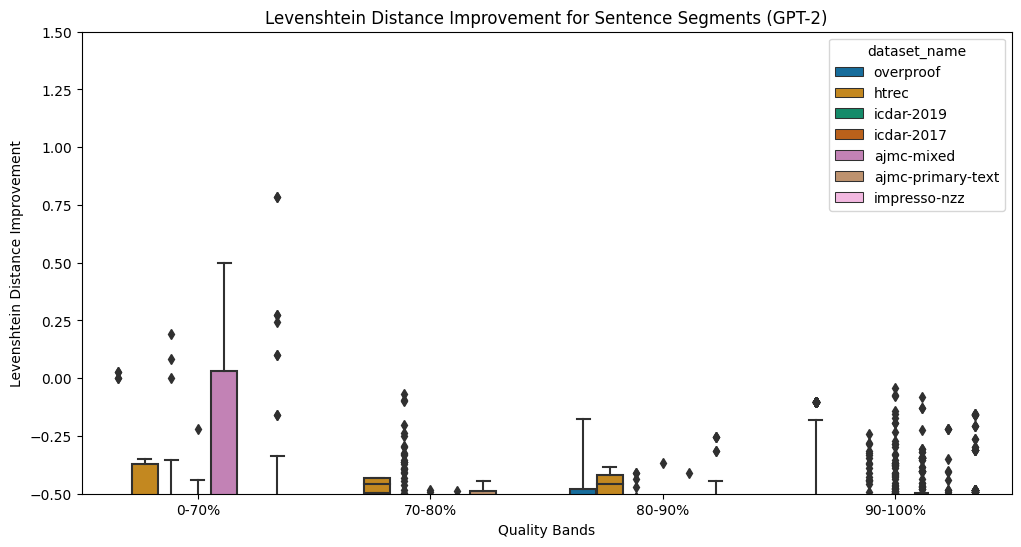

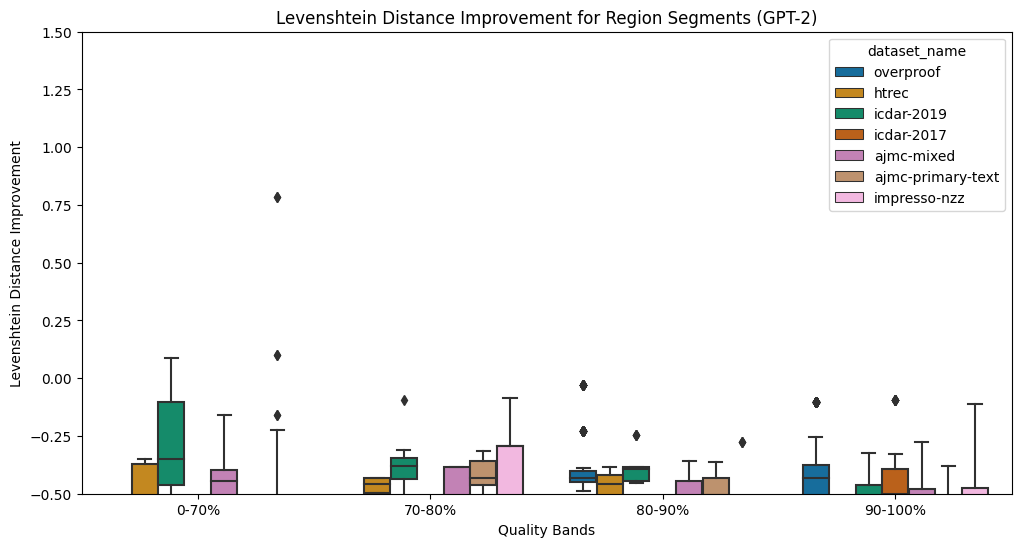

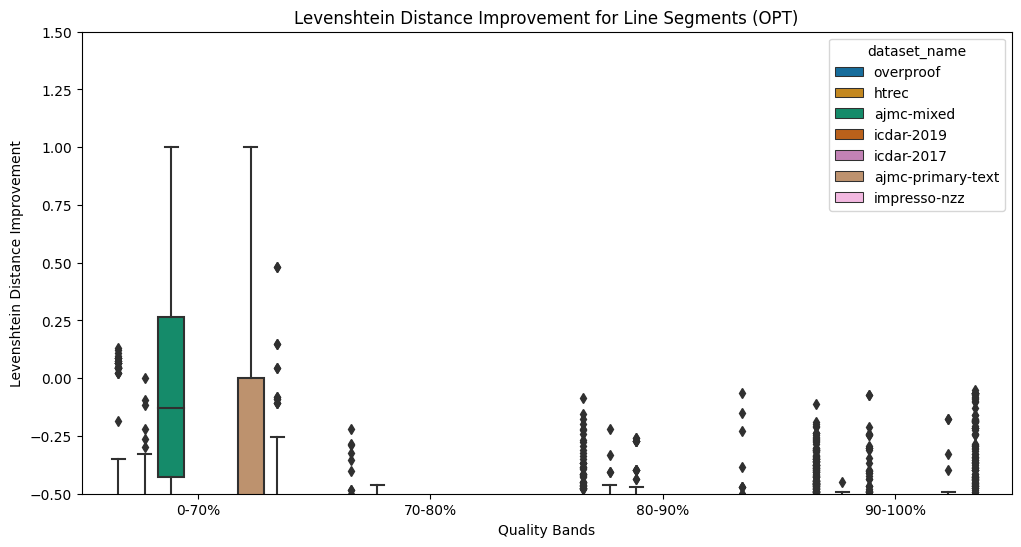

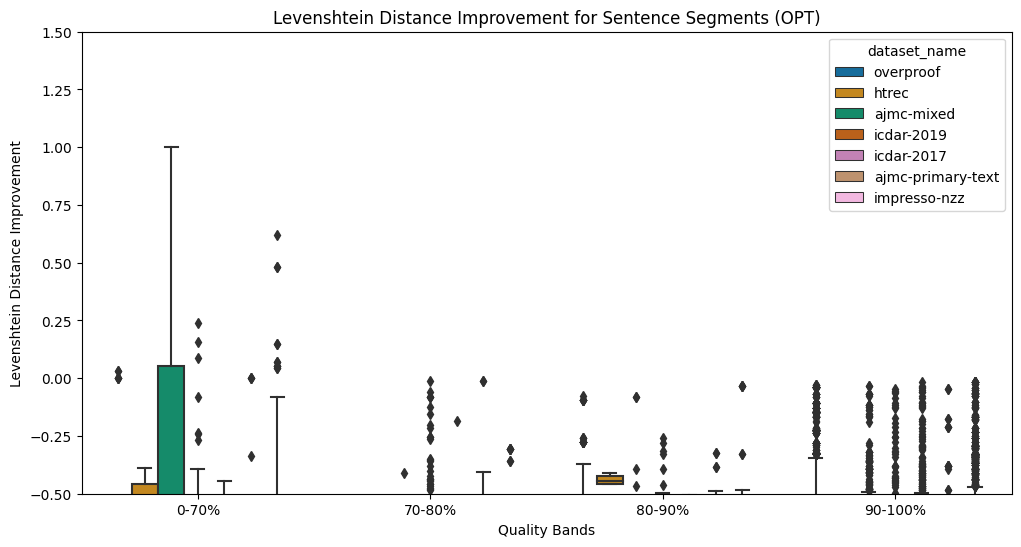

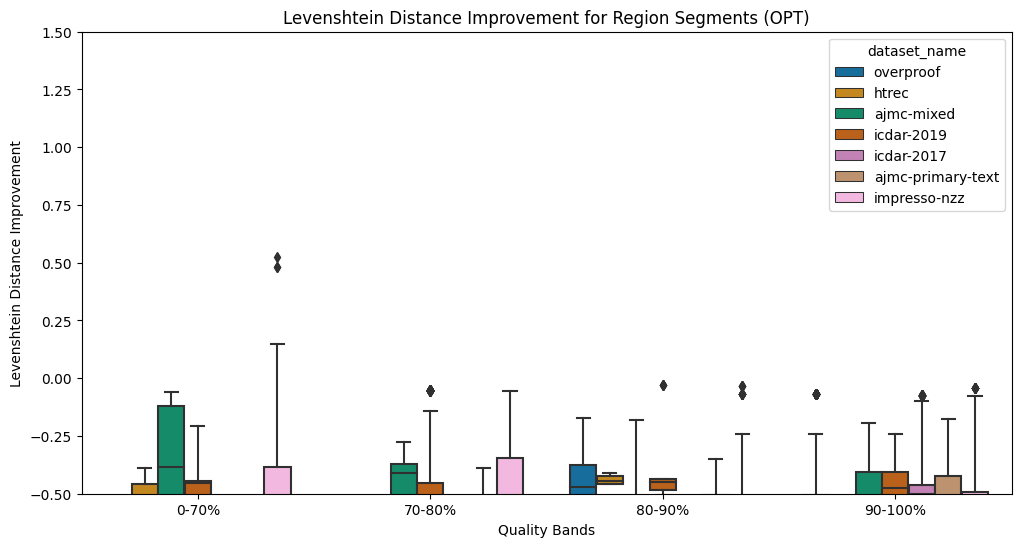

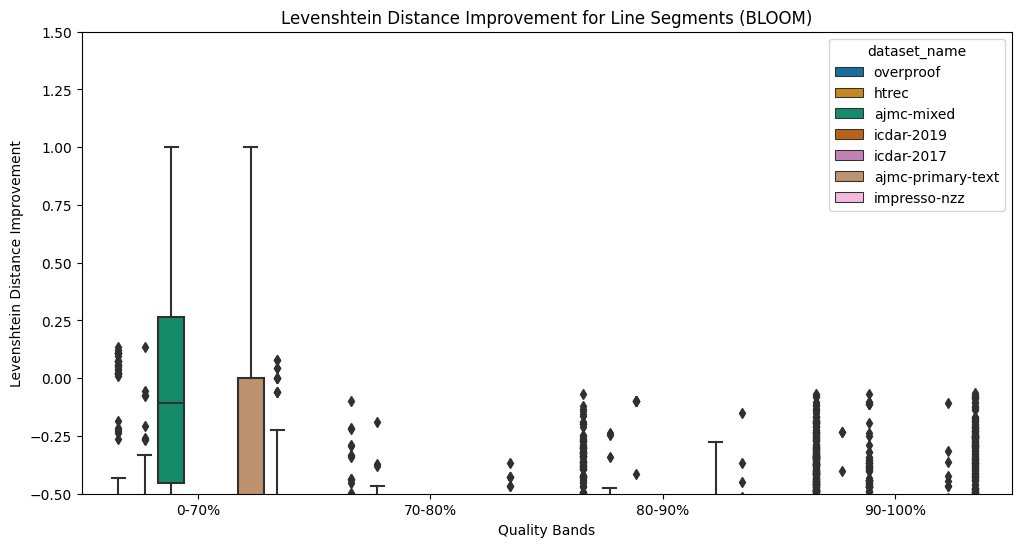

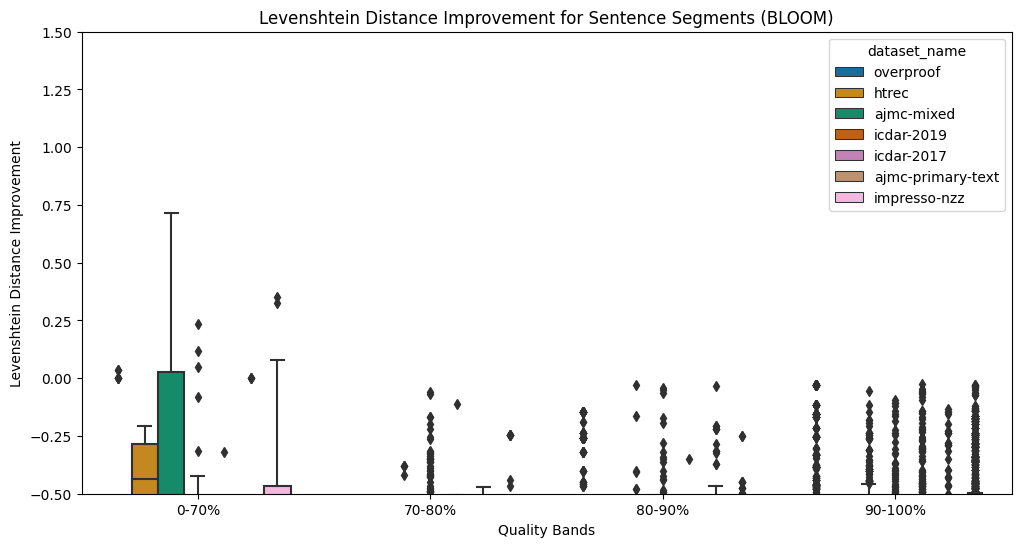

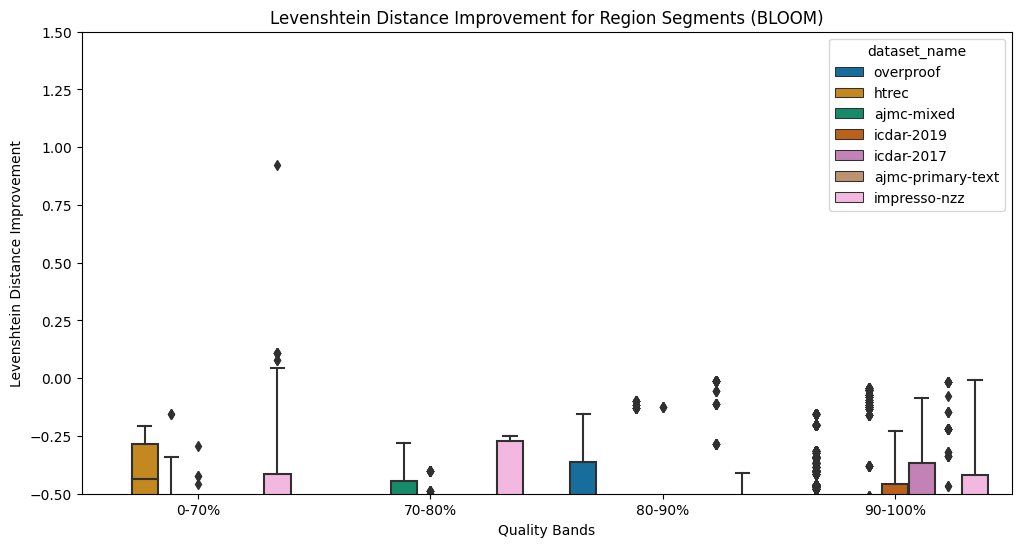

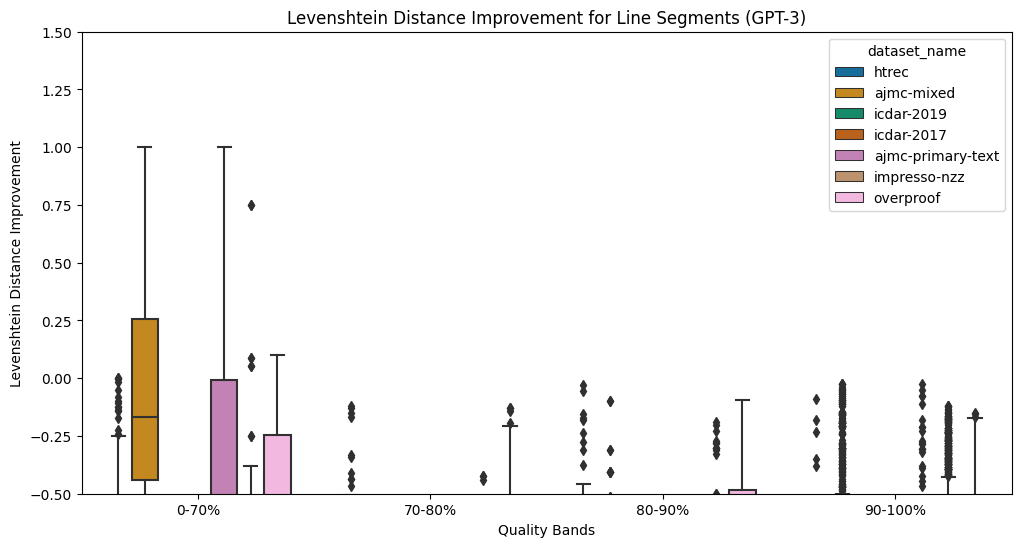

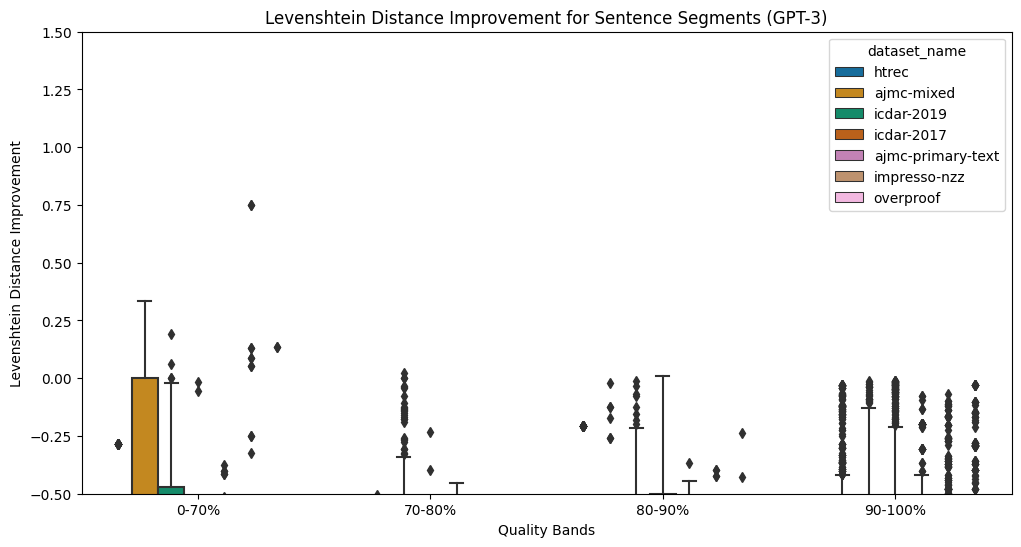

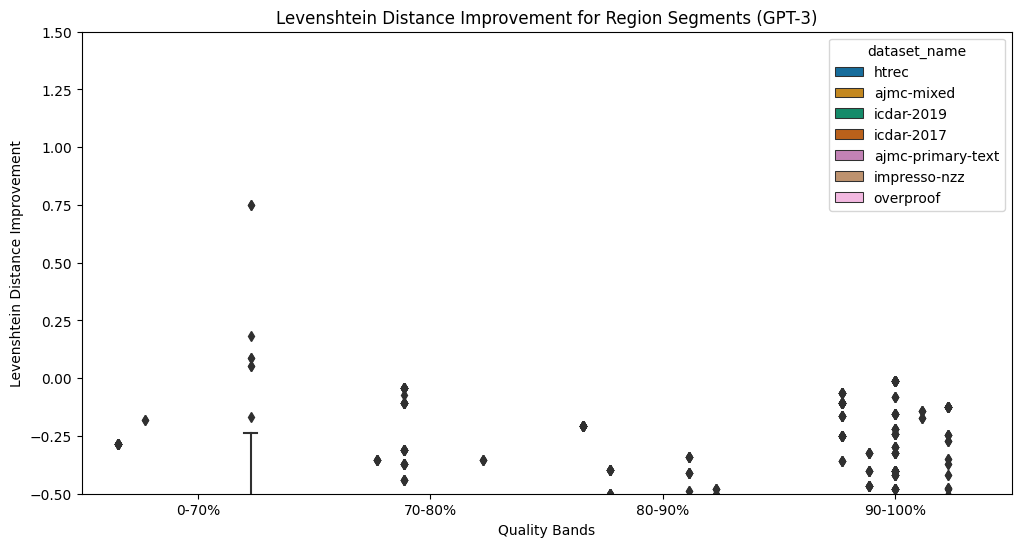

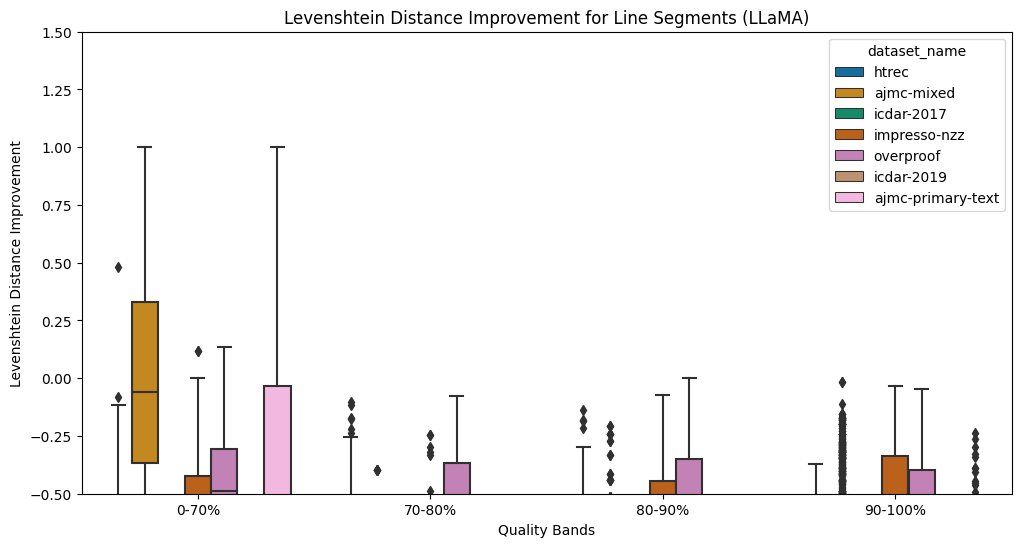

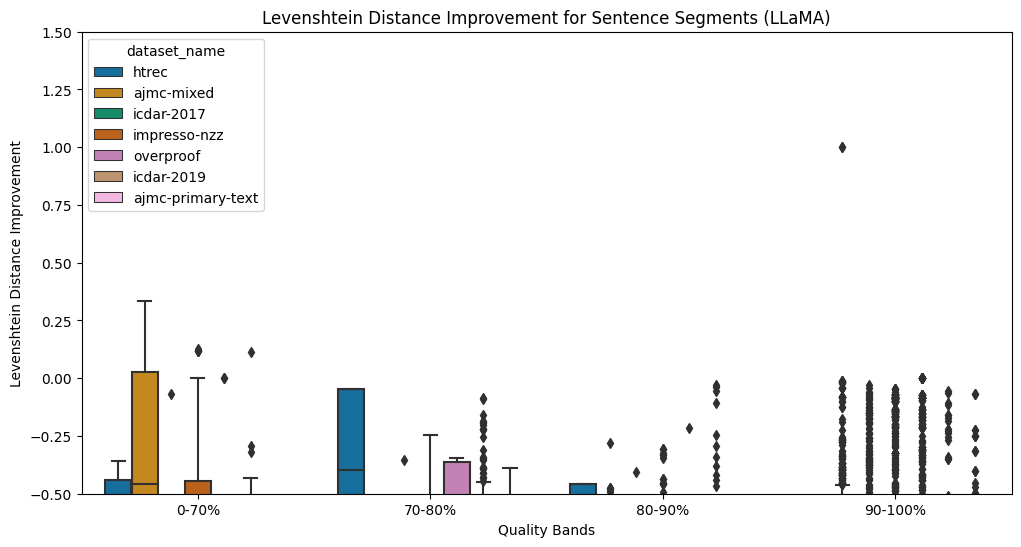

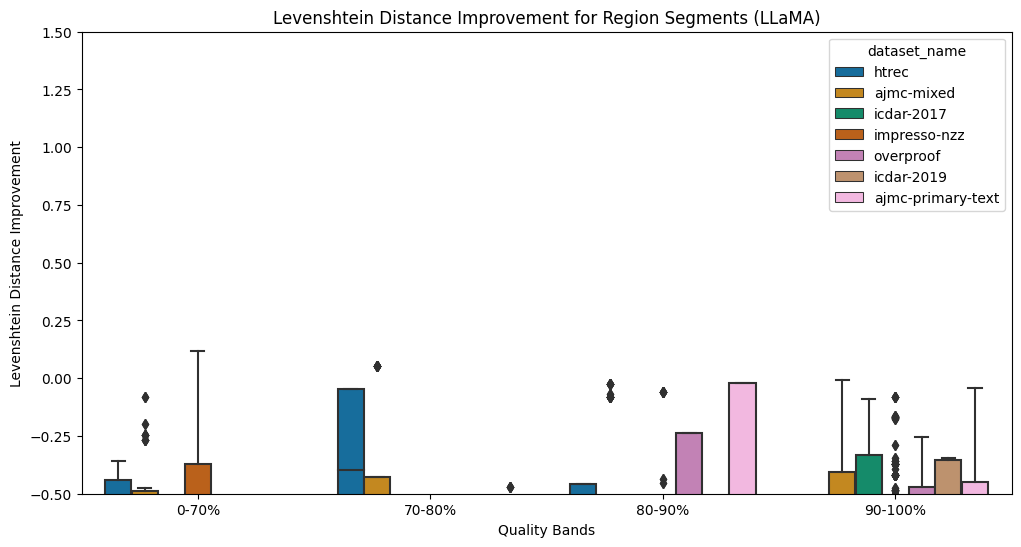

In [537]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the colorblind color palette
sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))

for model in data['model'].unique():
    data_per_model = data[data['model'] == model]
    for segment_type in ['line', 'sentence', 'region']:
        # Filter the data by dataset and segment type
        fig, ax = plt.subplots(figsize=(12, 6))

        # Create the box plot
        sns.boxplot(x=f'{segment_type}-ocr-noise-group', y=f'{segment_type}-lev-improvement', 
                    data=data_per_model, hue='dataset_name', palette='colorblind', ax=ax)

        # Set the plot title and axis labels
        plt.title(f'Levenshtein Distance Improvement for {segment_type.capitalize()} Segments ({model})')
        plt.xlabel('Quality Bands')
        plt.ylabel('Levenshtein Distance Improvement')
        
        plt.ylim((-0.5, 1.5))
        # Show the plot
        plt.show()



In [ ]:
for model in data['dataset_name'].unique():
    data_per_model = data[data['dataset_name'] == model]
    for segment_type in ['line', 'sentence', 'region']:
        # Filter the data by dataset and segment type
        fig, ax = plt.subplots(figsize=(12, 6))

        # Create the box plot
        sns.boxplot(x=f'{segment_type}-ocr-noise-group', y=f'{segment_type}-lev-improvement', 
                    data=data_per_model, hue='model', palette='colorblind', ax=ax)

        # Set the plot title and axis labels
        plt.title(f'Levenshtein Distance Improvement for {segment_type.capitalize()} Segments ({model})')
        plt.xlabel('Quality Bands')
        plt.ylabel('Levenshtein Distance Improvement')
        
        plt.ylim((-0.2, 1.0))
        # Show the plot
        plt.show()



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the colorblind color palette
sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))

for result in results:
    
    dataset_name = result['dataset_name'].unique()[0]
    
    for segment_type in ['line', 'sentence', 'region']:
        
        #grouped_results = result.groupby([f"{segment_type}-ocr-noise-group", "dataset_name"]).size().reset_index(name="count")
        
        grouped_results = result.groupby([f"{segment_type}-ocr-noise-group", "dataset_name"])[f"{segment_type}-lev-improvement"].mean().reset_index()

        print(grouped_results.head())
        
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        _ = sns.lineplot(x=f"{segment_type}-ocr-noise-group", y=f'{segment_type}-lev-improvement', hue='dataset_name',
                 data=grouped_results, ax=ax, markers=True, linestyle='-', linewidth=2.5)


        # Set plot labels
        ax.set_xlabel(f"{dataset_name} Ground Truth {segment_type.capitalize()}")
        ax.set_ylabel(f"{dataset_name} {segment_type.capitalize()} Improvement")
        ax.set_title(f"{dataset_name} Levenshtein Improvement for {segment_type.capitalize()} OCR Examples")


        # Show the plot
        plt.show()

